---
## **Single Cell Proteomics Meta-Analysis**
### **Author**: Gerard Font
**Date:** January 2025<br>
***MBDS** - Master Biomedical Data Science*

Meta-analysis, is a statistical technique that combines and analyzes data from multiple independent studies, which has become increasingly important in the field of single-cell proteomics. By integrating data from different experiments, meta-analysis allows for the identification of robust and reproducible findings, overcoming the limitations of individual studies and providing a more comprehensive view of the biological landscape.

The objectives of this thesis are as follows:
1. Review and summarize the existing literature on single-cell proteomics and meta-analysis.
2. Collect and curate relevant single-cell proteomic datasets from public repositories.
3. Develop a comprehensive data analysis pipeline for meta-analysis of single-cell proteomic data.
4. Apply the developed pipeline to integrate and analyze the collected datasets.
5. Identify differentially expressed proteins, cellular subpopulations, and potential biomarkers.
6. Validate the findings through comparison with independent datasets and experimental validation.
7. Interpret the results and provide biological insights into the studied biological systems.

Through this master thesis, I hope to provide a comprehensive overview of the data analysis techniques employed in single-cell proteomics meta-analysis and demonstrate their utility in uncovering novel biological insights.

---

### Cell types
The notebook and the meta-analysis are centered on examining experiments that utilize human monocytes and macrophages, specifically focusing on the M0, M1, and M2 phenotypes. These studies are crucial for understanding the functional differentiation and polarization of monocytes into macrophages, which play vital roles in immune response and inflammation. By analyzing the proteomic profiles and comparing the abundance of proteins in these different macrophage states, the research aims to uncover key regulatory mechanisms and potential biomarkers that influence macrophage behavior and their responses to various stimuli. This comprehensive approach provides valuable insights into macrophage biology and their roles in health and disease.

* **M0** - Undifferentiated macrophages or monocytes
* **M1** - Classically activated macrophages (stimulated with LPS or IFN-γ)
* **M2** - Alternatively activated macrophages (stimulated with IL-4 or IL-13) 
<br>

---
### Import Libraries

Required libraries

In [1]:
# Import pandas
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

# Venn diagram
from matplotlib_venn import venn3
from matplotlib_venn import venn2

# Core scverse libraries
import scanpy as sc
import anndata as ad
import numpy as np

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Gerard's libraries
from src.uniprot_client import UniprotClient
from src.stringdb_client import StringDBClient

from IPython.display import Image, display

import warnings 

/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


___
### Configuration 

General configuration

In [79]:
uniprot = UniprotClient()

TRANSLATE_PROTEIN_ID = True     # True to use UniprotKB API to translate all protein ID's. False to use the backup (already translated protein ID's)

# Filtering thresholds
MIN_NUM_PEPTIDE_THRESHOLD = 2   # Minimum number of peptides required to consider a protein as identified
PSM_THRESHOLD = 5               # Minimum number of PSMs required to consider a protein as identified
SCORE_THRESHOLD = 1.5           # Minimum score required to consider a protein as identified

TOP_GENES = 10                  

# Differential Expression Analysis (DEA) Thresholds
LOG2_THRESHOLD = 1
PVAL_THRESHOLD = 0.05

warnings.filterwarnings('ignore')

In [3]:
custom_theme = {
    "axes.facecolor": "white",
    "axes.edgecolor": "gray",
    "axes.grid": True,
    "grid.color": ".97",
    "grid.linestyle": "-",
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "xtick.color": "gray",
    "ytick.color": "gray",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.frameon": True,
    "legend.fontsize": 7,
    "font.family": "sans-serif", 
    "font.serif": "Calibri",
    "legend.title_fontsize": 8
}


# Apply the custom theme
sns.set_theme(style="ticks", rc=custom_theme)
sns.despine()
sns.set_palette(["#4CC9F0", "#4361EE", "#3A0CA3", "#F72585", "#7209B7", "#3A0CA3", "#4361EE", "#4CC9F0"])

# Customize font and palette
#sns.set_context("notebook", font_scale=0.9)
#sns.set_palette("colorblind")
#sns.set_palette(sns.color_palette("Paired"))
#sns.set_palette(sns.color_palette("rocket"))
#sns.set_palette(sns.color_palette("tab10"))
#sns.set_palette(sns.color_palette("tab20"))
#sns.set_palette(sns.color_palette("Spectral"))
#sns.set_palette(sns.color_palette("hls", 8)

# https://r02b.github.io/seaborn_palettes/

<Figure size 640x480 with 0 Axes>

---
### Data Sources

The meta-analysis will include the following data sources:

* **EXPERIMENT 1:** ./data/processed/2016_Iwata_ncomms12849/**SI_THP_RAW_proteomics_data_ss.xlsx**<br>
*Iwata, H., Goettsch, C., Sharma, A., Ricchiuto, P., Goh, W. W. bin, Halu, A., Yamada, I., Yoshida, H., Hara, T., Wei, M., Inoue, N., Fukuda, D., Mojcher, A., Mattson, P. C., Barabási, A. L., Boothby, M., Aikawa, E., Singh, S. A., & Aikawa, M. (2016). PARP9 and PARP14 cross-regulate macrophage activation via STAT1 ADP-ribosylation. Nature Communications 2016 7:1, 7(1), 1–19. https://doi.org/10.1038/ncomms12849*
<br><br>
* **EXPERIMENT 2:** ./data/processed/2022_Pengfei LI_35557041/**PD_Globalproteomics_2024.xlsx**<br>
*Li, P., Ma, C., Li, J., You, S., Dang, L., Wu, J., Hao, Z., Li, J., Zhi, Y., Chen, L., & Sun, S. (2022). Proteomic characterization of four subtypes of M2 macrophages derived from human THP-1 cells. Journal of Zhejiang University. Science. B, 23(5), 407–422. https://doi.org/10.1631/jzus.B2100930*
<br><br>
* **EXPERIMENT 3:** ./data/processed/2021_Pengfei LI_34267761/**THP1_global_M0_M1_M2_proteins.xlsx**<br>
*Li, P., Hao, Z., Wu, J., Ma, C., Xu, Y., Li, J., Lan, R., Zhu, B., Ren, P., Fan, D., & Sun, S. (2021). Comparative Proteomic Analysis of Polarized Human THP-1 and Mouse RAW264.7 Macrophages. Frontiers in Immunology, 12, 700009. https://doi.org/10.3389/FIMMU.2021.700009*
<br><br>
* **EXPERIMENT 4:** ./data/processed/2022_Huffman/**limmaCorrected_normed_prePCA_Priori_mrri02_PIF50_DART_1pFDR.csv** (metadata: ./data/processed/2022_Huffman/BMDM_pSCoPE_SampleGuide.csv)<br>
*Huffman, R. G., Leduc, A., Wichmann, C., di Gioia, M., Borriello, F., Specht, H., Derks, J., Khan, S., Khoury, L., Emmott, E., Petelski, A. A., Perlman, D. H., Cox, J., Zanoni, I., & Slavov, N. (2023). Prioritized mass spectrometry increases the depth, sensitivity and data completeness of single-cell proteomics. Nature Methods 2023 20:5, 20(5), 714–722. https://doi.org/10.1038/s41592-023-01830-1*
<br><br>

<br><br>
TODO: DELETE
* **EXPERIMENT 5:** ./data/...<br>
*Specht, H., Emmott, E., Petelski, A. A., Huffman, R. G., Perlman, D. H., Serra, M., Kharchenko, P., Koller, A., & Slavov, N. (2021). Single-cell proteomic and transcriptomic analysis of macrophage heterogeneity using SCoPE2. Genome Biology, 22(1), 1–27. https://doi.org/10.1186/S13059-021-02267-5/TABLES/2*
<br><br>


In [4]:
# Paths to each of the data sources
path_2016_iwata = "./data/processed/2016_Iwata_ncomms12849/SI_THP_RAW_proteomics_data_ss.xlsx"
path_2022_pengfei = "./data/processed/2022_Pengfei LI_35557041/PD_Globalproteomics_2024.xlsx"
path_2021_pengfei = "./data/processed/2021_Pengfei LI_34267761/THP1_global_M0_M1_M2_proteins.xlsx"
path_2022_huffman = "./data/processed/2022_Huffman/limmaCorrected_normed_prePCA_Priori_mrri02_PIF50_DART_1pFDR.csv"
path_2022_huffman_meta = "./data/processed/2022_Huffman/BMDM_pSCoPE_SampleGuide.csv"

---
# Meta-analysis objectives
As part of the meta-analysis, several data analysis activities will be performed (detailed in the following table). These activities include quantitative proteomic profiling, differential expression analysis and pathway analysis. It is important to note that due to limitations in some of the data sources, not all activities may be available for every dataset. The analysis will be adapted accordingly to ensure the most comprehensive and accurate interpretation possible given the available data.

✅ **Available**<br>
🔰 **Partially available**<br>
❌ **Not available**<br><br>

<table style="text-align: center;">
  <tr style="background-color: #cccccc;">
    <th>Study</th>
    <th>Type*</th>
    <th>Quantitative proteomic<br>profiling</th>
    <th>Differential Expression<br>Analysis</th>
    <th>Pathway Analysis</th>
  </tr>
  <tr>
    <td style="background-color: #efefef; text-align: left"><a href="https://www.nature.com/articles/ncomms12849" target="_blank">Iwata, H., et al. (2016)</a></td>
    <td style="background-color: #efefef;">Bulk</td>
    <td>✅</td>
    <td>✅</td>
    <td>✅</td>
  </tr>
  <tr>
    <td style="background-color: #efefef; text-align: left"><a href="https://link.springer.com/article/10.1631/jzus.B2100930" target="_blank">Li, P., et al. (2022)</a></td>
    <td style="background-color: #efefef;">Bulk</td>
    <td>✅</td>
    <td>✅</td>
    <td>✅</td>
  </tr>
  <tr>
    <td style="background-color: #efefef; text-align: left"><a href="https://pubmed.ncbi.nlm.nih.gov/34267761/" target="_blank">Li, P., et al. (2021)</a></td>
    <td style="background-color: #efefef;">Bulk</td>
    <td>✅</td>
    <td>✅</td>
    <td>✅</td>
  </tr>

  <tr>
    <td style="background-color: #efefef; text-align: left"><a href="https://www.nature.com/articles/s41592-023-01830-1" target="_blank">Huffman, R. G., et al. (2022)</a></td>
    <td style="background-color: #efefef;">Single Cell</td>
    <td>🔰</td>
    <td>✅</td>
    <td>✅</td>
  </tr>    
  <tr style="font-weight: bold; background-color: #efefef;">
    <td colspan="2" style="text-align: center;">Comparison</td>
    <td>Yes</td>
    <td>Yes</td>
    <td>Yes</td>
  </tr></table>

\**Bulk studies present in this table used cell lines and averaged the abundances of iditified proteins*
<br><br>

**Goals:**
1. Distinct Phenotypic Profiles: Understanding the unique protein profiles associated with each polarization state.
2. Shared and Unique Pathways: Pinpointing common and specific pathways that characterize different macrophage phenotypes.
<br><br><br>

**1. Top 20 Up/Down represented proteins in M1 & M2 vs M0   <->  Differential Protein Expression**
* Pairwise Comparisons: Compare M0 vs. M1, M0 vs. M2, and M1 vs. M2 to identify proteins that are upregulated or downregulated in specific polarization states.
* Fold Change Analysis: Quantify the magnitude of changes in protein expression.
* Statistical Significance: Assess the significance of changes using statistical tests like t-tests or ANOVA.

<span style="color:red">
Ideas:<br>
&#160;&#160;&#160;- Barplot with proteins found in M0, M1 and M2 (per study)<br>
&#160;&#160;&#160;- 2x Dendograms with top over/down represented proteins of M1 and M2 vs M0  (per study)<br>
&#160;&#160;&#160;- Comparison: top up/down repr. proteins found in only some of the experiments<br>
</span>

**2. Pathway Analysis (GSEA)   <->   Functional Enrichment Analysis**
* Gene Ontology (GO) Enrichment: Identify biological processes, molecular functions, and cellular components that are enriched in differentially expressed proteins.
* Pathway Analysis: Determine which signaling pathways are activated or inhibited in different polarization states.
* Protein-Protein Interaction Network Analysis: Visualize the interactions between differentially expressed proteins to identify key regulatory hubs.

---
### Load the Data

In [5]:
# EXPERIMENT 1 -----------------------------------------------------------------------------------------------------------
# Load the data from different sheets
df_2016_iwata_M0 = pd.read_excel(path_2016_iwata, sheet_name="THP_M0", index_col=0) # Index = Accession
df_2016_iwata_M1 = pd.read_excel(path_2016_iwata, sheet_name="THP_M1", index_col=0) 
df_2016_iwata_M2 = pd.read_excel(path_2016_iwata, sheet_name="THP_M2", index_col=0) 

# Merge the three datasets -----------------------------------------------------------------------------------------------
df_2016_iwata = pd.concat([df_2016_iwata_M0, df_2016_iwata_M1, df_2016_iwata_M2], keys=["M0", "M1", "M2"], names=["Type"])
df_2016_iwata = df_2016_iwata.reset_index(level=0).rename(columns={"level_0": "Type"})

# EXPERIMENT 2 -----------------------------------------------------------------------------------------------------------
df_2022_pengfei = pd.read_excel(path_2022_pengfei, sheet_name="Proteins", index_col=2) # Index = Accession

# EXPERIMENT 3 -----------------------------------------------------------------------------------------------------------
df_2021_pengfei = pd.read_excel(path_2021_pengfei, sheet_name="Proteins", index_col=5) # Index = Accession

# EXPERIMENT 4 -----------------------------------------------------------------------------------------------------------
df_huffman = pd.read_csv(path_2022_huffman, index_col=0)
df_huffman_meta = pd.read_csv(path_2022_huffman_meta, index_col=0)

# Create an AnnData object
data = df_huffman.T
df_huffman_adata = ad.AnnData(data.astype(np.float32))

# Adding metadata
anno = df_huffman_meta
ids = anno.index
anno = anno.T
celltypes = anno.iloc[2]

# New obs with the cell type
df_huffman_adata.obs['celltype'] = celltypes

# Map the cell type to the AnnData object
celltype_dict = dict(zip(ids, celltypes))
df_huffman_adata.obs['celltype'] = df_huffman_adata.obs.index.map(celltype_dict)
                              

In [6]:
# Grouping M2x types to M2 for Experiment2 by averaging
groupM2 = ['Abundances (Grouped): M2a', 'Abundances (Grouped): M2b', 'Abundances (Grouped): M2c', 'Abundances (Grouped): M2d']
df_2022_pengfei["Abundances (Grouped): M2"] = df_2022_pengfei[groupM2].mean(axis=1)

groupM2 = ['Abundance Ratio: (M2a) / (M1)', 'Abundance Ratio: (M2b) / (M1)', 'Abundance Ratio: (M2c) / (M1)', 'Abundance Ratio: (M2d) / (M1)']
df_2022_pengfei["Abundance Ratio: M2 / M1"] = df_2022_pengfei[groupM2].mean(axis=1)
groupM2 = ['Abundance Ratio: (M2a) / (M0)', 'Abundance Ratio: (M2b) / (M0)', 'Abundance Ratio: (M2c) / (M0)', 'Abundance Ratio: (M2d) / (M0)']
df_2022_pengfei["Abundance Ratio: M2 / M0"] = df_2022_pengfei[groupM2].mean(axis=1)


---
### Dataset formats
Each of the files/experiments prepared a specific format that require to be adapted to make it comparable with other datasetes. These are the different formats used in the meta-analysis:


**EXPERIMENT 1: *SI_THP_RAW_proteomics_data_ss.xlsx***
* **Accession:** This is a unique identifier assigned to a protein, often from databases like UniProt or RefSeq.
* **Description:** A brief description of the protein's function or characteristics.
* **Score:** A numerical value representing the confidence level of the protein identification. Higher scores indicate more reliable identifications.
* **Coverage:** The percentage of the protein's amino acid sequence that has been covered by identified peptides.
* **#Proteins:** The number of proteins associated with the identified peptides.
* **#Unique Peptides:** The number of distinct peptide sequences identified.
* **#Peptides:** The total number of peptides identified, including duplicates.
* **#PSMs:** The number of Peptide Spectrum Matches, which represent the number of times a peptide sequence has been identified in the mass spectra.
* **126/126 Count:** Counts at moment 0hr
* **127/126 Count:** Counts at moment 8hr
* **128/126 Count:** Counts at moment 12hr
* **129/126 Count:** Counts at moment 24hr
* **130/126 Count:** Counts at moment 48hr
* **131/126 Count:** Counts at moment 72hr   <span style="color:red"><--   We take this one as a reference (fig 3. https://pmc.ncbi.nlm.nih.gov/articles/PMC7839219/)</span>

Additional information: https://www.biotech.iastate.edu/wp_biotech/wp-content/uploads/2023/07/ProteomeDiscovererInstructions.pdf
<br><br>

**EXPERIMENT 2: *PD_Globalprotomics_2024.xlsx***

* **Protein FDR Confidence: Combined**: Reflects the level of confidence in the identification of each protein
* **Master**: A unique identifier assigned to each protein group.
* **Accession**: A database accession number (e.g., UniProt) for the protein.
* **Description**: A textual description of the protein's function and characteristics.
* **Sum PEP Score**: The sum of peptide-spectrum match (PSM) scores, indicating overall confidence in protein identification.
* **# Peptides**: The number of peptides identified for the protein.
* **# PSMs**: The total number of PSMs for the protein.
* **# Protein Unique Peptides**: The number of peptides uniquely assigned to this protein.
* **# Unique Peptides**: The total number of unique peptides identified.
* **# AAs**: The number of amino acids in the protein sequence.
* **MW [kDa]**: The molecular weight of the protein in kilodaltons.
* **Score Sequest HT: Sequest HT**: The score assigned by the Sequest HT search engine for the protein identification.
* **# Razor Peptides**: The number of peptides uniquely assigned to this protein group, helping to distinguish it from other similar proteins.
* *Quantitative Proteomics Data*
    * **Abundance Ratio**: These columns represent the relative abundance of a protein in different experimental conditions (e.g., M0, M1, M2a, M2b, M2c, M2d). The ratios are calculated by dividing the abundance of a protein in one condition by the abundance in another condition.
    * **Abundances (Grouped)**: These columns represent the absolute or normalized abundance of a protein in each experimental group.
    * **Abundances (Normalized)**: These columns represent the normalized abundance of a protein in each individual sample (F1-F18). Normalization is a process to account for experimental variability and ensure accurate comparison of protein abundance across samples.
* **Modifications**: This column indicates any post-translational modifications (PTMs) identified on the protein, such as phosphorylation or acetylation.

<br><br>
**EXPERIMENT 3: *THP1_global_M0_M1_M2_proteins.xlsx***
* **Checked:** Indicates whether the protein identification was manually checked.
* **Protein FDR Confidence:** False Discovery Rate (FDR) confidence level for the protein identification.
* **Combined:** Indicates whether the protein identification is based on a combination of different search engines or data sources.
* **Master Unique Sequence ID:** A unique identifier assigned to the master protein.
* **Protein Group IDs:** Identifiers for protein groups, which can include isoforms or related proteins.
* **Accession:** Accession number from a protein database (e.g., UniProt).
* **Description:** Brief description of the protein function.
* **FASTA Title Lines:** The FASTA header line corresponding to the protein sequence.
* **Exp. q-value: Combined:** The q-value (FDR-adjusted p-value) for the protein identification.
* **Sum PEP Score:** The summed peptide expectation score for the protein.
* **# Decoy Protein: Combined:** The number of decoy proteins identified in the analysis.
* **Coverage [%]:** The percentage of the protein sequence covered by identified peptides.
* **# Peptides:** The number of peptides identified for the protein.
* **# PSMs:** The number of peptide spectrum matches (PSMs) identified.
* **# Protein Unique Peptides:** The number of peptides unique to the protein.
* **# Unique Peptides:** The number of unique peptide sequences identified.
* **# AAs:** The number of amino acids in the protein sequence.
* **MW [kDa]:** The molecular weight of the protein in kilodaltons.
* **calc. pI:** The calculated isoelectric point of the protein.
* **Score Sequest HT:** The score assigned by the Sequest HT search engine.
* **Coverage [%] (by Search Engine): Sequest HT:** The coverage by Sequest HT.
* **# PSMs (by Search Engine): Sequest HT:** The number of PSMs identified by Sequest HT.
* **# Peptides (by Search Engine): Sequest HT:** The number of peptides identified by Sequest HT.
* **# Razor Peptides:** The number of razor peptides, which are uniquely assigned to a single protein group.
* Quantitative Data:
    * **Abundance Ratio: (M1) / (M0):** The ratio of protein abundance between two conditions (M1 and M0).
    * **Abundance Ratio (log2): (M1) / (M0):** The log2-transformed abundance ratio.
    * **Abundance Ratio P-Value:** The p-value for the difference in abundance between the two conditions.
    * **Abundance Ratio Adj. P-Value:** The adjusted p-value for the abundance ratio.
    * **Abundance Ratio Variability [%]:** The variability in the abundance ratio.
    * **Abundance Ratio Weight:** The weight assigned to the abundance ratio.
    * **Abundances (Grouped): M0, M1, M2:** The grouped abundance values for each condition.
    * **Abundances (Grouped) CV [%]:** The coefficient of variation for the grouped abundance values.
    * **Abundances (Grouped) Count:** The number of replicates for each condition.
    * **Abundances (Scaled):** The scaled abundance values for each sample.
    * **Abundances (Normalized):** The normalized abundance values for each sample.
    * **Abundance:** The absolute abundance value for each sample.
    * **Abundances Count:** The number of replicates for each sample.
* Sample Information:  <span style="color:red"><-- TODO: Review </span>
    * **Found in File:** The file where the protein was identified.
    * **Found in Sample:** The sample name where the protein was identified.
    * **Found in Sample Group:** The sample group where the protein was identified.
    * **# Protein Groups:** The number of protein groups identified in the sample.
    * **Modifications:** Any identified post-translational modifications on the protein.

<br><br>
**EXPERIMENT 4: *limmaCorrected_normed_prePCA_Priori_mrri02_PIF50_DART_1pFDR.csv***  and its metadata,  *BMDM_pSCoPE_SampleGuide.csv*<br>
*Source-code: https://github.com/SlavovLab/pSCoPE*<br>

* **Processed data (proteins)**: Intensity matrix where each row represents an identified protein and each column a single cell.<br>
The final intensity matrix contains log2-transformed and normalized quantitation values for peptides or proteins across different single cell runs. Each row represents a peptide or protein, and each column represents a single cell or experimental run.

* **Metadata**. The relevant fields for this meta-analysis are
    * **id:** Cell id
    * **celltype:** Cell type ("LPS" for M1 macrophage, "untreated" for monocyte)

<br><br>
📌 **How to interpret the intensity matrix**
* **Quantitation Values:** The values in the intensity matrix represent the quantitation of peptides or proteins. These values are derived from the intensity of TMT Reporter Ions, which are used to label and quantify peptides in mass spectrometry experiments.
* **Log2 Transformation:** The quantitation values are log2-transformed to stabilize variance and make the data more normally distributed. This transformation helps in comparing fold changes and reduces the impact of extreme values.
* **Normalization:** The values are normalized to account for systematic variations between different experimental runs. This ensures that the quantitation values are comparable across different samples.
* **Imputation:** Missing values in the data are replaced with estimated values using k-nearest neighbors imputation. This step ensures that the dataset is complete and can be used for further analysis.
* **Batch Correction:** The data is corrected for batch effects using the ComBat function, which removes systematic biases introduced by different experimental batches.
<br><br><br>
Interpretation of Negative Values:<br><br>
* **Relative Quantitation**: After log2 transformation, the values in the intensity matrix represent the relative quantitation levels of peptides or proteins. A log2-transformed value of 0 indicates that the quantitation level is equal to the reference level (e.g., the normalization channel or median value).
* **Negative Values**: Negative values indicate that the quantitation level of a peptide or protein is lower than the reference level. For example, a log2-transformed value of -1 means that the quantitation level is half of the reference level (( \log_2(0.5) = -1 )).
* **Biological Significance**: In the context of single-cell proteomics, negative values can indicate lower expression levels of certain proteins in specific cells compared to the reference or median expression level. This can be important for identifying proteins that are downregulated in certain conditions or cell types.

Filters:
* Remove peptides that are more the 10% the intensity of the carrier in the single cell runs (only)

---
### Exploratory Data Analysis
Initial exploration of the datasets to understand the structure of the datasets, identify missing values, outliers, patterns,...


In [7]:
# Dimensions of the datasets
print("  Iwata, H., et al. (2016):", df_2016_iwata.shape,"-> Note that some proteins are duplicated as they are present in multiple cell types")
print("  Li, P., et al. (2022):", df_2022_pengfei.shape)
print("  Li, P., et al. (2021):", df_2021_pengfei.shape)
print("  Huffman, R. G., et al. (2022):", df_huffman_adata.shape,"-> The second dimension is the number of proteins")   

  Iwata, H., et al. (2016): (19247, 29) -> Note that some proteins are duplicated as they are present in multiple cell types
  Li, P., et al. (2022): (6616, 60)
  Li, P., et al. (2021): (7349, 109)
  Huffman, R. G., et al. (2022): (373, 1123) -> The second dimension is the number of proteins


In [8]:
# Unique proteins found in each dataest
print("  Unique proteins present in Iwata, H., et al. (2016):", df_2016_iwata.index.nunique())
print("  Unique proteins present in Li, P., et al. (2022):", df_2022_pengfei.index.nunique())
print("  Unique proteins present in Li, P., et al. (2021):", df_2021_pengfei.index.nunique())
print("  Unique proteins present in Huffman, R. G., et al. (2022):", df_huffman_adata.var.index.nunique())

  Unique proteins present in Iwata, H., et al. (2016): 9048
  Unique proteins present in Li, P., et al. (2022): 6616
  Unique proteins present in Li, P., et al. (2021): 7349
  Unique proteins present in Huffman, R. G., et al. (2022): 1123


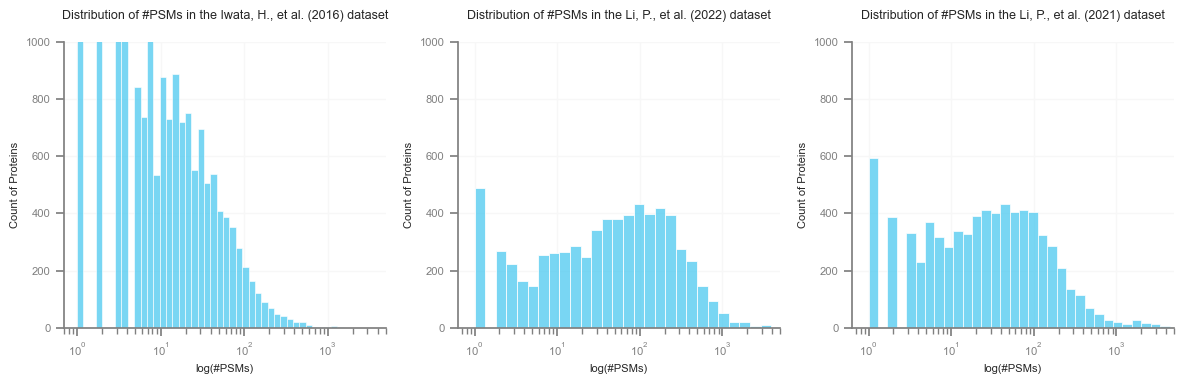

In [9]:
# Distribution of # PSMs for each dataset for exp1, exp2, exp3. 
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(df_2016_iwata["# PSMs"], log_scale=True, ax=ax[0])
sns.histplot(df_2022_pengfei["# PSMs"], log_scale=True, ax=ax[1])
sns.histplot(df_2021_pengfei["# PSMs"], log_scale=True, ax=ax[2])
ax[0].set_title("Distribution of #PSMs in the Iwata, H., et al. (2016) dataset\n")
ax[1].set_title("Distribution of #PSMs in the Li, P., et al. (2022) dataset\n")
ax[2].set_title("Distribution of #PSMs in the Li, P., et al. (2021) dataset\n")
ax[0].set_xlim([0, 5000])
ax[0].set_ylim([0, 1000])
ax[1].set_xlim([0, 5000])
ax[1].set_ylim([0, 1000])
ax[2].set_xlim([0, 5000])
ax[2].set_ylim([0, 1000])
ax[0].set_ylabel("Count of Proteins")
ax[1].set_ylabel("Count of Proteins")
ax[2].set_ylabel("Count of Proteins")
ax[0].set_xlabel("log(#PSMs)")
ax[1].set_xlabel("log(#PSMs)")
ax[2].set_xlabel("log(#PSMs)")
plt.tight_layout()
plt.show()



In [10]:
# check null values
print("Null values in the datasets")
print("  Iwata, H., et al. (2016):", df_2016_iwata.isnull().sum().sum())
print("  Li, P., et al. (2022):", df_2022_pengfei.isnull().sum().sum())
print("  Li, P., et al. (2021):", df_2021_pengfei.isnull().sum().sum())
print("  Huffman, R. G., et al. (2022):", np.isnan(df_huffman_adata.X).sum())


Null values in the datasets
  Iwata, H., et al. (2016): 22357
  Li, P., et al. (2022): 59563
  Li, P., et al. (2021): 106631
  Huffman, R. G., et al. (2022): 0


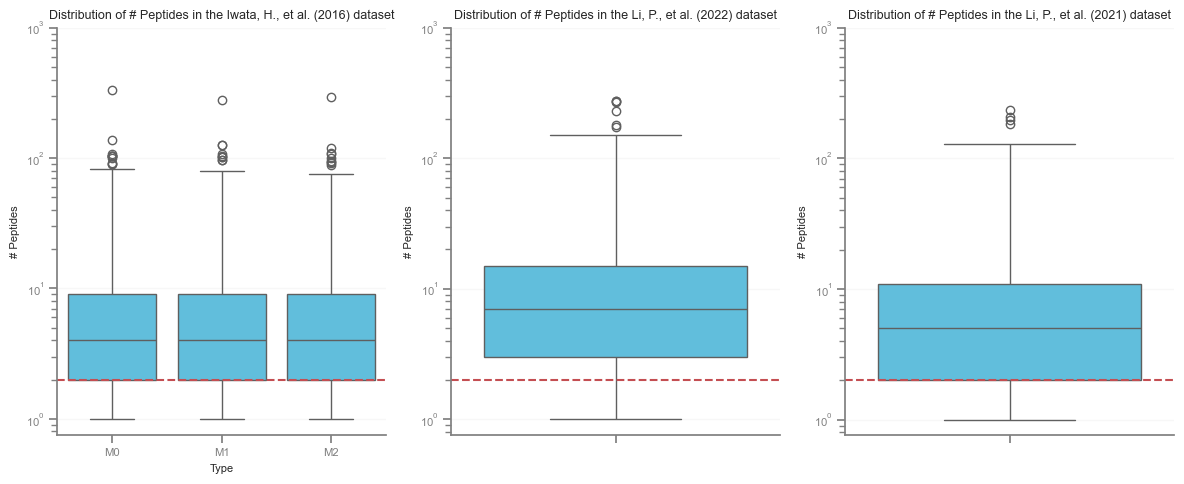

In [11]:
# Boxplot of the # Peptides for each dataset
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
sns.boxplot(data=df_2016_iwata, x="Type", y="# Peptides", ax=ax[0], log_scale=True)
sns.boxplot(data=df_2022_pengfei, y="# Peptides", ax=ax[1], log_scale=True)
sns.boxplot(data=df_2021_pengfei, y="# Peptides", ax=ax[2], log_scale=True)
ax[0].set_title("Distribution of # Peptides in the Iwata, H., et al. (2016) dataset")
ax[1].set_title("Distribution of # Peptides in the Li, P., et al. (2022) dataset")
ax[2].set_title("Distribution of # Peptides in the Li, P., et al. (2021) dataset")

for a in ax:
    a.axhline(y=MIN_NUM_PEPTIDE_THRESHOLD, color='r', linestyle='--')
    a.set_ylim([0, 1000])
    
plt.tight_layout()
plt.show()



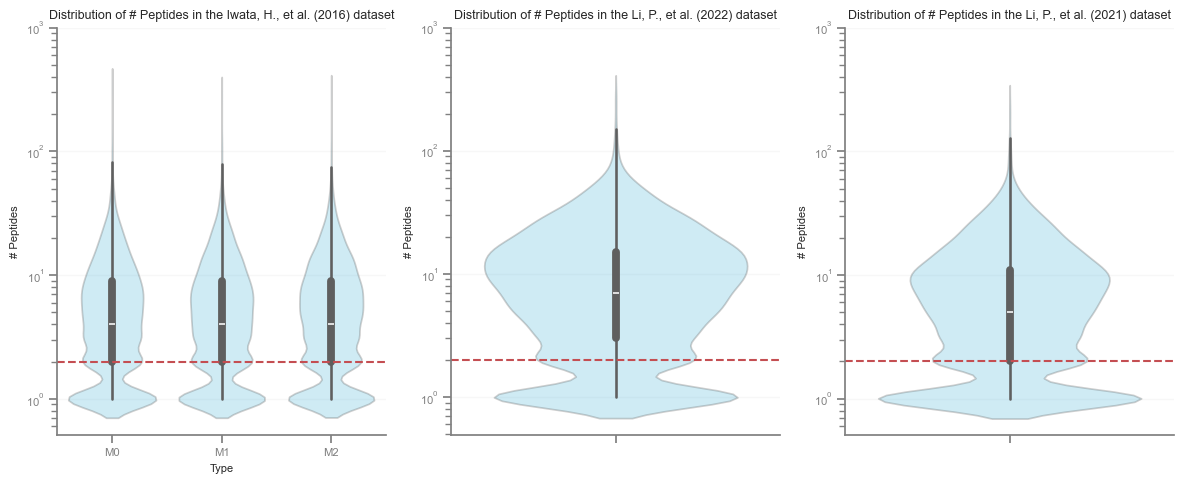

In [12]:
# same with violin plots
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
sns.violinplot(data=df_2016_iwata, x="Type", y="# Peptides", ax=ax[0], log_scale=True, alpha=0.3)
sns.violinplot(data=df_2022_pengfei, y="# Peptides", ax=ax[1], log_scale=True, alpha=0.3)
sns.violinplot(data=df_2021_pengfei, y="# Peptides", ax=ax[2], log_scale=True, alpha=0.3)
ax[0].set_title("Distribution of # Peptides in the Iwata, H., et al. (2016) dataset")
ax[1].set_title("Distribution of # Peptides in the Li, P., et al. (2022) dataset")
ax[2].set_title("Distribution of # Peptides in the Li, P., et al. (2021) dataset")
# Add a horizontal line at the threshold
for a in ax:
    a.axhline(y=MIN_NUM_PEPTIDE_THRESHOLD, color='r', linestyle='--')
    a.set_ylim([0, 1000])

plt.tight_layout()
plt.show()



Figure x. Distribution of Peptides in the three different datasets usign logaritmic scale. The red dashed line denotes a reference threshold across all plots

In [13]:
print(f"Percentage of proteins with less than {MIN_NUM_PEPTIDE_THRESHOLD} peptides:")

pct_iwata = (df_2016_iwata["# Peptides"] < MIN_NUM_PEPTIDE_THRESHOLD).sum() / df_2016_iwata.shape[0] * 100
print(f"  Iwata, H., et al. (2016): {pct_iwata:.2f}%")
pct_pengfei = (df_2022_pengfei["# Peptides"] < MIN_NUM_PEPTIDE_THRESHOLD).sum() / df_2022_pengfei.shape[0] * 100
print(f"  Li, P., et al. (2022): {pct_pengfei:.2f}%")
pct_pengfei = (df_2021_pengfei["# Peptides"] < MIN_NUM_PEPTIDE_THRESHOLD).sum() / df_2021_pengfei.shape[0] * 100
print(f"  Li, P., et al. (2021): {pct_pengfei:.2f}%")

Percentage of proteins with less than 2 peptides:
  Iwata, H., et al. (2016): 20.85%
  Li, P., et al. (2022): 15.42%
  Li, P., et al. (2021): 20.70%


In [14]:
print(df_2016_iwata.describe())
print(df_2022_pengfei.describe())
print(df_2021_pengfei.describe())
print(df_huffman_adata)

              Score      Coverage    # Proteins  # Unique Peptides  \
count  19247.000000  19247.000000  19247.000000       19247.000000   
mean      57.958304     19.276302      4.564919           6.064322   
std      140.107779     16.891390      4.696807           8.228747   
min        0.000000      0.050000      1.000000           0.000000   
25%        5.487738      6.200000      2.000000           2.000000   
50%       18.139427     14.090000      3.000000           4.000000   
75%       56.796837     27.740000      6.000000           8.000000   
max     3747.075588     95.900000    152.000000         327.000000   

         # Peptides        # PSMs  126/126  126/126 Count  \
count  19247.000000  19247.000000  19201.0   19201.000000   
mean       6.859355     22.705720      1.0      17.666892   
std        9.116540     54.949409      0.0      38.584949   
min        1.000000      1.000000      1.0       1.000000   
25%        2.000000      2.000000      1.0       2.000000   
50%

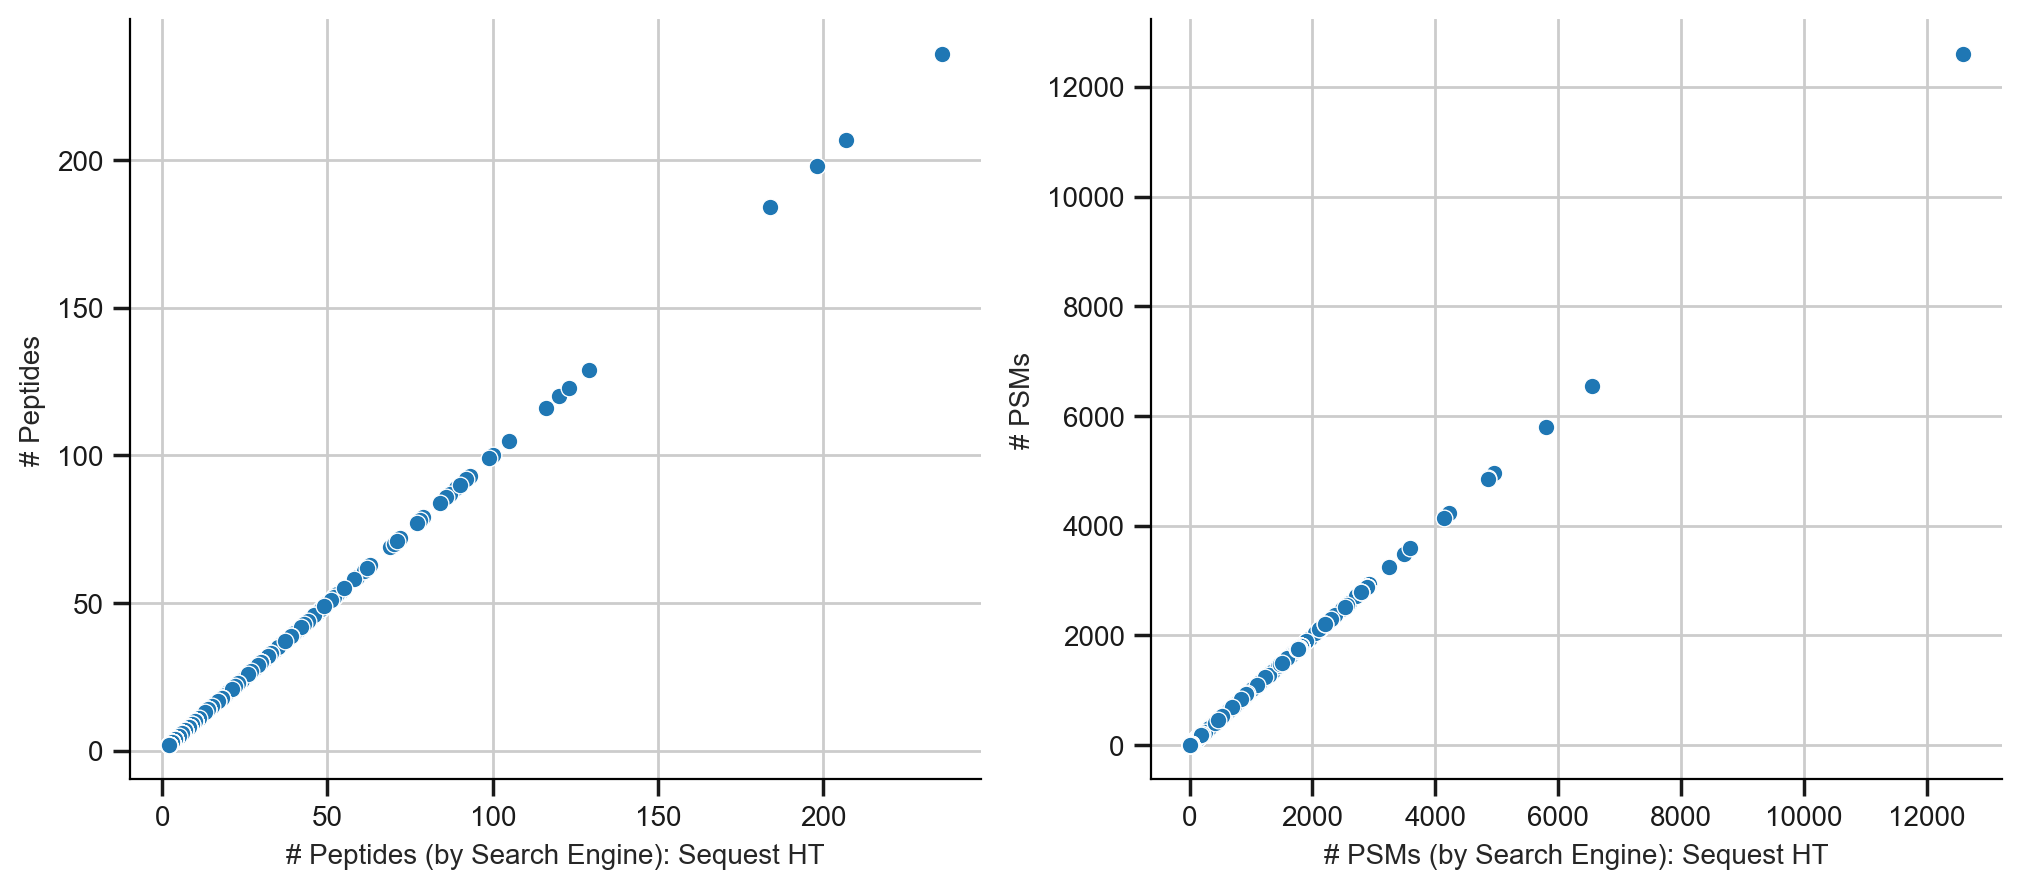

In [78]:
# Correlation plots of similar (duplicate) columns
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=df_2021_pengfei, x="# Peptides (by Search Engine): Sequest HT", y="# Peptides", ax=ax[0])
sns.scatterplot(data=df_2021_pengfei, x="# PSMs (by Search Engine): Sequest HT", y="# PSMs", ax=ax[1])
plt.show()



**Assumption:** The dataset Iwata, H., et al. (2016) has a column named "Score", while the other two bulk datasets have a column named "Score Sequest HT: Sequest HT".
<br>
According to the Proteome Discoverer Manual, I assume that the column "Score" in the Iwata, H., et al. (2016) dataset is equivalent to the Sequest Score in the other datasets.

*protein_score = (sum_of_all_cross-correlation_factors_of_0.8_or_above) + (peptide_charge × peptide_relevance_factor)*<br><br>
**Source**: *Proteome Discoverer Manual v2.2 (page 24)* 

---
### Filtering data

Low quality data must be filtered before the data analysis

Criteria:
* (Iwata 2016, Pengfei 2022 and Pengfei 2021 only):  The number of Peptide Spectrum Matches < 5. It represents the number of times a peptide sequence has been identified in the mass spectra. 
* (Iwata 2016 only): Protein not found in the initial time point.



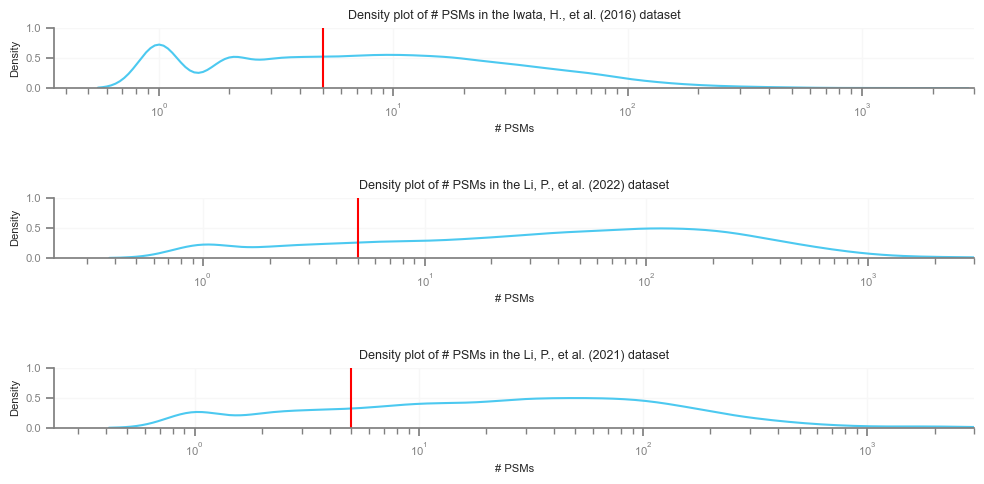

In [15]:
# Grid of density plots for the # PSMs for the first 3 experiments (use log scale)
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
sns.kdeplot(df_2016_iwata["# PSMs"], log_scale=True, ax=ax[0])
sns.kdeplot(df_2022_pengfei["# PSMs"], log_scale=True, ax=ax[1])
sns.kdeplot(df_2021_pengfei["# PSMs"], log_scale=True, ax=ax[2])
ax[0].axvline(5, color='red')
ax[1].axvline(5, color='red')
ax[2].axvline(5, color='red')
ax[0].set_title("Density plot of # PSMs in the Iwata, H., et al. (2016) dataset")
ax[1].set_title("\n\nDensity plot of # PSMs in the Li, P., et al. (2022) dataset")
ax[2].set_title("\n\nDensity plot of # PSMs in the Li, P., et al. (2021) dataset")

for a in ax:
    a.set_xlim([0, 3000])
    a.set_ylim([0, 1])

plt.tight_layout()
plt.show()


Figure x. Distribution of Peptide-Spectrum Matches (PSMs). Comparative analysis of PSM distributions with the defined threshold represented with a red line. It shows the characteristics and quality of the datasets

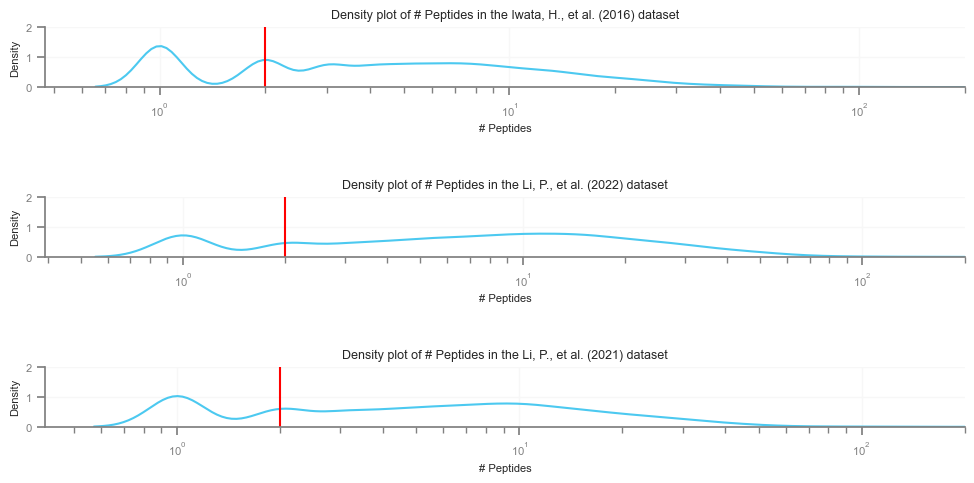

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
sns.kdeplot(df_2016_iwata["# Peptides"], log_scale=True, ax=ax[0])
sns.kdeplot(df_2022_pengfei["# Peptides"], log_scale=True, ax=ax[1])
sns.kdeplot(df_2021_pengfei["# Peptides"], log_scale=True, ax=ax[2])
ax[0].axvline(MIN_NUM_PEPTIDE_THRESHOLD, color='red')
ax[1].axvline(MIN_NUM_PEPTIDE_THRESHOLD, color='red')
ax[2].axvline(MIN_NUM_PEPTIDE_THRESHOLD, color='red')
ax[0].set_title("Density plot of # Peptides in the Iwata, H., et al. (2016) dataset")
ax[1].set_title("\n\nDensity plot of # Peptides in the Li, P., et al. (2022) dataset")
ax[2].set_title("\n\nDensity plot of # Peptides in the Li, P., et al. (2021) dataset")

for a in ax:
    a.set_xlim([0, 200])
    a.set_ylim([0, 2])

plt.tight_layout()
plt.show()


In [17]:
# Experiment 1: 2016 Iwata et al.
# Filter out records with blank values in the column "126/126" (which should contain 1.00)
print("-- Removing proteins from Iwata, H., et al. (2016) dataset with null values in the column ['126/126'] ----------")
print("  Proteins with null values:", df_2016_iwata["126/126"].isnull().sum())
print("  This proteins MUST be removed from the dataset as they should have 1.00")
df_2016_iwata = df_2016_iwata[~df_2016_iwata["126/126"].isnull()]

# Keep proteins that has PSMs >= 5 (ref: https://pmc.ncbi.nlm.nih.gov/articles/PMC9110321/#s3)
print("\n-- Removing proteins that have PSMs < 5 -------------------------------------------------------------------")
print("  Iwata, H., et al. (2016):", df_2016_iwata[df_2016_iwata["# PSMs"] < PSM_THRESHOLD].shape[0], "out of",df_2016_iwata.shape[0], "proteins have been removed")
df_2016_iwata = df_2016_iwata[df_2016_iwata["# PSMs"] >= PSM_THRESHOLD]
print("  Li, P., et al. (2022):", df_2022_pengfei[df_2022_pengfei["# PSMs"] < PSM_THRESHOLD].shape[0], "out of",df_2022_pengfei.shape[0], "proteins have been removed")
df_2022_pengfei = df_2022_pengfei[df_2022_pengfei["# PSMs"] >= PSM_THRESHOLD]
print("  Li, P., et al. (2021):", df_2021_pengfei[df_2021_pengfei["# PSMs"] < PSM_THRESHOLD].shape[0], "out of",df_2021_pengfei.shape[0], "proteins have been removed")
df_2021_pengfei = df_2021_pengfei[df_2021_pengfei["# PSMs"] >= PSM_THRESHOLD]

# Filter by the number of peptides
print("\n-- Removing proteins that have less than 2 peptides --------------------------------------------------------")
print("  Iwata, H., et al. (2016):", df_2016_iwata[df_2016_iwata["# Peptides"] < MIN_NUM_PEPTIDE_THRESHOLD].shape[0], "out of",df_2016_iwata.shape[0], "proteins have been removed")
df_2016_iwata = df_2016_iwata[df_2016_iwata["# Peptides"] >= MIN_NUM_PEPTIDE_THRESHOLD]
print("  Li, P., et al. (2022):", df_2022_pengfei[df_2022_pengfei["# Peptides"] < MIN_NUM_PEPTIDE_THRESHOLD].shape[0], "out of",df_2022_pengfei.shape[0], "proteins have been removed")
df_2022_pengfei = df_2022_pengfei[df_2022_pengfei["# Peptides"] >= MIN_NUM_PEPTIDE_THRESHOLD]
print("  Li, P., et al. (2021):", df_2021_pengfei[df_2021_pengfei["# Peptides"] < MIN_NUM_PEPTIDE_THRESHOLD].shape[0], "out of",df_2021_pengfei.shape[0], "proteins have been removed")
df_2021_pengfei = df_2021_pengfei[df_2021_pengfei["# Peptides"] >= MIN_NUM_PEPTIDE_THRESHOLD]

# Filter by Score
print("\n-- Removing proteins with a score of > 1.5 ------------------------------------------------------------------")
print("  Iwata, H., et al. (2016):", df_2016_iwata[df_2016_iwata["Score"] < SCORE_THRESHOLD].shape[0], "out of",df_2016_iwata.shape[0], "proteins have been removed")
df_2016_iwata = df_2016_iwata[df_2016_iwata["Score"] >= SCORE_THRESHOLD]
print("  Li, P., et al. (2022):", df_2022_pengfei[df_2022_pengfei["Score Sequest HT: Sequest HT"] < SCORE_THRESHOLD].shape[0], "out of",df_2022_pengfei.shape[0], "proteins have been removed")
df_2022_pengfei = df_2022_pengfei[df_2022_pengfei["Score Sequest HT: Sequest HT"] >= SCORE_THRESHOLD]
print("  Li, P., et al. (2021):", df_2021_pengfei[df_2021_pengfei["Score Sequest HT: Sequest HT"] < SCORE_THRESHOLD].shape[0], "out of",df_2021_pengfei.shape[0], "proteins have been removed")
df_2021_pengfei = df_2021_pengfei[df_2021_pengfei["Score Sequest HT: Sequest HT"] >= SCORE_THRESHOLD]


# Print the number of proteins after filtering
print("\n-- Number of proteins after filtering -----------------------------------------------------------------------")
print("  Iwata, H., et al. (2016):", df_2016_iwata.index.nunique())
print("  Li, P., et al. (2022):", df_2022_pengfei.index.nunique())
print("  Li, P., et al. (2021):", df_2021_pengfei.index.nunique())


-- Removing proteins from Iwata, H., et al. (2016) dataset with null values in the column ['126/126'] ----------
  Proteins with null values: 46
  This proteins MUST be removed from the dataset as they should have 1.00

-- Removing proteins that have PSMs < 5 -------------------------------------------------------------------
  Iwata, H., et al. (2016): 7379 out of 19201 proteins have been removed
  Li, P., et al. (2022): 1146 out of 6616 proteins have been removed
  Li, P., et al. (2021): 1541 out of 7349 proteins have been removed

-- Removing proteins that have less than 2 peptides --------------------------------------------------------
  Iwata, H., et al. (2016): 108 out of 11822 proteins have been removed
  Li, P., et al. (2022): 213 out of 5470 proteins have been removed
  Li, P., et al. (2021): 369 out of 5808 proteins have been removed

-- Removing proteins with a score of > 1.5 ------------------------------------------------------------------
  Iwata, H., et al. (2016): 2 ou

---
### Translating protein accessions to Gene Names

UniProtKB REST API examples for a valid ID:
* [UniProtKB call using "P04075"](https://rest.uniprot.org/uniprotkb/P04075)
<br><br>

UniProtKB REST API examples for an old ID:
* [UniProtKB call using "F5H6Z3"](https://rest.uniprot.org/uniprotkb/F5H6Z3.json)
* [Unisave call using "F5H6Z3"](https://rest.uniprot.org/unisave/F5H6Z3?format=txt)
* [Uniparc call using UPI format "UPI00020656CD"](https://rest.uniprot.org/uniparc/UPI00020656CD)



In [18]:
if TRANSLATE_PROTEIN_ID:
    print("Translating protein IDs to gene names (Iwata, H., et al. (2016))... ")
    gene_names = uniprot.batch_translate_protein_ids(df_2016_iwata.index)
    df_2016_iwata['Gene'] = gene_names
    df_2016_iwata_bkup = gene_names.copy()

    print("Translating protein IDs to gene names (Li, P., et al. (2022))... ")
    gene_names = uniprot.batch_translate_protein_ids(df_2022_pengfei.index)
    df_2022_pengfei['Gene'] = gene_names
    df_2022_pengfei_bkup = gene_names.copy()

    print("Translating protein IDs to gene names (Li, P., et al. (2021))... ")
    gene_names = uniprot.batch_translate_protein_ids(df_2021_pengfei.index)
    df_2021_pengfei['Gene'] = gene_names
    df_2021_pengfei_bkup = gene_names.copy()

    print("Translating protein IDs to gene names (Huffman, R. G., et al. (2022))... ")
    gene_names = uniprot.batch_translate_protein_ids(df_huffman_adata.var.index)
    df_huffman_adata.var['Gene'] = gene_names
    df_huffman_adata_bkup = gene_names.copy()
else:
    # Restore gene names
    df_2016_iwata['Gene'] = df_2016_iwata_bkup
    df_2022_pengfei['Gene'] = df_2022_pengfei_bkup
    df_2021_pengfei['Gene'] = df_2021_pengfei_bkup
    df_huffman_adata.var['Gene'] = df_huffman_adata_bkup


Translating protein IDs to gene names (Iwata, H., et al. (2016))... 
No data found in Uniprot for protein ID F5H6Z3. Returning 'None (F5H6Z3).
Gene name found in Unisave: CAP1.
No data found in Uniprot for protein ID F5H0N0. Returning 'None (F5H0N0).
Gene name found in Unisave: ACTG1.
No data found in Uniprot for protein ID B4E1H9. Returning 'None (B4E1H9).
Gene name found in Unisave: PGK1.
No data found in Uniprot for protein ID B7Z4V2. Returning 'None (B7Z4V2).
Gene name found in Unisave: DNAKA.
No data found in Uniprot for protein ID F5H8M4. Returning 'None (F5H8M4).
Gene name found in Unisave: GSN.
No data found in Uniprot for protein ID Q5T8M8. Returning 'None (Q5T8M8).
Gene name found in Unisave: ACTA1.
No data found in Uniprot for protein ID B3KQT9. Returning 'None (B3KQT9).
Gene name found in Unisave: PDIA3.
No data found in Uniprot for protein ID B3KX72. Returning 'None (B3KX72).
Gene name found in Unisave: HNRNPU.
No data found in Uniprot for protein ID F8VPV9. Returning 'Non

In [19]:
# Restore gene names (if needed). 
# This is useful when we want to re-run the notebook without re-translating the protein IDs, which is time-consuming
#df_2016_iwata['Gene'] = df_2016_iwata_bkup
#df_2022_pengfei['Gene'] = df_2022_pengfei_bkup
#df_2021_pengfei['Gene'] = df_2021_pengfei_bkup
#df_huffman_adata.var['Gene'] = df_huffman_adata_bkup

In [59]:
# print top genes for df_2016_iwata
print(f"\n-- Top {TOP_GENES} genes in Iwata, H., et al. (2016) dataset --------------------------------------------------------------")
print(df_2016_iwata["Gene"].value_counts().head(TOP_GENES))

# print top genes for df_2022_pengfei
print(f"\n-- Top {TOP_GENES} genes in Li, P., et al. (2022) dataset -------------------------------------------------------------")
print(df_2022_pengfei["Gene"].value_counts().head(TOP_GENES))

# print top genes for df_2021_pengfei
print(f"\n-- Top {TOP_GENES} genes in Li, P., et al. (2021) dataset -------------------------------------------------------------")
print(df_2021_pengfei["Gene"].value_counts().head(TOP_GENES))

# print top genes for df_huffman_adata sorted by most counts
print(f"\n-- Top {TOP_GENES} genes in Huffman, R. G., et al. (2022) dataset -------------------------------------------------------------")
print(df_huffman_adata.var["Gene"].value_counts().head(TOP_GENES))


-- Top 10 genes in Iwata, H., et al. (2016) dataset --------------------------------------------------------------
Gene
EIF4G2      9
PPP1R12A    7
PPP1CB      7
TMPO        7
MBNL1       6
USP15       6
SPAG9       6
AAK1        6
LYPLAL1     6
PEX19       6
Name: count, dtype: int64

-- Top 10 genes in Li, P., et al. (2022) dataset -------------------------------------------------------------
Gene
HLA-C       2
HLA-B       2
AAK1        2
HLA-A       2
HLA-DRB1    2
TMPO        2
DYNC1H1     1
F13A1       1
MYDGF       1
INTS5       1
Name: count, dtype: int64

-- Top 10 genes in Li, P., et al. (2021) dataset -------------------------------------------------------------
Gene
HLA-B       35
HLA-A       21
HLA-C       14
HLA-DRB1    13
NACA         2
GNAS         2
SIRPB1       2
RABGAP1L     2
TMPO         2
CUX1         2
Name: count, dtype: int64

-- Top 10 genes in Huffman, R. G., et al. (2022) dataset -------------------------------------------------------------
Gene
AARS1     1


Only few of the most present Genes can be found in more than one dataset. And even in the case of being in more than one datasets, the number of appearances is very different.

In [21]:
# Upper case the gene names for Huffman, R. G., et al. (2022)
df_huffman_adata.var["Gene"] = df_huffman_adata.var["Gene"].str.upper()

In [22]:
# Intersection of top x

print("\n-- Intersection of top genes (by count(gene)) in each dataset ----------------------------------------------------------------") 
top_genes_iwata = set(df_2016_iwata["Gene"].value_counts().head(TOP_GENES).index)
top_genes_pengfei = set(df_2022_pengfei["Gene"].value_counts().head(TOP_GENES).index)
top_genes_pengfei2 = set(df_2021_pengfei["Gene"].value_counts().head(TOP_GENES).index)
top_genes_huffman = set(df_huffman_adata.var["Gene"].value_counts().head(TOP_GENES).index)

print(" The genes found in the TOP 10 of all 4 datasets are:", top_genes_iwata & top_genes_pengfei & top_genes_pengfei2 & top_genes_huffman)
print(" The genes found in the TOP 10 of the 3 bulk datasets are:", top_genes_iwata & top_genes_pengfei & top_genes_pengfei2)
# Single-cell data was excluded due to all the genes were found only once.


-- Intersection of top 10 genes in each dataset ----------------------------------------------------------------
 The genes found in the TOP 10 of all 4 datasets are: set()
 The genes found in the TOP 10 of the 3 bulk datasets are: {'TMPO', 'AAK1'}


In [23]:
# Save the data into 4 files
#df_2016_iwata.to_csv("./data/processed/2016_iwata_genes.csv")
#df_2022_pengfei.to_csv("./data/processed/2022_pengfei_genes.csv")
#df_2021_pengfei.to_csv("./data/processed/2021_pengfei_genes.csv")
#df_huffman_adata.write("./data/processed/2022_huffman_genes.h5ad")

In [24]:
# Remove null values 
print("\nRemoving Null values for Gene Name")
print("  Iwata, H., et al. (2016):", df_2016_iwata["Gene"].isnull().sum().sum())
print("  Li, P., et al. (2022):", df_2022_pengfei["Gene"].isnull().sum().sum())
print("  Li, P., et al. (2021):", df_2021_pengfei["Gene"].isnull().sum().sum())
print("  Huffman, R. G., et al. (2022):", df_huffman_adata.var[df_huffman_adata.var["Gene"].isnull()].shape[0])

df_2016_iwata = df_2016_iwata[~df_2016_iwata["Gene"].isnull()]
df_2022_pengfei = df_2022_pengfei[~df_2022_pengfei["Gene"].isnull()]
df_2021_pengfei = df_2021_pengfei[~df_2021_pengfei["Gene"].isnull()]
df_huffman_adata = df_huffman_adata[:, ~df_huffman_adata.var["Gene"].isnull()]



Removing Null values for Gene Name
  Iwata, H., et al. (2016): 53
  Li, P., et al. (2022): 1
  Li, P., et al. (2021): 1
  Huffman, R. G., et al. (2022): 18


In [53]:
# Filter out the genes with gene name starting by 'None ('
print("\n-- Removing proteins without Gene Name ---------------------------------------------------------------------")
print("  Iwata, H., et al. (2016):", df_2016_iwata[df_2016_iwata["Gene"].str.startswith("None (")].shape[0], "out of",df_2016_iwata.shape[0], "proteins have been removed")
df_2016_iwata = df_2016_iwata[~df_2016_iwata["Gene"].str.startswith("None (")]
print("  Li, P., et al. (2022):", df_2022_pengfei[df_2022_pengfei["Gene"].str.startswith("None (")].shape[0], "out of",df_2022_pengfei.shape[0], "proteins have been removed")
df_2022_pengfei = df_2022_pengfei[~df_2022_pengfei["Gene"].str.startswith("None (")]
print("  Li, P., et al. (2021):", df_2021_pengfei[df_2021_pengfei["Gene"].str.startswith("None (")].shape[0], "out of",df_2021_pengfei.shape[0], "proteins have been removed")
df_2021_pengfei = df_2021_pengfei[~df_2021_pengfei["Gene"].str.startswith("None (")]
print("  Huffman, R. G., et al. (2022):", df_huffman_adata.var[df_huffman_adata.var["Gene"].str.startswith("None (")].shape[0], "out of",df_huffman_adata.shape[1], "proteins have been removed")
df_huffman_adata = df_huffman_adata[:, ~df_huffman_adata.var["Gene"].str.startswith("None (")]


print("\n-- Number of proteins after filtering -----------------------------------------------------------------------")
print("  Iwata, H., et al. (2016):", df_2016_iwata["Gene"].nunique())
print("  Li, P., et al. (2022):", df_2022_pengfei["Gene"].nunique())
print("  Li, P., et al. (2021):", df_2021_pengfei["Gene"].nunique())
print("  Huffman, R. G., et al. (2022):", df_huffman_adata.var["Gene"].nunique())


-- Removing proteins without Gene Name ---------------------------------------------------------------------
  Iwata, H., et al. (2016): 0 out of 11659 proteins have been removed
  Li, P., et al. (2022): 0 out of 4951 proteins have been removed
  Li, P., et al. (2021): 0 out of 5404 proteins have been removed
  Huffman, R. G., et al. (2022): 0 out of 1105 proteins have been removed

-- Number of proteins after filtering -----------------------------------------------------------------------
  Iwata, H., et al. (2016): 4454
  Li, P., et al. (2022): 4945
  Li, P., et al. (2021): 5318
  Huffman, R. G., et al. (2022): 1105


---
### 1. Quantitative proteomic profiling of M0, M1 and M2

**1.1 Total number of identified proteins per Dataset**

Total number of proteins identified in each dataset (includes proteins found in M0, M1 and M2):
Iwata, H., et al. (2016) -> 4454 unique proteins
Li, P., et al. (2022) -> 4945 unique proteins
Li, P., et al. (2021) -> 5318 unique proteins
Huffman, R. G., et al. (2022) -> 1105 unique proteins


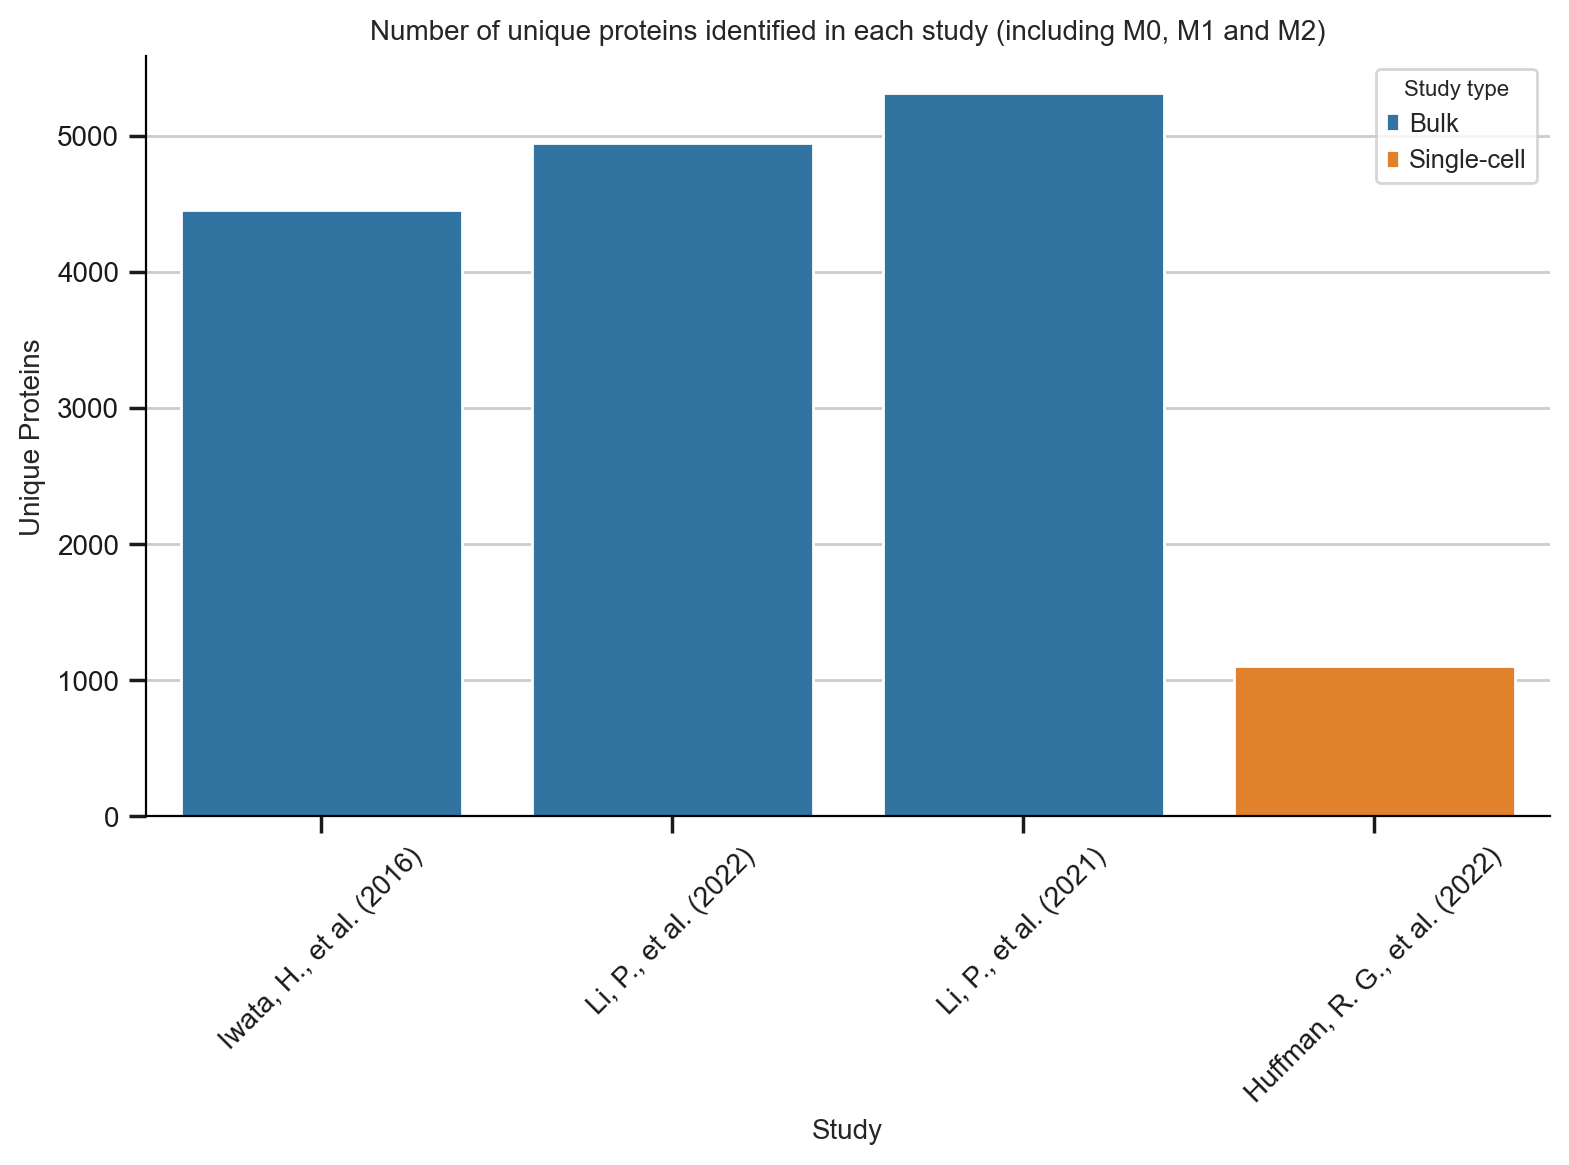

In [52]:
df_studies = pd.DataFrame({
    "Study": ["Iwata, H., et al. (2016)", "Li, P., et al. (2022)", "Li, P., et al. (2021)", "Huffman, R. G., et al. (2022)"],
    "Unique Proteins": [len(df_2016_iwata["Gene"].unique()), len(df_2022_pengfei["Gene"].unique()), len(df_2021_pengfei["Gene"].unique()), len(df_huffman_adata.var["Gene"].unique())],
    "Study type": ["Bulk", "Bulk", "Bulk", "Single-cell"]
})

print("Total number of proteins identified in each dataset (includes proteins found in M0, M1 and M2):")
for i in range(len(df_studies)):
    print(df_studies["Study"][i], "->", df_studies["Unique Proteins"][i], "unique proteins")

plt.figure(figsize=(9, 5))
sns.barplot(data=df_studies, x="Study", y="Unique Proteins", hue="Study type")
plt.xticks(rotation=45)
plt.title("Number of unique proteins identified in each study (including M0, M1 and M2)")
plt.show()


Note that 2022 Huffman et al. do not contain data for M2 phenotype.

**Comparing the Genes instead of Proteins**

In [27]:
# Number of genes found in each dataset
df_studies = pd.DataFrame({
    "Study": ["Iwata, H., et al. (2016)", "Li, P., et al. (2022)", "Li, P., et al. (2021)", "Huffman, R. G., et al. (2022)"],
    "Unique Genes": [len(df_2016_iwata["Gene"].unique()), len(df_2022_pengfei["Gene"].unique()), len(df_2021_pengfei["Gene"].unique()), len(df_huffman_adata.var["Gene"].unique())],
    "Study type": ["Bulk", "Bulk", "Bulk", "Single-cell"]
})

print("Total number of genes identified in each dataset (includes proteins found in M0, M1 and M2):")
for i in range(len(df_studies)):
    print(df_studies["Study"][i], "->", df_studies["Unique Genes"][i], "unique genes")


Total number of genes identified in each dataset (includes proteins found in M0, M1 and M2):
Iwata, H., et al. (2016) -> 4454 unique genes
Li, P., et al. (2022) -> 4945 unique genes
Li, P., et al. (2021) -> 5318 unique genes
Huffman, R. G., et al. (2022) -> 1105 unique genes


**1.2 Total number of identified proteins per Dataset and cell type**

In [28]:
# Number of proteins found in each cell type (M0, M1 and M2)
print("Number of proteins found in each cell type:")
print ("\nIwata, H., et al. (2016)")
for cell_type in df_2016_iwata["Type"].unique():
    print(" ", cell_type, ":", len(df_2016_iwata[df_2016_iwata["Type"] == cell_type].index.unique()))

print ("\nLi, P., et al. (2022)")
print("  M0: ", len(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M0"] > 0].index.unique()))
print("  M1: ", len(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M1"] > 0].index.unique()))
print("  M2: ", len(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2"] > 0].index.unique()))

print ("\nLi, P., et al. (2021)")
print("  M0: ", len(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M0"] > 0].index.unique()))
print("  M1: ", len(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M1"] > 0].index.unique()))
print("  M2: ", len(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M2"] > 0].index.unique()))

print ("\nHuffman, R. G., et al. (2022) - Not available due to data limitations")
print("  M0: N/A")
print("  M1: N/A")
print("  M2: N/A")



Number of proteins found in each cell type:

Iwata, H., et al. (2016)
  M0 : 3819
  M1 : 3782
  M2 : 4058

Li, P., et al. (2022)
  M0:  4729
  M1:  4667
  M2:  4809

Li, P., et al. (2021)
  M0:  5025
  M1:  4970
  M2:  4921

Huffman, R. G., et al. (2022) - Not available due to data limitations
  M0: N/A
  M1: N/A
  M2: N/A


**1.3 Quantifiable proteins among the different cell types**

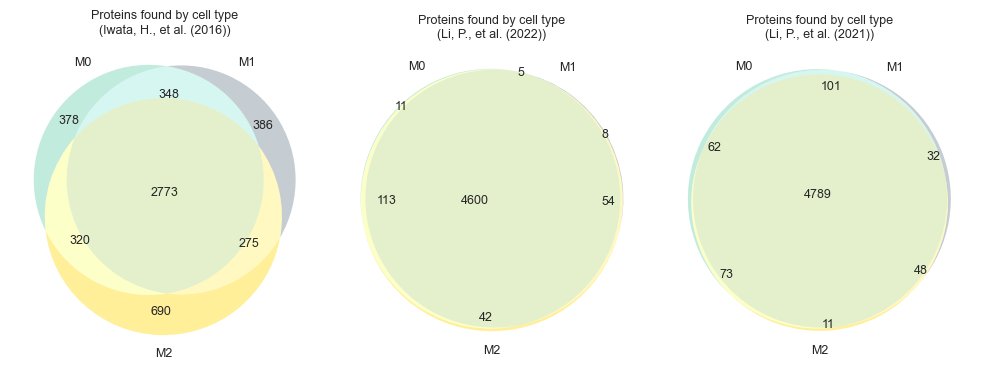

In [29]:
from matplotlib_venn import venn3

# Create the figure with subplots
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

# Venn diagram for the first experiment
exp1_proteinsM0 = set(df_2016_iwata[df_2016_iwata["Type"] == "M0"].index)
exp1_proteinsM1 = set(df_2016_iwata[df_2016_iwata["Type"] == "M1"].index)
exp1_proteinsM2 = set(df_2016_iwata[df_2016_iwata["Type"] == "M2"].index)
venn1 = venn3([exp1_proteinsM0, exp1_proteinsM1, exp1_proteinsM2], 
              set_labels=('M0', 'M1', 'M2'), 
              set_colors=('mediumaquamarine', 'slategrey', 'gold'), 
              ax=ax[0])
ax[0].set_title("Proteins found by cell type\n(Iwata, H., et al. (2016))")

# Venn diagram for the second experiment
exp2_proteinsM0 = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M0"] > 0].index)
exp2_proteinsM1 = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M1"] > 0].index)
exp2_proteinsM2 = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2"] > 0].index)
venn2 = venn3([exp2_proteinsM0, exp2_proteinsM1, exp2_proteinsM2], 
              set_labels=('M0', 'M1', 'M2'), 
              set_colors=('mediumaquamarine', 'slategrey', 'gold'), 
              ax=ax[1])
ax[1].set_title("Proteins found by cell type\n(Li, P., et al. (2022))")

# Venn diagram for the third experiment
exp3_proteinsM0 = set(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M0"] > 0].index)
exp3_proteinsM1 = set(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M1"] > 0].index)
exp3_proteinsM2 = set(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M2"] > 0].index)
venn3 = venn3([exp3_proteinsM0, exp3_proteinsM1, exp3_proteinsM2], 
              set_labels=('M0', 'M1', 'M2'), 
              set_colors=('mediumaquamarine', 'slategrey', 'gold'), 
              ax=ax[2])
ax[2].set_title("Proteins found by cell type\n(Li, P., et al. (2021))")


# Set the font size for the set labels and subset labels for all diagrams
for venn in [venn1, venn2, venn3]:
    for label in venn.set_labels:
        if label is not None:
            label.set_fontsize(9)

    for label in venn.subset_labels:
        if label is not None:
            label.set_fontsize(9)

plt.tight_layout()
plt.show()


*Note that some of the identified proteins might have a very low abundance. These diagrams consider all proteins found regardless of the abundance. 
<br>It also includes proteins found in just some of the samples of a specific cell type.*

<br>
<u>Due to limitations on the data available for Huffman et al. 2021, it is not possible to plot its Venn diagram</u>

**1.4 Proteins found in ALL datasets (excluding those without this information), grouped by cell type**<br><br>

First, considering only bulk data.

Number of common proteins found in M0: 1930
Number of common proteins found in M1: 1912
Number of common proteins found in M2: 2025


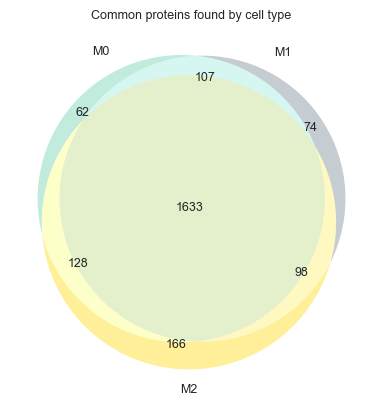

In [30]:
from matplotlib_venn import venn3

commonM0_proteins = exp1_proteinsM0.intersection(exp2_proteinsM0).intersection(exp3_proteinsM0)
commonM1_proteins = exp1_proteinsM1.intersection(exp2_proteinsM1).intersection(exp3_proteinsM1)
commonM2_proteins = exp1_proteinsM2.intersection(exp2_proteinsM2).intersection(exp3_proteinsM2)

print("Number of common proteins found in M0:", len(commonM0_proteins))
print("Number of common proteins found in M1:", len(commonM1_proteins))
print("Number of common proteins found in M2:", len(commonM2_proteins))


# Venn diagram for the common proteins
venn = venn3([commonM0_proteins, commonM1_proteins, commonM2_proteins], set_labels=('M0', 'M1', 'M2'), set_colors=('mediumaquamarine', 'slategrey', 'gold'))
plt.title("Common proteins found by cell type")

for label in venn.set_labels:
    if label is not None:
        label.set_fontsize(9)

for label in venn.subset_labels:
    if label is not None:
        label.set_fontsize(9)
plt.show()


Now, data from single-cell is also included.

In [31]:
exp4_proteins = set(df_huffman_adata.var.index)

# As it is not possible to know the proteins found in each cell type for the experiment 5, a conservative approach is taken so that no protein is excluded
huff_commonM0_proteins = exp1_proteinsM0.intersection(exp2_proteinsM0).intersection(exp3_proteinsM0).intersection(exp4_proteins)
huff_commonM1_proteins = exp1_proteinsM1.intersection(exp2_proteinsM1).intersection(exp3_proteinsM1).intersection(exp4_proteins)

# Print the number of common proteins
print("Number of common proteins found in M0:", len(huff_commonM0_proteins))
print("Number of common proteins found in M1:", len(huff_commonM1_proteins))

Number of common proteins found in M0: 0
Number of common proteins found in M1: 0


By intersecting the proteins identified in the single cell experiment (Huffman et al. 2022), **there is no coincidence** with any protein, neither in M0 nor in M1. 
Note that single-cell data do not contain M2 cell types.

The same exercise follows, but now **using the gene name instead of the protein ID**.

In [115]:
common_genes = set(df_2016_iwata["Gene"]).intersection(set(df_2022_pengfei["Gene"])).intersection(set(df_2021_pengfei["Gene"])).intersection(set(df_huffman_adata.var["Gene"]))
print("Number of common genes found in all datasets:", len(common_genes))

Number of common genes found in all datasets: 936


As the result of intersecting the gene names, **936 genes** have been identified as common in the 4 datasets

Now gene names are used to analyse the distribution of proteins present in all the datasets by cell types

In [110]:
exp1_genesM0 = df_2016_iwata[df_2016_iwata["Type"] == "M0"]["Gene"]
exp1_genesM1 = df_2016_iwata[df_2016_iwata["Type"] == "M1"]["Gene"]
exp1_genesM2 = df_2016_iwata[df_2016_iwata["Type"] == "M2"]["Gene"]

exp2_genesM0 = df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M0"] > 0]["Gene"]
exp2_genesM1 = df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M1"] > 0]["Gene"]
exp2_genesM2 = df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2"] > 0]["Gene"]

exp3_genesM0 = df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M0"] > 0]["Gene"]
exp3_genesM1 = df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M1"] > 0]["Gene"]
exp3_genesM2 = df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M2"] > 0]["Gene"]

exp4_genes = df_huffman_adata.var["Gene"] 

Number of common genes found in M0: 914
Number of common genes found in M1: 914
Note that M2 genes are not considered as they are not available for the Huffman, R. G., et al. (2022) dataset


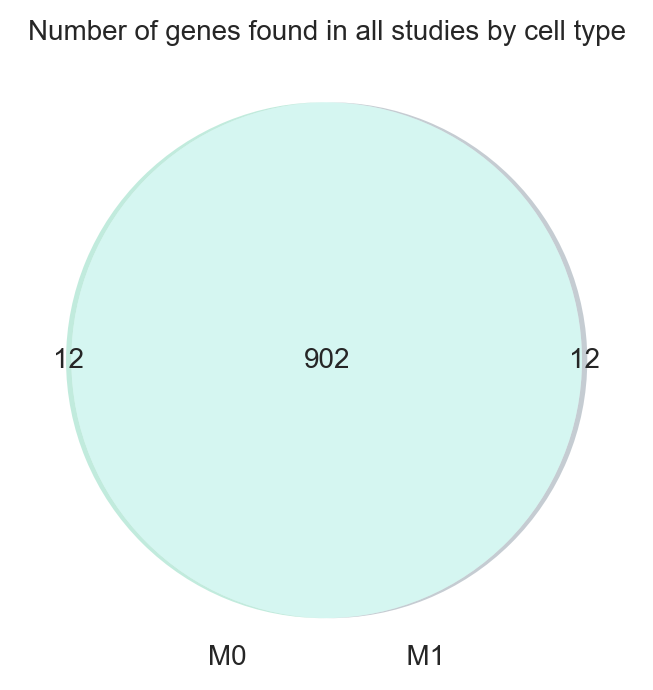

In [113]:
from matplotlib_venn import venn2

commonM0_genes = set(exp1_genesM0).intersection(set(exp2_genesM0)).intersection(set(exp3_genesM0)).intersection(set(exp4_genes))
commonM1_genes = set(exp1_genesM1).intersection(set(exp2_genesM1)).intersection(set(exp3_genesM1)).intersection(set(exp4_genes))

print("Number of common genes found in M0:", len(commonM0_genes))
print("Number of common genes found in M1:", len(commonM1_genes))
print("Note that M2 genes are not considered as they are not available for the Huffman, R. G., et al. (2022) dataset")

# Venn diagram for the common genes
venn = venn2([commonM0_genes, commonM1_genes], set_labels=('M0          ', '          M1'), set_colors=('mediumaquamarine', 'slategrey'))
plt.title("Number of genes found in all studies by cell type")

for label in venn.set_labels:
    if label is not None:
        label.set_fontsize(10)

for label in venn.subset_labels:
    if label is not None:
        label.set_fontsize(10)
plt.show()


As can be observed, there is a significant overlap in the genes expresssed across the four datasets.<br>
Only few genes are exclusively expresed in each of the two groups.<br>
This highlights the extensive commonality in protein expression between the different cell types.

**1.5 Comparing genes found in Bulk vs SC experiments**

The objective is now to compare the proteins identified in all bulk datasets with those found in all single-cell experiments.

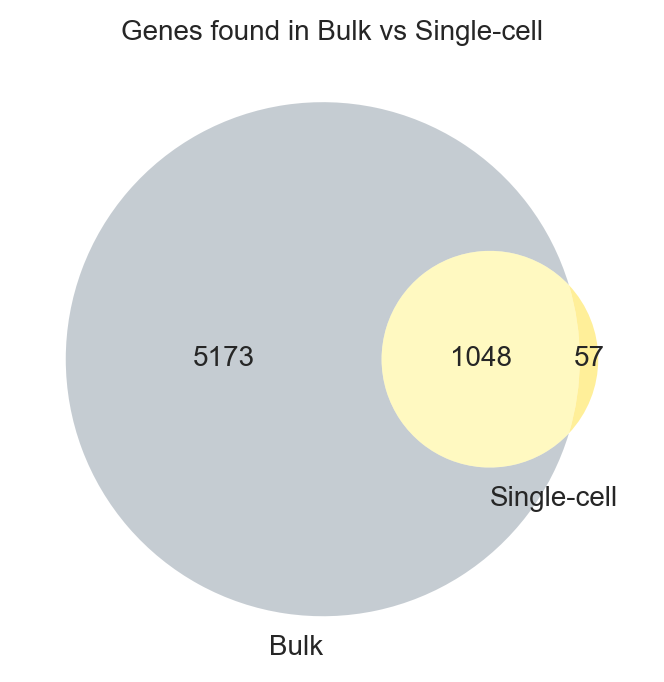

In [186]:
from matplotlib_venn import venn2

df_bulk = pd.concat([df_2016_iwata, df_2022_pengfei, df_2021_pengfei])
df_bulk_genes = df_bulk["Gene"].unique()
df_sc = df_huffman_adata.var["Gene"].unique()

df_bulk_genes = [x for x in df_bulk_genes if str(x) != 'nan']
df_sc = [x for x in df_sc if str(x) != 'nan']

venn = venn2([set(df_bulk_genes), set(df_sc)], set_labels=('Bulk', 'Single-cell'), set_colors=('slategrey', 'gold'))
plt.title("Genes found in Bulk vs Single-cell")


for label in venn.set_labels:
    if label is not None:
        label.set_fontsize(10)

for label in venn.subset_labels:
    if label is not None:
        label.set_fontsize(10)

plt.show()

In [187]:
df_2016_iwata2 = df_2016_iwata.copy()
# Rename the column "Score" to "Score Sequest HT: Sequest HT"
df_2016_iwata2 = df_2016_iwata2.rename(columns={"Score": "Score Sequest HT: Sequest HT"})

# Merge df_2016_iwata, df_2022_pengfei and df_2021_pengfei
df_bulk = pd.concat([df_2016_iwata2, df_2022_pengfei, df_2021_pengfei])
df_bulk

# pritn unique accessions (index) for the bulk data
print("Unique accessions for the bulk data:", df_bulk.index.nunique())
print("Unique gene names for the bulk data:", df_bulk["Gene"].nunique())


Unique accessions for the bulk data: 8434
Unique gene names for the bulk data: 6221


As observed in the previous diagram, most proteins identified in single-cell experiments are also present in bulk samples. However, some proteins are exclusively detected in either bulk or single-cell experiments. Here are some reasons for these discrepancies:<br>
* **Sensitivity:** Bulk proteomics often offers higher sensitivity, enabling the identification of low-abundance proteins that single-cell proteomics (SCP) might miss due to the smaller sample size. However, SCP provides higher resolution, allowing the detection of rare proteins.

* **Number of cells included in experiments:** Bulk experiments analyze a large number of cells together, while SCP examines individual cells. This difference in population size can lead to variations in the detected proteins.

* **Heterogeneity:** SCP can identify proteins that are present only in specific cells within a population. In contrast, bulk experiments average the signal from many cells, potentially masking these proteins.

* **Post-Translational Modifications (PTMs):** SCP can capture PTMs that may be missed in bulk experiments, as these modifications might not be uniformly distributed across the entire cell population.

* **Technical variability:** The field of proteomics is rapidly evolving, with continuous improvements in methods and technologies. Variations in sample preparation and processing can significantly impact the final results, contributing to differences in protein identification between bulk and single-cell experiments.

The proteins found in single-cell datasets only:

In [188]:
print("Genes found in single-cells only:", len(set(df_sc) - set(df_bulk_genes)))

only_sc = set(df_sc) - set(df_bulk_genes)
for gene in only_sc:
    print(gene)


Genes found in single-cells only: 57
TFE3
ADGRE1
AKR1B7
LDLRAP1
XDH
LGMN
DHRS1
ACAA1A
GDA
MRC1
WASHC2
FCGR1
ATP5IF1
HACD2
OVGP1
PARP3
HBB-B1
G6PDX
RBPJL
H2BC7
IFI205A
MTCO2
MPEG1
EEF1B
EIF3J1
LILRB4A
ANXA3
EIF1A
CHN1
CHIL3
CNPY4
C3AR1
FTL1
IFI204
C2CD3
TGTP2
TUBB5
IRGM1
PCP4L1
SAA3
CD48
NIPSNAP3B
UGT1A7
H2-D1
MNDAL
MUG1
H2-K1
GVIN1
ADSS1
LYZ2
HBA
ALDH3B2
C1QB
ACADL
IAP
ZBP1
NOS2


In [189]:
# Dictionaries with the protein IDs and gene names (for single-cell data)
sc_gene_dict = dict(zip(df_huffman_adata.var["Gene"], df_huffman_adata.var.index))
sc_prot_dict = dict(zip(df_huffman_adata.var.index, df_huffman_adata.var["Gene"]))

only_sc_genes = {k: sc_gene_dict[k] for k in only_sc}

### 2. Up/Down-represented Proteins

**2.1 Bulk datasets**<br><br>
**2.1.1 PCA**
<br><br>
PCA reduces the dimensionality of data, allowing visualization of differences between groups of cells (M0 vs M1). It highlights which genes contribute most to these differences, identifying key biological drivers.

LI P - Abundance Ratio: (M1) / (M0)<br>
LI P - Abundance Ratio: (M2) / (M0)<br>
LI P - Abundance Ratio: (M2) / (M1)<br>
Iwata - Computed as (Mx[130/126] / Mx[130/126]) <br>

In [190]:
df_bulk["Abundance Ratio: (M1) / (M0)"] = df_bulk["Abundance Ratio: (M1) / (M0)"].fillna(df_bulk["Abundances (Grouped): M1"] / df_bulk["Abundances (Grouped): M0"])
df_bulk["Abundance Ratio: (M2) / (M0)"] = df_bulk["Abundance Ratio: (M2) / (M0)"].fillna(df_bulk["Abundances (Grouped): M2"] / df_bulk["Abundances (Grouped): M0"])
df_bulk["Abundance Ratio: (M2) / (M1)"] = df_bulk["Abundance Ratio: (M2) / (M1)"].fillna(df_bulk["Abundances (Grouped): M2"] / df_bulk["Abundances (Grouped): M1"])

In [191]:
# Print nan values for the column "Abundance Ratio: (M2) / (M1)"
print("Number of nan values in 'Abundance Ratio: (M2) / (M1)':", df_bulk["Abundance Ratio: (M2) / (M1)"].isnull().sum())
# print the shape of "Abundance Ratio: (M2) / (M1)"
print("Shape of 'Abundance Ratio: (M2) / (M1)':", df_bulk["Abundance Ratio: (M2) / (M1)"].shape)

Number of nan values in 'Abundance Ratio: (M2) / (M1)': 12306
Shape of 'Abundance Ratio: (M2) / (M1)': (22014,)


In [192]:
df_m1 = df_bulk[df_bulk['Type'] == 'M1'] 
df_m2 = df_bulk[df_bulk['Type'] == 'M2']
ratios = df_m2['130/126'] / df_m1['130/126']
ratios = ratios.dropna()
df_bulk['Abundance Ratio: (M2) / (M1)'] = df_bulk.index.map(ratios)

# Add the ratios to the 

In [193]:
# Print nan values for the column "Abundance Ratio: (M1) / (M0)"
print("Number of nan values in 'Abundance Ratio: (M1) / (M0)':", df_bulk["Abundance Ratio: (M1) / (M0)"].isnull().sum())
# print the shape of "Abundance Ratio: (M1) / (M0)"
print("Shape of 'Abundance Ratio: (M1) / (M0)':", df_bulk["Abundance Ratio: (M1) / (M0)"].shape)


Number of nan values in 'Abundance Ratio: (M1) / (M0)': 12304
Shape of 'Abundance Ratio: (M1) / (M0)': (22014,)


In [194]:
# Print nan values for the column "Abundance Ratio: (M2) / (M1)"
print("Number of nan values in 'Abundance Ratio: (M2) / (M1)':", df_bulk["Abundance Ratio: (M2) / (M1)"].isnull().sum())
# print the shape of "Abundance Ratio: (M2) / (M1)"
print("Shape of 'Abundance Ratio: (M2) / (M1)':", df_bulk["Abundance Ratio: (M2) / (M1)"].shape)

Number of nan values in 'Abundance Ratio: (M2) / (M1)': 9480
Shape of 'Abundance Ratio: (M2) / (M1)': (22014,)


In [195]:
# List of columns to keep
columns = ["Abundance Ratio: (M1) / (M0)", "Abundance Ratio: (M2) / (M0)", "Abundance Ratio: (M2) / (M1)", "Gene"]
df_bulk = df_bulk[columns]

**2.1.2 UMAP**
<br><br>
UMAP preserves local and global data structures, capturing complex relationships and providing clear visualizations of treated and control groups. 
It also highlights key features, distinguishing between conditions and identifying significant genes.
<br><br>
> <br>
> <b>Difference between PCA and UMAP:</b> While PCA captures linear relationships preserving the variance and simplifying data to principal components, UMAP captures non-linear relationships, preserving the local and global structure, making it ideal for complex data visualization.
> <br><br>

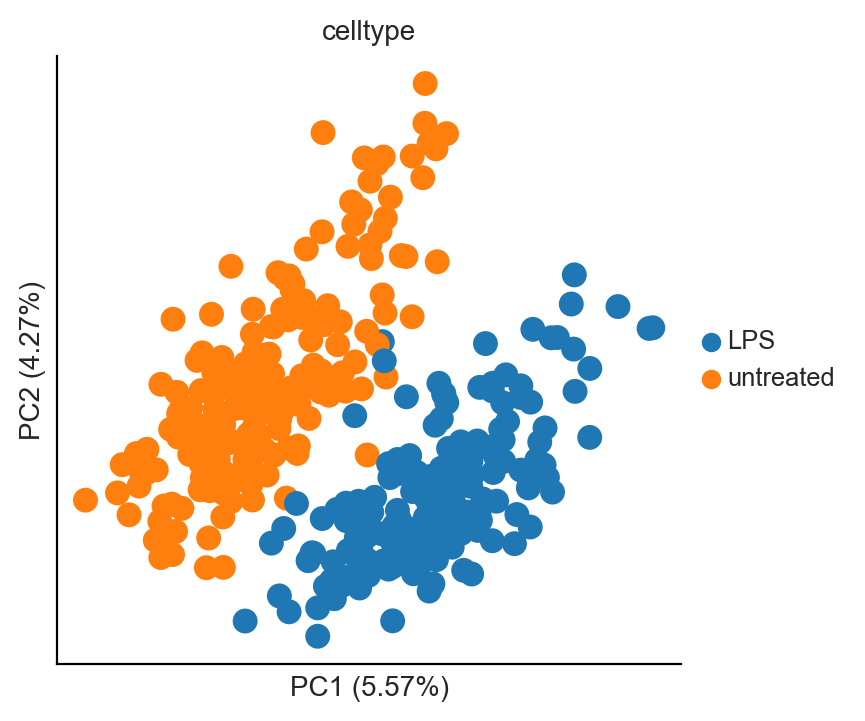

In [196]:
sc.settings.set_figure_params(dpi=100, dpi_save=300, vector_friendly=True, fontsize=10)
sc.tl.pca(df_huffman_adata, svd_solver="arpack")
sc.pl.pca(df_huffman_adata, color="celltype", annotate_var_explained=True, )
    


In [197]:
# Access the loadings
loadings = df_huffman_adata.varm['PCs']
loadings_df = pd.DataFrame(loadings, index=df_huffman_adata.var["Gene"])

pc = 0 # PC1

# Get the absolute value of the loadings to identify the most significant genes
abs_loadings = loadings_df.iloc[:, pc].abs()

# Sort the genes by their loading values in descending order
sorted_genes = abs_loadings.sort_values(ascending=False)

top_genes = sorted_genes.head(10)
print("Top genes contributing to PC1:")
print(top_genes)


Top genes contributing to PC1:
Gene
IFIT1     0.144957
SOD2      0.139648
ISG15     0.129619
ISG20     0.126352
GBP2      0.125942
FCER1G    0.122075
UBXN4     0.114359
PRDX1     0.109037
IFIT3     0.093034
SAMHD1    0.091062
Name: 0, dtype: float32


**2.2.2 UMAP**
<br><br>

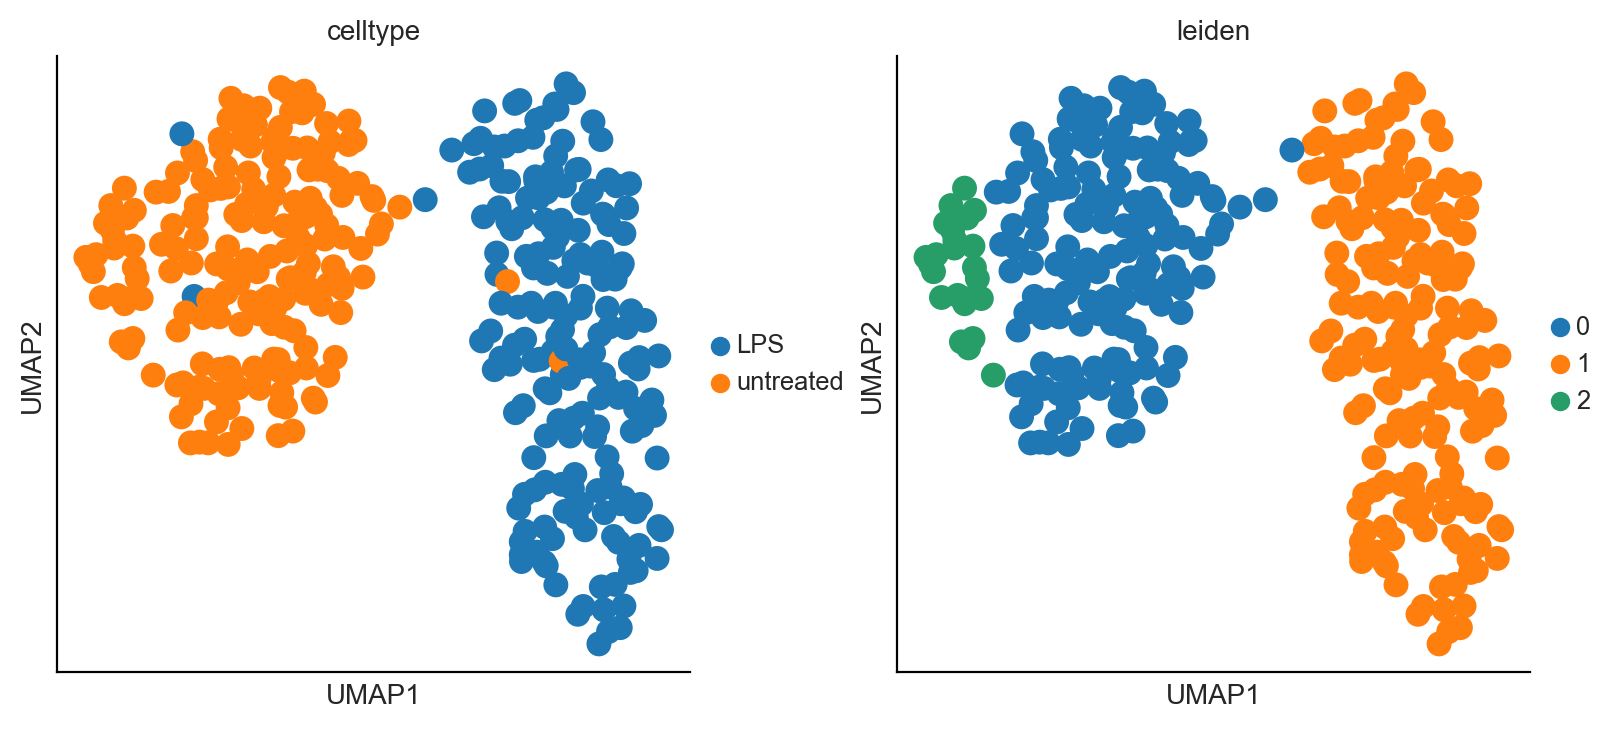

In [198]:
# UMAP preparation and plot
sc.pp.neighbors(df_huffman_adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(df_huffman_adata)

# Run clustering (Leiden algorithm)
sc.tl.leiden(df_huffman_adata, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)

# Visualize UMAP with clusters
sc.pl.umap(df_huffman_adata, color=['celltype', 'leiden'])


In [199]:
print("Number of cells per cluster:")
print(df_huffman_adata.obs["leiden"].value_counts())


Number of cells per cluster:
leiden
1    184
0    165
2     24
Name: count, dtype: int64


**2.2 Single-cell - Huffman, R.G., et al. (2022)**<br><br>
**2.2.1 PCA**


**2.2.2 UMAP**


**2.3 Hetereogenithy of cells M0**

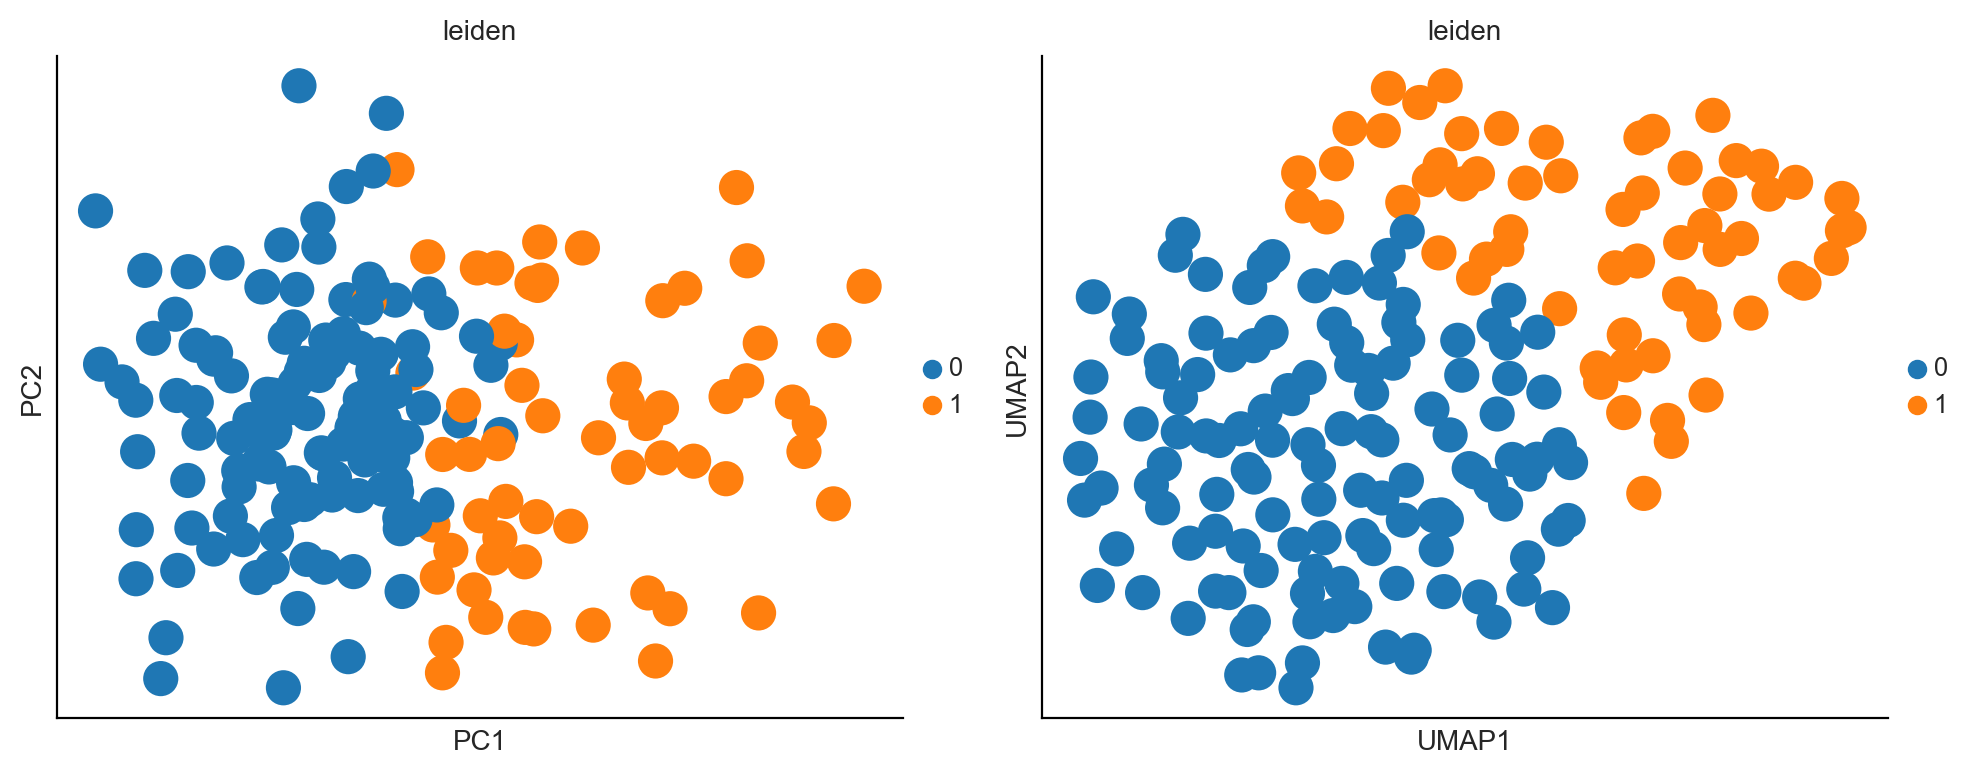

In [200]:
# Filter data
df_huffman_adata_M0 = df_huffman_adata[df_huffman_adata.obs["celltype"] == "untreated"]

# Compute PCA
sc.tl.pca(df_huffman_adata_M0)

# Compute neighbors
sc.pp.neighbors(df_huffman_adata_M0)

# Compute UMAP
sc.tl.umap(df_huffman_adata_M0)

# Perform clustering
sc.tl.leiden(df_huffman_adata_M0, resolution=0.5)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plots
sc.pl.pca(df_huffman_adata_M0, color='leiden', ax=axes[0], show=False)
sc.pl.umap(df_huffman_adata_M0, color='leiden', ax=axes[1], show=False)
plt.tight_layout()
plt.show()

In [201]:
# Print the number of cells per cluster
print("Number of cells per cluster:")
print(df_huffman_adata_M0.obs["leiden"].value_counts())


Number of cells per cluster:
leiden
0    125
1     62
Name: count, dtype: int64


In [202]:
# Analyze the top genes contributing to the separation of clusters
loadings = df_huffman_adata_M0.varm['PCs']
loadings_df = pd.DataFrame(loadings, index=df_huffman_adata_M0.var["Gene"])

pc = 0 # PC1

# Get the absolute value of the loadings to identify the most significant genes
abs_loadings = loadings_df.iloc[:, pc].abs()

# Sort the genes by their loading values in descending order
sorted_genes = abs_loadings.sort_values(ascending=False)

top_genes = sorted_genes.head(10)
print("Top genes contributing to PC1:")
print(top_genes)

Top genes contributing to PC1:
Gene
S100A11     0.221746
RBM39       0.197669
GPNMB       0.146500
EVL         0.123098
ATP6V1G1    0.116201
NIBAN2      0.109679
ATP6V1E1    0.107943
ESD         0.105199
MUG1        0.086481
ATP6V1B2    0.086423
Name: 0, dtype: float32


**2.4 Hetereogenithy of cells M1**

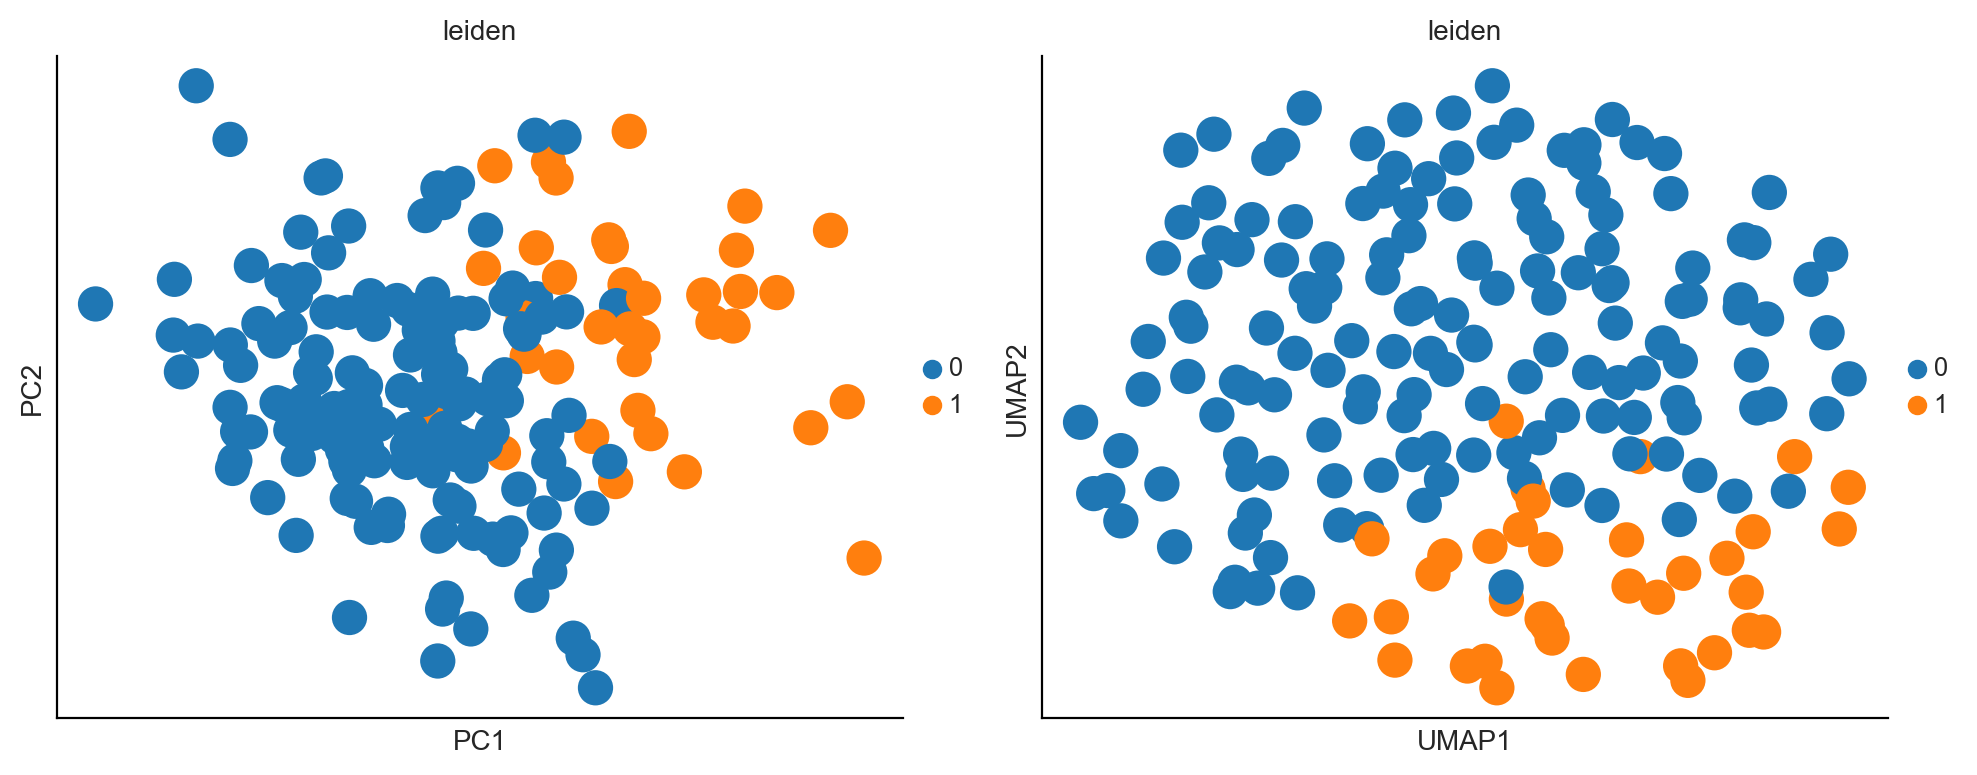

In [203]:
# Filter data
df_huffman_adata_M1 = df_huffman_adata[df_huffman_adata.obs["celltype"] == "LPS"]

# Compute PCA
sc.tl.pca(df_huffman_adata_M1)
# Compute neighbors
sc.pp.neighbors(df_huffman_adata_M1)
# Compute UMAP
sc.tl.umap(df_huffman_adata_M1)

# Perform clustering
sc.tl.leiden(df_huffman_adata_M1, resolution=0.5)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plots
sc.pl.pca(df_huffman_adata_M1, color='leiden', ax=axes[0], show=False)
sc.pl.umap(df_huffman_adata_M1, color='leiden', ax=axes[1], show=False)
plt.tight_layout()
plt.show()


In [204]:
# Analyze the top genes contributing to the separation of clusters
loadings = df_huffman_adata_M1.varm['PCs']
loadings_df = pd.DataFrame(loadings, index=df_huffman_adata_M1.var["Gene"])

pc = 0 # PC1

# Get the absolute value of the loadings to identify the most significant genes
abs_loadings = loadings_df.iloc[:, pc].abs()

# Sort the genes by their loading values in descending order
sorted_genes = abs_loadings.sort_values(ascending=False)

top_genes = sorted_genes.head(10)
print("Top genes contributing to PC1:")
print(top_genes)


Top genes contributing to PC1:
Gene
S100A11     0.151163
GPNMB       0.121903
EVL         0.111427
NIBAN2      0.106077
FUS         0.098485
ATP6V1E1    0.091611
RTN4        0.091150
CYB5R3      0.085630
PRDX1       0.084123
ESD         0.080327
Name: 0, dtype: float32


In [205]:
# compute and plot UMAP for M1 cells only
df_huffman_adata_M1 = df_huffman_adata[df_huffman_adata.obs["celltype"] == "LPS"]
sc.pp.neighbors(df_huffman_adata_M1, n_neighbors=10, n_pcs=20)


# Experiment --------------------

Volcano plot for M1 only

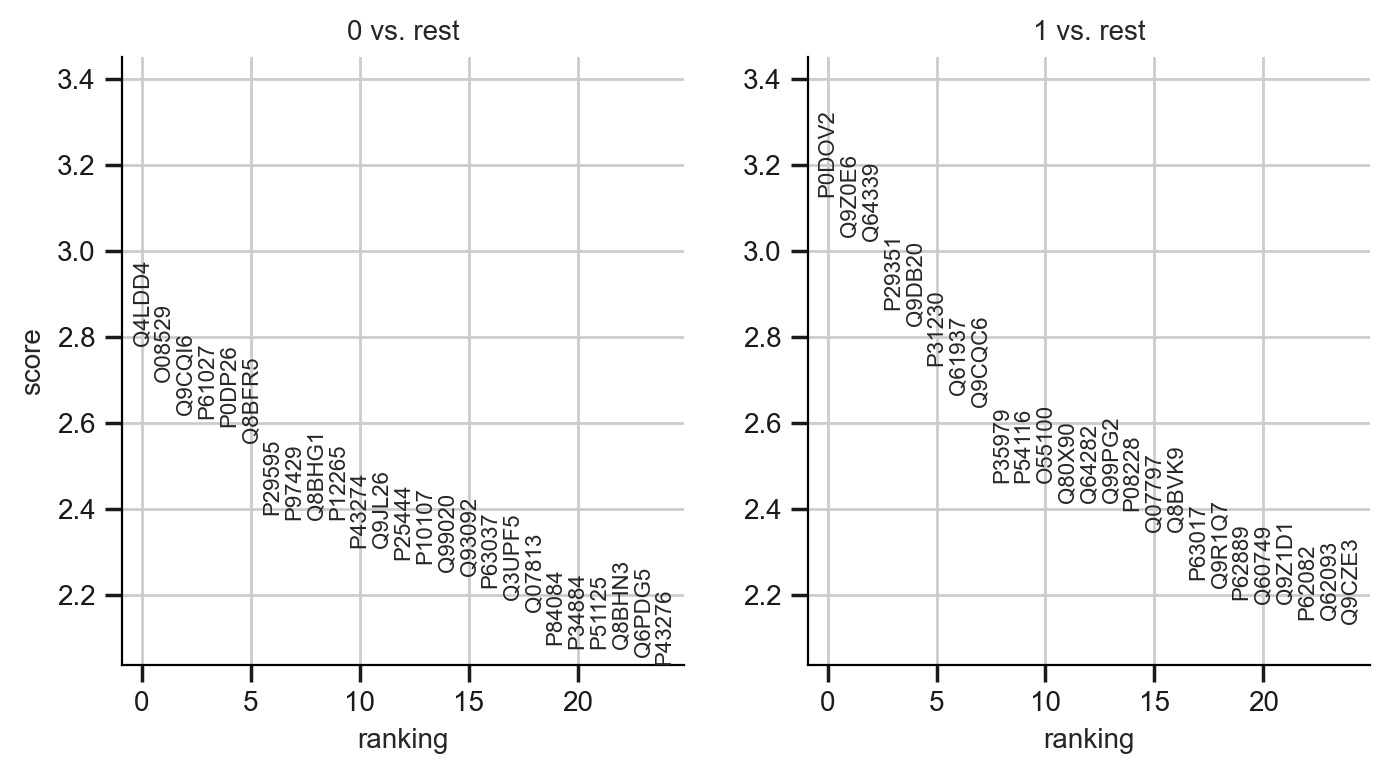

In [206]:
# Compute p_values, log2fc and adjusted p_values for df_huffman_adata_M1
sc.tl.rank_genes_groups(df_huffman_adata_M1, groupby="leiden", method="wilcoxon")

# Plot the results
sc.pl.rank_genes_groups(df_huffman_adata_M1, n_genes=25, sharey=True)



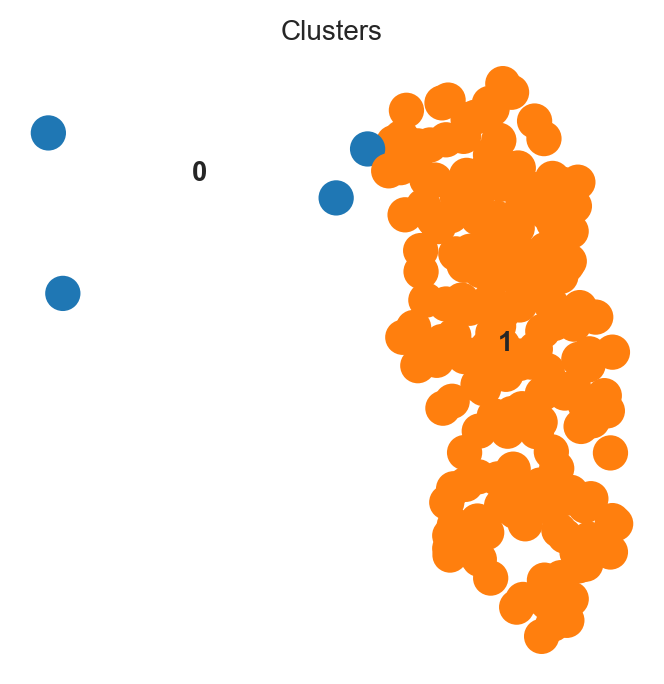

In [207]:
# plot the clusters
sc.pl.umap(df_huffman_adata_M1, color='leiden', legend_loc='on data', title='Clusters', frameon=False)




In [208]:
df_huffman_adata_M1.var['neg_log10_p_value'] = -np.log10(df_huffman_adata_M1.var['adj_p_value'])

# Create a color column based on the p-value threshold and fold change
df_huffman_adata_M1.var['color'] = 'blue'
df_huffman_adata_M1.var.loc[df_huffman_adata_M1.var['adj_p_value'] < PVAL_THRESHOLD, 'color'] = 'gray'
df_huffman_adata_M1.var.loc[(df_huffman_adata_M1.var['adj_p_value'] < PVAL_THRESHOLD) & (df_huffman_adata_M1.var['log2fc'] > LOG2_THRESHOLD), 'color'] = 'red'
df_huffman_adata_M1.var.loc[(df_huffman_adata_M1.var['adj_p_value'] < PVAL_THRESHOLD) & (df_huffman_adata_M1.var['log2fc'] < -LOG2_THRESHOLD), 'color'] = 'red'

# Filter for significant genes with |log2fc| > LOG2_THRESHOLD and p-value < PVAL_THRESHOLD
significant_genes = df_huffman_adata_M1.var[(df_huffman_adata_M1.var['adj_p_value'] < PVAL_THRESHOLD) & (abs(df_huffman_adata_M1.var['log2fc']) > LOG2_THRESHOLD)]

# Volcano plot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_huffman_adata_M1.var, x='log2fc', y='neg_log10_p_value', hue='color', palette=['gray', 'blue', 'red'], legend=False)
plt.xlabel("Log2(Fold change)")
plt.ylabel("-Log10(p-value)")
plt.title("Volcano plot for the Huffman, R. G., et al. (2022) dataset")

# Draw a horizontal line at the significance threshold for -log10(PVAL_THRESHOLD)
plt.axhline(-np.log10(PVAL_THRESHOLD), color='gray', linestyle='--')

# Draw relevant vertical lines
plt.axvline(-LOG2_THRESHOLD, color='gray', linestyle='--')
plt.axvline(LOG2_THRESHOLD, color='gray', linestyle='--')

# Annotate significant genes with some space added
for idx, row in significant_genes.iterrows():
    plt.text(row['log2fc'] + 0.1, row['neg_log10_p_value'] + 2, row["Gene"], fontsize=8, ha='right')

plt.tight_layout()
plt.show()

KeyError: 'adj_p_value'

## To be removed (Begin) ---------------

In [ ]:
# Run clustering (Leiden algorithm)
sc.tl.leiden(df_huffman_adata_M1, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)

# Visualize UMAP with clusters
sc.pl.umap(df_huffman_adata_M1, color=['leiden', 'celltype'])


# Ideas
1. Same with only 1 group (e.g. because of cell state)
2. Merge two SC datasets (and repeat 1)
3. Biological analysis of SC (only 1 group)
4. MUST: DEA with bulk
5. (DONE) Understand filtering

(DONE) INTRO DELS MACROPHAGS i perquè és interessant el seu estudi

**Captions for each figure**


## To be removed (End) ---------------

**2.5 Differential Expression Analysis**

In [ ]:
df_huffman_adata_gene = df_huffman_adata.copy()
df_huffman_adata_gene.var.index = df_huffman_adata_gene.var["Gene"]

print("Differential expression analysis between M0 and M1 for the Huffman, R. G., et al. (2022) dataset")
sc.tl.rank_genes_groups(df_huffman_adata_gene, groupby="celltype", groups=["untreated", "LPS"], method="t-test")
sc.pl.rank_genes_groups(df_huffman_adata_gene, n_genes=20)

In [ ]:


# Perform t-test for each protein for Huffman, R. G., et al. (2022) --------------------------------------------------
p_values = []
log2fcs = []

for i in range(df_huffman_adata.X.shape[1]):
    # perform the t-test
    p_value = ttest_ind(df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'LPS'][:, i], df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'untreated'][:, i])[1]
    p_values.append(p_value)
    # log2fc
    log2fc = df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'LPS'][:, i].mean() - df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'untreated'][:, i].mean() 
    log2fcs.append(log2fc)

# Calculate the adjusted p-values after all p-values have been computed
adj_p_values = multipletests(p_values, method='fdr_bh')[1]

# Store results in AnnData
df_huffman_adata.var['p_value'] = p_values
df_huffman_adata.var['adj_p_value'] = adj_p_values
df_huffman_adata.var['log2fc'] = log2fcs

# Sort the proteins by the adjusted p-value
top_proteins = df_huffman_adata.var.sort_values('adj_p_value')

# Print the 10 proteins with the lowest adjusted p-values
top_proteins.head(10)


In [ ]:
df_huffman_adata.var['neg_log10_p_value'] = -np.log10(df_huffman_adata.var['adj_p_value'])

# Create a color column based on the p-value threshold and fold change
df_huffman_adata.var['color'] = 'blue'
df_huffman_adata.var.loc[df_huffman_adata.var['adj_p_value'] < PVAL_THRESHOLD, 'color'] = 'gray'
df_huffman_adata.var.loc[(df_huffman_adata.var['adj_p_value'] < PVAL_THRESHOLD) & (df_huffman_adata.var['log2fc'] > LOG2_THRESHOLD), 'color'] = 'red'
df_huffman_adata.var.loc[(df_huffman_adata.var['adj_p_value'] < PVAL_THRESHOLD) & (df_huffman_adata.var['log2fc'] < -LOG2_THRESHOLD), 'color'] = 'red'

# Filter for significant genes with |log2fc| > LOG2_THRESHOLD and p-value < PVAL_THRESHOLD
significant_genes = df_huffman_adata.var[(df_huffman_adata.var['adj_p_value'] < PVAL_THRESHOLD) & (abs(df_huffman_adata.var['log2fc']) > LOG2_THRESHOLD)]

# Volcano plot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_huffman_adata.var, x='log2fc', y='neg_log10_p_value', hue='color', palette=['gray', 'blue', 'red'], legend=False)
plt.xlabel("Log2(Fold change)")
plt.ylabel("-Log10(p-value)")
plt.title("Volcano plot for the Huffman, R. G., et al. (2022) dataset")

# Draw a horizontal line at the significance threshold for -log10(PVAL_THRESHOLD)
plt.axhline(-np.log10(PVAL_THRESHOLD), color='gray', linestyle='--')

# Draw relevant vertical lines
plt.axvline(-LOG2_THRESHOLD, color='gray', linestyle='--')
plt.axvline(LOG2_THRESHOLD, color='gray', linestyle='--')

# Annotate significant genes with some space added
for idx, row in significant_genes.iterrows():
    plt.text(row['log2fc'] + 0.1, row['neg_log10_p_value'] + 2, row["Gene"], fontsize=8, ha='right')

plt.tight_layout()
plt.show()


Figure X: Volcano plot for the Huffman, R. G., et al. (2022) dataset. The plot illustrates the relationship between the fold change (Log2(Fold Change)) and statistical significance (-Log10(p-value)) of differentially expressed proteins in human monocytes and macrophages (THP-1 cells) under LPS treatment versus untreated conditions. Each point represents a protein, with blue points indicating proteins that are not significantly differentially expressed and red points indicating proteins that are significantly differentially expressed (adj. p-value < 0.05). Highlighted proteins, such as IFIT1, GBP2, ISG15, and SOD2, demonstrate significant differential expression and are key drivers in the observed immune response. 

# Ideas
* Plots: https://scanpy-tutorials.readthedocs.io/en/latest/plotting/core.html


In [ ]:
# Ensure proper normalization and log transformation
sc.pp.normalize_total(df_lps_adata, target_sum=1e4)
sc.pp.log1p(df_lps_adata)

# Filter genes with low expression
sc.pp.filter_genes(df_lps_adata, min_counts=3)

# Re-run marker gene analysis
sc.tl.rank_genes_groups(df_lps_adata, groupby='leiden', method='t-test', corr_method='benjamini-hochberg')

# Check log fold changes again
logfoldchanges = df_lps_adata.uns['rank_genes_groups']['logfoldchanges']
print(logfoldchanges)


In [ ]:
significant_genes = df_huffman_adata.uns['rank_genes_groups']['names'][(df_huffman_adata.uns['rank_genes_groups']['pvals_adj'] < PVAL_THRESHOLD) & (abs(df_huffman_adata.uns['rank_genes_groups']['logfoldchanges']) > 1)]
df_huffman_adata

# Volcano plot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_huffman_adata.uns['rank_genes_groups'], x='logfoldchanges', y=-np.log10(df_huffman_adata.uns['rank_genes_groups']['pvals_adj']), hue='pvals_adj', palette='viridis', legend=False)
plt.xlabel("Log2(Fold change)")
plt.ylabel("-Log10(p-value)")
plt.title("Volcano plot for the LPS-treated cells (Huffman et al. 2022)")

# Draw a horizontal line at the significance threshold for -log10(PVAL_THRESHOLD)
plt.axhline(-np.log10(PVAL_THRESHOLD), color='gray', linestyle='--')

# Draw relevant vertical lines
plt.axvline(-1, color='gray', linestyle='--')
plt.axvline(1, color='gray', linestyle='--')

# Annotate significant genes with some space added
for gene in significant_genes:
    plt.text(df_huffman_adata.uns['rank_genes_groups']['logfoldchanges'][gene] + 0.1, -np.log10(df_huffman_adata.uns['rank_genes_groups']['pvals_adj'][gene]) + 2, gene, fontsize=8, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
# volcano plot using df_lps_adata.uns['rank_genes_groups'] (that already includes the pvals_adj, logfoldchange,...)
# Filter for significant genes with |log2fc| > 1 and p-value < PVAL_THRESHOLD
significant_genes = df_lps_adata.uns['rank_genes_groups']['names'][(df_lps_adata.uns['rank_genes_groups']['pvals_adj'] < PVAL_THRESHOLD) & (abs(df_lps_adata.uns['rank_genes_groups']['logfoldchanges']) > 1)]

# Volcano plot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_lps_adata.uns['rank_genes_groups'], x='logfoldchanges', y=-np.log10(df_lps_adata.uns['rank_genes_groups']['pvals_adj']), hue='pvals_adj', palette='viridis', legend=False)
plt.xlabel("Log2(Fold change)")
plt.ylabel("-Log10(p-value)")
plt.title("Volcano plot for the LPS-treated cells (Huffman et al. 2022)")

# Draw a horizontal line at the significance threshold for -log10(PVAL_THRESHOLD)
plt.axhline(-np.log10(PVAL_THRESHOLD), color='gray', linestyle='--')

# Draw relevant vertical lines
plt.axvline(-1, color='gray', linestyle='--')
plt.axvline(1, color='gray', linestyle='--')

# Annotate significant genes with some space added
for gene in significant_genes:
    plt.text(df_lps_adata.uns['rank_genes_groups']['logfoldchanges'][gene] + 0.1, -np.log10(df_lps_adata.uns['rank_genes_groups']['pvals_adj'][gene]) + 2, gene, fontsize=8, ha='right')

plt.tight_layout()
plt.show()


In [ ]:
sc.pp.normalize_total(df_lps_adata, target_sum=1e4)
sc.pp.log1p(df_lps_adata)

# Filter genes with low expression
sc.pp.filter_genes(df_lps_adata, min_counts=3)

In [ ]:
# Extract relevant data from rank_genes_groups
logfoldchanges = np.array(df_lps_adata.uns['rank_genes_groups']['logfoldchanges'])
pvals_adj = np.array(df_lps_adata.uns['rank_genes_groups']['pvals_adj'])
gene_names = np.array(df_lps_adata.uns['rank_genes_groups']['names'])

print(logfoldchanges)
print()
print(pvals_adj)
print()
print(gene_names)


# Filter for significant genes with |log2fc| > 1 and adjusted p-value < PVAL_THRESHOLD
significant_mask = (abs(logfoldchanges) > 1) & (pvals_adj < PVAL_THRESHOLD)

# Extract significant gene names
significant_genes = gene_names[significant_mask]
significant_logfoldchanges = logfoldchanges[significant_mask]
significant_pvals_adj = pvals_adj[significant_mask]

# Create a volcano plot
plt.figure(figsize=(10, 5))
plt.scatter(logfoldchanges, -np.log10(pvals_adj), color='gray', alpha=0.5)
plt.scatter(significant_logfoldchanges, -np.log10(significant_pvals_adj), color='red')
plt.xlabel('Log2 fold change')
plt.ylabel('-Log10(p-value)')
plt.title('Volcano plot')
plt.axhline(y=-np.log10(PVAL_THRESHOLD), color='blue', linestyle='--')  # Significance threshold
plt.axvline(x=-1, color='blue', linestyle='--')  # Log2 fold change threshold
plt.axvline(x=1, color='blue', linestyle='--')  # Log2 fold change threshold

# Annotate significant genes
for i, gene in enumerate(significant_genes):
    plt.text(significant_logfoldchanges[i], -np.log10(significant_pvals_adj[i]), gene, fontsize=8, ha='right')

plt.tight_layout()
plt.show()


**X.x Marker Gene Analysis**<br>
Perform functional enrichment analysis, identifying overrepresented pathways and biological processes.

In [ ]:
# Perform marker gene analysis for clusters
sc.tl.rank_genes_groups(df_huffman_adata, groupby='leiden', method='t-test')

# Plot marker genes for clusters
sc.pl.rank_genes_groups(df_huffman_adata, n_genes=20, sharey=False)


**X.x Functional Enrichement Analysis**<br>
Extract the marker genes for each cluster, then use g:Profiler for enrichment analysis

In [ ]:
import gprofiler

# Extract top marker genes for each cluster
marker_genes_cluster_0 = df_lps_adata.uns['rank_genes_groups']['names']['0'][:20]
marker_genes_cluster_1 = df_lps_adata.uns['rank_genes_groups']['names']['1'][:20]

# Perform functional enrichment using g:Profiler
gp = gprofiler.GProfiler(return_dataframe=True)
enrichment_cluster_0 = gp.profile(organism='hsapiens', query=marker_genes_cluster_0)
enrichment_cluster_1 = gp.profile(organism='hsapiens', query=marker_genes_cluster_1)

# Display results
print("Enrichment analysis for Cluster 0:")
print(enrichment_cluster_0.head())

print("\nEnrichment analysis for Cluster 1:")
print(enrichment_cluster_1.head())


**X.x Density plots**<br>


In [ ]:
# Single density plot (protein P51863)
plt.figure(figsize=(10, 5))
sns.kdeplot(df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'LPS'][:, df_huffman_adata.var.index == 'P51863'].flatten(), label='LPS')
sns.kdeplot(df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'untreated'][:, df_huffman_adata.var.index == 'P51863'].flatten(), label='untreated')
plt.xlabel('Intensity')
plt.ylabel('Density')
plt.title('Density plot for protein P51863')
plt.legend()
plt.show()

In [ ]:
# Top 1 protein density plot
plt.figure(figsize=(10, 5))
sns.kdeplot(df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'LPS'][:, df_huffman_adata.var.index == top_proteins.index[0]].flatten(), label='LPS')
sns.kdeplot(df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'untreated'][:, df_huffman_adata.var.index == top_proteins.index[0]].flatten(), label='untreated')
plt.xlabel('Intensity')
plt.ylabel('Density')
plt.title(f'Density plot for gene "{top_proteins["Gene"].values[0]}" ({top_proteins.index[0]})')
plt.legend()
plt.show()


In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 30))

# iterate over the proteins
for i, protein in enumerate(top_proteins[:24].index):
    # get the row and column index
    row = i // 4
    col = i % 4
    # plot the density plot
    sns.kdeplot(df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'LPS'][:, df_huffman_adata.var.index == protein].flatten(), label='LPS', ax=axes[row, col])
    sns.kdeplot(df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'untreated'][:, df_huffman_adata.var.index == protein].flatten(), label='untreated', ax=axes[row, col])
    axes[row, col].set_title(protein + ' (p-value: ' + str(df_huffman_adata.var.loc[protein, 'p_value']) + ')')
    axes[row, col].set_xlabel('Intensity')
    axes[row, col].set_ylabel('Density')
    axes[row, col].legend()

plt.tight_layout()
plt.show()


**1.5 Hetereogenithy of cells M1**

In [ ]:
df_lps_adata = df_huffman_adata[df_huffman_adata.obs['celltype'] == 'LPS'].copy()
df_lps_adata

In [ ]:

# Clean PCA, UMAP, log2fc, neg_log10_p_value, colour and p_value data
df_lps_adata.obsm = {}
df_lps_adata.uns = {}
df_lps_adata.var.drop(['log2fc', 'neg_log10_p_value', 'color', 'p_value'], axis=1, inplace=True)
df_lps_adata.obsp = {}

# Computing principal components
sc.tl.pca(df_lps_adata, svd_solver='arpack')

# Computing neighbors for UMAP
sc.pp.neighbors(df_lps_adata, n_neighbors=15, n_pcs=40)

# Computing UMAP
sc.tl.umap(df_lps_adata)

# Running clustering (Leiden algorithm)
sc.tl.leiden(df_lps_adata, resolution=0.5)

# Visualizing UMAP with clusters
sc.pl.umap(df_lps_adata, color=['leiden'])


In [ ]:
# Perform marker gene analysis for clusters
sc.tl.rank_genes_groups(df_lps_adata, groupby='leiden', method='t-test')

# Plot marker genes for clusters
sc.pl.rank_genes_groups(df_lps_adata, n_genes=20, sharey=False)


In [ ]:
df_lps_adata.uns['rank_genes_groups']

In [ ]:
# Print top 5 genes for each cluster
for cluster in df_lps_adata.obs['leiden'].unique():
    print(f"Cluster {cluster}")
    print(df_lps_adata.uns['rank_genes_groups']['names'])
    print()
    

In [ ]:
#compute p_value and log2fc for each gene
p_values = []
log2fcs = []

for i in range(df_lps_adata.X.shape[1]):
    # perform the t-test
    p_value = ttest_ind(df_lps_adata.X[:, i], df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'untreated'][:, i])[1]
    # store the p-value
    p_values.append(p_value)
    log2fcs.append((df_lps_adata.X[:, i].mean() + 1) - (df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'untreated'][:, i].mean() + 1))

df_lps_adata.var['p_value'] = p_values
df_lps_adata.var['log2fc'] = log2fcs

# sort the proteins by the p-value
top_proteins = df_lps_adata.var.sort_values('p_value')

# print the 10 proteins with the lowest p-values
print(top_proteins)

# Volcano plot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_lps_adata.var, x='log2fc', y='p_value', hue='color', palette=['gray', 'blue', 'red'], legend=False)
plt.xlabel("Log2(Fold change)")
plt.ylabel("p-value")
plt.title("Volcano plot for the LPS-treated cells in the Huffman, R. G., et al. (2022) dataset")

# Draw a horizontal line at the significance threshold for p-value = PVAL_THRESHOLD
plt.axhline(PVAL_THRESHOLD, color='gray', linestyle='--')

# Draw relevant vertical lines
plt.axvline(-1, color='gray', linestyle='--')
plt.axvline(1, color='gray', linestyle='--')

# Annotate significant genes with some space added
for idx, row in top_proteins.iterrows():
    plt.text(row['log2fc'] + 0.1, row['p_value'] + 0.01, row["Gene"], fontsize=8, ha='right')

plt.tight_layout()
plt.show()



In [ ]:
import scanpy as sc

# Perform marker gene analysis for clusters
sc.tl.rank_genes_groups(df_lps_adata, groupby='leiden', method='t-test')

# Plot marker genes for clusters
sc.pl.rank_genes_groups(df_lps_adata, n_genes=20, sharey=False)


In [ ]:
# New AnnData object with LPS only
df_huffman_adata_lps = df_huffman_adata[df_huffman_adata.obs['celltype'] == 'LPS']

# Remove PCA and UMAP data
df_huffman_adata_lps.obsm = {}
df_huffman_adata_lps.uns = {}

# Perform PCA
sc.tl.pca(df_huffman_adata_lps, svd_solver="arpack")

# Perform UMAP
sc.pp.neighbors(df_huffman_adata_lps, use_rep='X_pca')
sc.tl.umap(df_huffman_adata_lps)

# Perform clustering
sc.tl.leiden(df_huffman_adata_lps, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)

# Plot the PCA, UMAP and leiden clustering
sc.pl.pca(df_huffman_adata_lps, color='leiden')

sc.pl.umap(df_huffman_adata_lps, color='leiden')



In [ ]:
# New AnnData object with LPS only
df_huffman_adata_lps = df_huffman_adata[df_huffman_adata.obs['celltype'] == 'LPS']

# Remove PCA and UMAP data
df_huffman_adata_lps.obsm = {}
df_huffman_adata_lps.uns = {}

# Perform PCA
sc.tl.pca(df_huffman_adata_lps, svd_solver="arpack")

# Perform UMAP
sc.pp.neighbors(df_huffman_adata_lps, use_rep='X_pca')
sc.tl.umap(df_huffman_adata_lps)

# Perform clustering
sc.tl.leiden(df_huffman_adata_lps, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)


In [ ]:
# Plot the PCA, UMAP and leiden clustering
sc.pl.pca(df_huffman_adata_lps, color='leiden')

sc.pl.umap(df_huffman_adata_lps, color='leiden')

# Perform differential expression analysis


**1.5 Top Down/Up regulated genes per dataset**

In [ ]:
# Iwata


## Functional Enrichment

In [ ]:

sdb = StringDBClient(server_url="https://string-db.org/api", species=9606, score_threshold=400)

In [ ]:

# Network of the first 10 genes exclusively found in the single-cell data
only_sc_genes_10 = {k: only_sc_genes[k] for k in list(only_sc_genes)[:10]}

for gene in only_sc_genes_10:
    print("-" * 150)

    try:
        image_data = sdb.get_network_image(gene, "image")
        page = sdb.get_protein_page(gene, "tsv-no-header")

        print("Gene: ", gene)
        print("Protein: ", only_sc_genes[gene]) 

        print(page)
        display(Image(image_data))
    except:
        print("No gene found in String-DB with name ", gene)
        print(" ")
        continue



---
# Huffman preparation 
## TO BE REVIWED AND RELOCATED



In [ ]:
# compute the protein intensity mean per cell type and store it in the AnnData object as var
adata.var['mean_intensity_LPS'] = adata.X[adata.obs['celltype'] == 'LPS'].mean(axis=0)
adata.var['mean_intensity_untreated'] = adata.X[adata.obs['celltype'] == 'untreated'].mean(axis=0)

# compute the difference in mean intensity between LPS and untreated
adata.var['mean_intensity_diff'] = np.abs(adata.var['mean_intensity_LPS'] - adata.var['mean_intensity_untreated'])

# sort the proteins by the difference in mean intensity
adata.var = adata.var.sort_values('mean_intensity_diff', ascending=False)
print(adata.var)



Without Scanpy

In [ ]:
df_huffmanT = df_huffman.T
df_huffmanT.index.name = "id"

In [ ]:
df_huffmanT


In [ ]:
df_huffman_meta

In [ ]:
df_huffmanT["cellype"] = df_huffman_meta["celltype"]

In [ ]:
df_huffmanT

In [ ]:
# print colnames(df_huffmanT)
print(df_huffmanT.columns)

In [ ]:
df_huffmanT.T

In [ ]:
# Take the proteins from df_huffmanT.T thta has celltype = LPS
df_huffman_M1 = df_huffmanT[df_huffmanT["cellype"] == "LPS"]
df_huffman_M0 = df_huffmanT[df_huffmanT["cellype"] == "untreated"]
df_huffman_control = df_huffmanT[df_huffmanT["cellype"] == "control"]

In [ ]:
df_huffman

In [ ]:
# plot the distribution of the intenisties of protein "A2ADY9" for both, LPS and untreated
plt.hist(df_huffman_M0["Q64282"])
plt.hist(df_huffman_M1["Q64282"])
plt.show()


In [ ]:
# load into scanpy the df_huffmanT (use the celltype as obs)



Checking null values

In [ ]:
# Experiment 1: 2016 Iwata et al.
print("Proteins with null values in the column ['126/126']:", df_2016_iwata["126/126"].isnull().sum())
print("This proteins MUST be removed from the dataset as they should have 1.00")
print("")

# Expermient 2: 2022 Pengfei et al.
#print("Null values 

# Expermient 3: 2021 Pengfei et al.
# print the number of rows with null values in all these 3 columns Abundance Ratio: (M1) / (M0)	Abundance Ratio: (M2) / (M0)	Abundance Ratio: (M2) / (M1)
print("Proteins with null values in the column ['Abundance Ratio: (M1) / (M0)']:", df_2021_pengfei["Abundance Ratio: (M1) / (M0)"].isnull().sum())
print("Proteins with null values in the column ['Abundance Ratio: (M2) / (M0)']:", df_2021_pengfei["Abundance Ratio: (M2) / (M0)"].isnull().sum())
print("Proteins with null values in the column ['Abundance Ratio: (M2) / (M1)']:", df_2021_pengfei["Abundance Ratio: (M2) / (M1)"].isnull().sum())


In [ ]:
# Create a dataframe with the number of proteins identified in all datasets. and cell types
df_grouped = pd.DataFrame({
    "Dataset": ["Iwata, H., et al. (2016)", "Li, P., et al. (2022)", "Li, P., et al. (2021)"],
    "M0": [len(df_2016_iwata_M0.index.unique()), len(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M0"] > 0].index.unique()), len(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M0"] > 0].index.unique())],
    "M1": [len(df_2016_iwata_M1.index.unique()), len(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M1"] > 0].index.unique()), len(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M1"] > 0].index.unique())],
    "M2": [len(df_2016_iwata_M2.index.unique()), len(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2"] > 0].index.unique()), len(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M2"] > 0].index.unique())]
})

Filtering Null values:


In [ ]:
#print(df_2022_pengfei.describe())
#df_2022_pengfei

**1.5 Abundance of proteins per group**

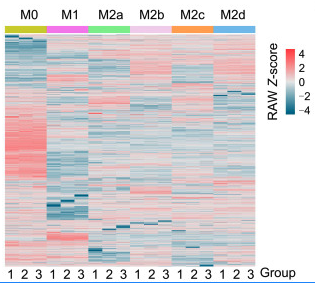

Adding new features:

In [ ]:
ABUNDANCE_RATIO_THRESHOLD = 1.5

# EXPERIMENT 2: df_2022_pengfei
#   Abundance ratio average for M2
#   Type, inferred using the abundance ratio
groupM2 = ['Abundance Ratio: (M2a) / (M1)', 'Abundance Ratio: (M2b) / (M1)', 'Abundance Ratio: (M2c) / (M1)', 'Abundance Ratio: (M2d) / (M1)']
df_2022_pengfei["Abundance Ratio: M2 / M1"] = df_2022_pengfei[groupM2].mean(axis=1)

groupM2 = ['Abundance Ratio: (M2a) / (M0)', 'Abundance Ratio: (M2b) / (M0)', 'Abundance Ratio: (M2c) / (M0)', 'Abundance Ratio: (M2d) / (M0)']
df_2022_pengfei["Abundance Ratio: M2 / M0"] = df_2022_pengfei[groupM2].mean(axis=1)

"""
# Abundance ratio of M1/M0
df_2022_pengfei['Abundance Ratio: M1/M0'] = (
    (df_2022_pengfei['Abundances (Normalized): F4: Sample, M1'] + 
     df_2022_pengfei['Abundances (Normalized): F5: Sample, M1'] + 
     df_2022_pengfei['Abundances (Normalized): F6: Sample, M1']) / 3) / (
         (df_2022_pengfei['Abundances (Normalized): F1: Control, M0'] + 
          df_2022_pengfei['Abundances (Normalized): F2: Control, M0'] + 
          df_2022_pengfei['Abundances (Normalized): F3: Control, M0']) / 3)
"""


Boxplots:

In [ ]:
# Experiment 1: Boxplot of abundance ratios
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_2016_iwata, x="Type", y="131/126")
plt.title("Abundance Ratios (24h) in 2016 Iwata et al.")
plt.show()

# Experiment 2: Boxplot of abundance ratios
"""
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_2022_pengfei, x="Type", y="Abundance Ratio: (M1) / (M0)")
plt.title("Abundance Ratios (24h) in 2022 Pengfei et al.")
plt.show()
"""




In [ ]:
# Abundance ratios (Experiment 2)
df_2022_pengfei.boxplot(column=["Abundance Ratio: M2 / M1", "Abundance Ratio: M2 / M0"])
plt.show()

In [ ]:
"""
# Dendogram for Experiment 3 (df_2021_pengfei)
# Use these columns "Abundance Ratio: (M1) / (M0)"	"Abundance Ratio: (M2) / (M0)"	"Abundance Ratio: (M2) / (M1)"00_simple_pipeline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler

# Select the columns of interest
columns_of_interest = ["Abundance Ratio: (M1) / (M0)", "Abundance Ratio: (M2) / (M0)", "Abundance Ratio: (M2) / (M1)"]
data = df_2021_pengfei[columns_of_interest]

data
# check for missing values
print(data.isnull().sum())

# replace missign values with 0
data = data.fillna(0)

print(data.isnull().sum())


# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Compute linkage matrix for clustering
linkage_matrix = linkage(pdist(data_scaled), method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=data.index, leaf_rotation=90)
plt.title("Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

# Plot the heatmap with dendrogram ordering
sns.clustermap(data_scaled, row_linkage=linkage_matrix, col_cluster=False, cmap="viridis", figsize=(10, 8))
plt.title("Heatmap with Dendrogram Ordering")
plt.show()
"""


In [ ]:
"""
# Aggregated bar plot of number of proteins found in all experiments by cell type
df_2016_iwata.groupby("Type").count().plot(kind="bar", y="Accession")
df_2022_pengfei.groupby("Type").count().plot(kind="bar", y="Accession")
df_2021_pengfei.groupby("Type").count().plot(kind="bar", y="Accession")

plt.show()
"""

In [ ]:
"""
# Bar plot of the number of proteins found in each dataset (accumulated with M0, M1 and M2 in different colors)
num_prot_exp1 = len(df_2016_iwata.index.unique())
num_prot_exp2 = len(df_2022_pengfei.index.unique())
num_prot_exp3 = len(df_2021_pengfei.index.unique())

# Use the column type to count each cell type
num_prot_exp1_m0 = len(df_2016_iwata[df_2016_iwata["Type"] == "M0"].index.unique())
num_prot_exp1_m1 = len(df_2016_iwata[df_2016_iwata["Type"] == "M1"].index.unique())
num_prot_exp1_m2 = len(df_2016_iwata[df_2016_iwata["Type"] == "M2"].index.unique())

num_prot_exp2_m0 = len(df_2022_pengfei[df_2022_pengfei["Type"] == "M0"].index.unique())
num_prot_exp2_m1 = len(df_2022_pengfei[df_2022_pengfei["Type"] == "M1"].index.unique())
num_prot_exp2_m2 = len(df_2022_pengfei[df_2022_pengfei["Type"] == "M2"].index.unique())

num_prot_exp3_m0 = len(df_2021_pengfei[df_2021_pengfei["Type"] == "M0"].index.unique())
num_prot_exp3_m1 = len(df_2021_pengfei[df_2021_pengfei["Type"] == "M1"].index.unique())

num_prot_exp3_m2 = len(df_2021_pengfei[df_2021_pengfei["Type"] == "M2"].index.unique())

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar([1, 2, 3], [num_prot_exp1, num_prot_exp2, num_prot_exp3], color="gray", label="All")
plt.bar([1, 2, 3], [num_prot_exp1_m0, num_prot_exp2_m0, num_prot_exp3_m0], color="blue", label="M0")
plt.bar([1, 2, 3], [num_prot_exp1_m1, num_prot_exp2_m1, num_prot_exp3_m1], color="red", label="M1")
plt.bar([1, 2, 3], [num_prot_exp1_m2, num_prot_exp2_m2, num_prot_exp3_m2], color="green", label="M2")

plt.xticks([1, 2, 3], ["2016 Iwata et al.", "2022 Pengfei et al.", "2021 Pengfei et al."])
plt.ylabel("Number of proteins")
plt.legend()
plt.title("Number of proteins found in each dataset")
plt.show()
"""

In [ ]:
# Venn diagram
exp1_proteinsM0 = set(df_2016_iwata_M0.index)
exp1_proteinsM1 = set(df_2016_iwata_M1.index)
exp1_proteinsM2 = set(df_2016_iwata_M2.index)

venn3([exp1_proteinsM0, exp1_proteinsM1, exp1_proteinsM2], set_labels = ('M0', 'M1', 'M2'), set_colors=('mediumaquamarine', 'slategrey', 'gold'))
plt.title("THP-1 cells (Iwata, H., et al. (2016))")
plt.show()

### TODO: Check how they were stimulated and remove INF-y and IL-4 if needed

### TODO: Experiment 3Use columns like "Found in Sample Group: M2"

In [ ]:
# Venn diagram for df_2022_shisheng (M0, M1 and M2 as a whole)
MIN_ABUNDANCE = 70

exp2_proteinsM0 = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M0"] > MIN_ABUNDANCE].index)
exp2_proteinsM1 = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M1"] > MIN_ABUNDANCE].index)
exp2_proteinsM2a = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2a"] > MIN_ABUNDANCE].index)
exp2_proteinsM2b = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2b"] > MIN_ABUNDANCE].index)
exp2_proteinsM2c = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2c"] > MIN_ABUNDANCE].index)
exp2_proteinsM2d = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2d"] > MIN_ABUNDANCE].index)

exp2_proteinsM2 = exp2_proteinsM2a.union(exp2_proteinsM2b).union(exp2_proteinsM2c).union(exp2_proteinsM2d)

# Venn diagram
plt.title("THP-1 cells (Li, P., et al. (2022))")
venn3([exp2_proteinsM0, exp2_proteinsM1, exp2_proteinsM2], set_labels = ('M0', 'M1', 'M2'), set_colors=('mediumaquamarine', 'slategrey', 'gold'))
plt.show()

In [ ]:

"""
exp3_proteinsM0 = set(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M0"] > MIN_ABUNDANCE].index)
exp3_proteinsM1 = set(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M1"] > MIN_ABUNDANCE].index)
exp3_proteinsM2 = set(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M2"] > MIN_ABUNDANCE].index)
"""
exp3_proteinsM0 = set(df_2021_pengfei[df_2021_pengfei["Found in Sample Group: M0"] != "Not Found"].index)
exp3_proteinsM1 = set(df_2021_pengfei[df_2021_pengfei["Found in Sample Group: M1"] != "Not Found"].index)
exp3_proteinsM2 = set(df_2021_pengfei[df_2021_pengfei["Found in Sample Group: M2"] != "Not Found"].index)

# Venn diagram
plt.title("THP-1 cells (Li, P., et al. (2021))")
venn3([exp3_proteinsM0, exp3_proteinsM1, exp3_proteinsM2], set_labels = ('M0', 'M1', 'M2'), set_colors=('mediumaquamarine', 'slategrey', 'gold'))
plt.show()

#print (df_2021_pengfei[df_2021_pengfei["Found in Sample Group: M1"] != "Not Found"].describe())

### Proteins found in all the datasets for each of the states

**M0**


In [ ]:
exp1_m0_only = exp1_proteinsM0 - exp2_proteinsM0 - exp3_proteinsM0
exp2_m0_only = exp2_proteinsM0 - exp1_proteinsM0 - exp3_proteinsM0
exp3_m0_only = exp3_proteinsM0 - exp1_proteinsM0 - exp2_proteinsM0

common_proteins = exp1_proteinsM0.intersection(exp2_proteinsM0).intersection(exp3_proteinsM0)

print("Common proteins in M0: ", len(common_proteins))
print(list(common_proteins)[:10])

**M1**

In [ ]:
exp1_m1_only = exp1_proteinsM1 - exp1_proteinsM0 - exp1_proteinsM2
exp2_m1_only = exp2_proteinsM1 - exp2_proteinsM0 - exp2_proteinsM2
exp3_m1_only = exp3_proteinsM1 - exp3_proteinsM0 - exp3_proteinsM2

# Common proteins
common_proteins = exp1_m1_only.intersection(exp2_m1_only).intersection(exp3_m1_only)
print("Common proteins in M1: ", len(common_proteins))
print(common_proteins)




**M2**

In [ ]:
exp1_m2_only = exp1_proteinsM2 - exp1_proteinsM0 - exp1_proteinsM1
exp2_m2_only = exp2_proteinsM2 - exp2_proteinsM0 - exp2_proteinsM1
exp3_m2_only = exp3_proteinsM2 - exp3_proteinsM0 - exp3_proteinsM1

# Common proteins
common_proteins = exp1_m2_only.intersection(exp2_m2_only).intersection(exp3_m2_only)
print("Common proteins in M2: ", len(common_proteins))
print(common_proteins)


### Proteins with high abudance ratio in M1 vs M0



In [ ]:
FOLD_CHANGE_THRESHOLD = 1.5

In [ ]:
# Get the proteins with high abundance in M1 vs M0
exp1_m1_vs_m0 = 


In [ ]:
# Take the proteins with higher variance between M1 and M2
# Calculate the variance for each protein at point 131/126
#dataM1["VarianceVsM2"] = dataM1["131/126"] - dataM2["131/126"]
dataM1["VarianceVsM2"] = np.log10(dataM1["131/126"]) - np.log10(dataM2["131/126"])
dataM1["VarianceVsM2"] = dataM1["VarianceVsM2"]

# Sort the proteins by variance
dataM1 = dataM1.sort_values(by="VarianceVsM2", ascending=False)

# Take the top 10 proteins
top_proteins = dataM1.head(12)

# Print the top proteins
print("Top proteins with higher variance between M1 and M2")
print(top_proteins.index)
print(top_proteins["VarianceVsM2"])




In [ ]:
# Load count table
data_src = "./data/processed/2022_Shisheng SUN_35557041/PD_Globalproteomics_2022.xlsx"

# Load the data (index is the second column)
df = pd.read_excel(data_src, sheet_name="Proteins", index_col=2)

# Print the columns
print(df.columns)


### Matrix format

* **Protein FDR Confidence: Combined**: Reflects the level of confidence in the identification of each protein
* **Master**: A unique identifier assigned to each protein group.
* **Accession**: A database accession number (e.g., UniProt) for the protein.
* **Description**: A textual description of the protein's function and characteristics.
* **Sum PEP Score**: The sum of peptide-spectrum match (PSM) scores, indicating overall confidence in protein identification.
* **# Peptides**: The number of peptides identified for the protein.
* **# PSMs**: The total number of PSMs for the protein.
* **# Protein Unique Peptides**: The number of peptides uniquely assigned to this protein.
* **# Unique Peptides**: The total number of unique peptides identified.
* **# AAs**: The number of amino acids in the protein sequence.
* **MW [kDa]**: The molecular weight of the protein in kilodaltons.
* **Score Sequest HT: Sequest HT**: The score assigned by the Sequest HT search engine for the protein identification.
* **# Razor Peptides**: The number of peptides uniquely assigned to this protein group, helping to distinguish it from other similar proteins.

Quantitative Proteomics Data

* **Abundance Ratio**: These columns represent the relative abundance of a protein in different experimental conditions (e.g., M0, M1, M2a, M2b, M2c, M2d). The ratios are calculated by dividing the abundance of a protein in one condition by the abundance in another condition.
* **Abundances (Grouped)**: These columns represent the absolute or normalized abundance of a protein in each experimental group.
* **Abundances (Normalized)**: These columns represent the normalized abundance of a protein in each individual sample (F1-F18). Normalization is a process to account for experimental variability and ensure accurate comparison of protein abundance across samples.

Additional Information

* **Modifications**: This column indicates any post-translational modifications (PTMs) identified on the protein, such as phosphorylation or acetylation.

---


**Filter the low quality data**

Criteria:
* Peptides at least 2
* Confidence level = High

In [ ]:
# Print number of initial rows
print("Initial number of rows:", len(df))

# Drop rows with "Protein FDR Confidence: Combined" = "Low"
df = df[df["Protein FDR Confidence: Combined"] != "Low"]

# Drop rows with # Peptides < 2
df = df[df["# Peptides"] >= 2]

# Print number of rows after filtering
print("Number of rows after filtering:", len(df))

---

### Exploratory Data Analysis

* Density plot of Log2FC
* Log5 PSMs / Log2FC


In [ ]:
# Compute the average of Abundance ratios for M2
groupM2 = ['Abundance Ratio: (M2a) / (M1)', 'Abundance Ratio: (M2b) / (M1)', 'Abundance Ratio: (M2c) / (M1)', 'Abundance Ratio: (M2d) / (M1)']
df["Abundance Ratio: M2 / M1"] = df[groupM2].mean(axis=1)

# Compute the Log2FC of the abundance ratios
df["Log2FC"] = np.log2(df["Abundance Ratio: M2 / M1"])




In [ ]:
LOG2FC_CUTOFF = 2
PSM_CUTOFF = 50

plt.figure(figsize=(10, 8))

# Add lines for Log2FC cutoffs (adjust as needed for significant fold changes)
plt.axvline(x=LOG2FC_CUTOFF, color='grey', linestyle='--')
plt.axvline(x=-LOG2FC_CUTOFF, color='grey', linestyle='--')

plt.axhline(y=PSM_CUTOFF, color='grey', linestyle='--')

plt.xlabel("Log2 Fold Change")
plt.ylabel("Number of PSMs")
plt.title("Protein Abundance Based on Log2 Fold Change and PSMs")
plt.yscale('log')  # Optional: Log scale for PSMs if counts vary widely

# Number of proteins with significant fold changes and PSMs
n_sig = df[(df['Log2FC'] > LOG2FC_CUTOFF) & (df['# PSMs'] > PSM_CUTOFF)].shape[0]
plt.text(3.5, 450, f'{n_sig}', fontsize=14)

# Number of proteins with significant fold changes and PSMs
n_sig = df[(df['Log2FC'] < -LOG2FC_CUTOFF) & (df['# PSMs'] > PSM_CUTOFF)].shape[0]
plt.text(-5, 450, f'{n_sig}', fontsize=14)


# Plot significant proteins
sig = df[(df['Log2FC'] < -LOG2FC_CUTOFF) & (df['# PSMs'] > PSM_CUTOFF)]
sns.scatterplot(
    data=sig,
    x='Log2FC',
    y='# PSMs',
    color='red',
    size='# PSMs',
    alpha=0.7
)

sig = df[(df['Log2FC'] > LOG2FC_CUTOFF) & (df['# PSMs'] > PSM_CUTOFF)]
sns.scatterplot(
    data=sig,
    x='Log2FC',
    y='# PSMs',
    color='red',
    size='# PSMs',
    alpha=0.7
)

# Plot all other proteins in grey
sns.scatterplot(
    data=df[~((df['Log2FC'] > LOG2FC_CUTOFF) & (df['# PSMs'] > PSM_CUTOFF)) & ~((df['Log2FC'] < -LOG2FC_CUTOFF) & (df['# PSMs'] > PSM_CUTOFF))],
    x='Log2FC',
    y='# PSMs',
    color='grey',
    size='# PSMs',
    alpha=0.7
)

plt.legend().remove()
plt.show()


---
### Analyze the proteins found only in one of the two groups (M1 and M2)

In [ ]:
# Define experimental groups
group1 = ['Abundances (Grouped): M1']
group2 = ['Abundances (Grouped): M2a', 'Abundances (Grouped): M2b', 'Abundances (Grouped): M2c', 'Abundances (Grouped): M2d']

# Compute the mean of group 2
df['Abundances (Grouped): M2'] = df[group2].mean(axis=1)

Next step is to plot those proteins that are more abundant in M1 vs M2

In [ ]:
# Take the 20 more abundant proteins in M1 & M2
top_proteins_m1 = df.sort_values(by="Abundances (Grouped): M1", ascending=False).head(20)
top_proteins_m2 = df.sort_values(by="Abundances (Grouped): M2", ascending=False).head(20)

# Venn diagram to see the overlap between the two considering the index value
venn2([set(top_proteins_m1.index), set(top_proteins_m2.index)], set_labels=('M1', 'M2'))
plt.title('Top 20 proteins in M1 and M2')
plt.show()


The result are groups of 20 proteins that do not overlap, which means that the top 20 more abundant proteins are only present in one of the two groups

In [ ]:
# Now we need to analyze that are present in both groups and have a significant change in abundance.
# We first need to remove the rows that are not present in both groups
df_both = df.dropna(subset=group1 + group2).copy()

# Proteins with the highest abundance ratio in M2 vs M1
groupM2 = ['Abundance Ratio: (M2a) / (M1)', 'Abundance Ratio: (M2b) / (M1)', 'Abundance Ratio: (M2c) / (M1)', 'Abundance Ratio: (M2d) / (M1)']
df_both["Abundance Ratio: M2 / M1"] = df_both[groupM2].mean(axis=1)

In [ ]:
# Print the Accession of the top 20 proteins with the highest abundance ratio
topUP_proteins_ratio = df_both.sort_values(by="Abundance Ratio: M2 / M1", ascending=False).head(20)
topDOWN_proteins_ratio = df_both.sort_values(by="Abundance Ratio: M2 / M1", ascending=True).head(20)

# Print the Abundance Ratio: M2 / M1 of the top 20 proteins
print(topUP_proteins_ratio["Abundance Ratio: M2 / M1"])
print(topDOWN_proteins_ratio["Abundance Ratio: M2 / M1"])

Now I want to comput the log2 fold change and p-values to analyze those up/down regulated proteins (M1 vs M2)

In [ ]:

# Convert columns to numeric, handling potential errors
for col in group1 + group2:
    df[col] = pd.to_numeric(df[col], errors='coerce')


# Calculate log2 fold change and p-values
df['log2FC'] = df[group1].mean(axis=1) - df[group2].mean(axis=1)
print(df['log2FC'].describe())

# Drop missing values for log2FC
df = df.dropna(subset=['log2FC'])

# Check missing values for log2FC
print(df['log2FC'].isnull().sum())

df['p_value'] = df.apply(lambda row: ttest_ind(row[group1], row[group2]).pvalue, axis=1)

# Adjust p-values for multiple testing (e.g., Bonferroni correction)
df['adj_p_value'] = multipletests(df['p_value'], alpha=0.05, method='bonferroni')[1]

# Filter for significant DEPs
sig_deps = df[df['adj_p_value'] < PVAL_THRESHOLD]

# Visualize results (e.g., volcano plot)
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=sig_deps, x='log2FC', y='-log10(adj_p_value)', hue='adj_p_value < PVAL_THRESHOLD')
plt.title('Volcano Plot')
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(Adjusted p-value)')
plt.show()

# Further analysis and visualization
# - Cluster analysis (e.g., hierarchical clustering, PCA)
# - Functional enrichment analysis (e.g., Gene Ontology, KEGG pathway analysis)
# - Protein-protein interaction network analysis

As observed in the previous diagram, most proteins identified in single-cell experiments are also present in bulk samples. However, some proteins are exclusively detected in either bulk or single-cell experiments. Here are some reasons for these discrepancies:<br>
* **Sensitivity:** Bulk proteomics often offers higher sensitivity, enabling the identification of low-abundance proteins that single-cell proteomics (SCP) might miss due to the smaller sample size. However, SCP provides higher resolution, allowing the detection of rare proteins.

* **Number of cells included in experiments:** Bulk experiments analyze a large number of cells together, while SCP examines individual cells. This difference in population size can lead to variations in the detected proteins.

* **Heterogeneity:** SCP can identify proteins that are present only in specific cells within a population. In contrast, bulk experiments average the signal from many cells, potentially masking these proteins.

* **Post-Translational Modifications (PTMs):** SCP can capture PTMs that may be missed in bulk experiments, as these modifications might not be uniformly distributed across the entire cell population.

* **Technical variability:** The field of proteomics is rapidly evolving, with continuous improvements in methods and technologies. Variations in sample preparation and processing can significantly impact the final results, contributing to differences in protein identification between bulk and single-cell experiments.

In [ ]:
# Heatmap of the top 100 proteins found in columns of group1 + group2. Use the group1 and group2 variables to get the values for each group.
top_proteinsM1 = df.sort_values(by="Abundances (Grouped): M1", ascending=False).head(100)
top_proteinsM2 = df.sort_values(by="Abundances (Grouped): M2", ascending=False).head(100)

# Merge the two dataframes
top_proteins_df = pd.merge(top_proteinsM1, top_proteinsM2, on="Accession")

print(top_proteins_df)
# Keep only the columns with the abundances and the accession
top_proteins_df = top_proteins_df[["Accession", "Abundances (Grouped): M1_x", "Abundances (grouped): M2_y"]]

# Normalize the data
top_proteins_df = top_proteins_df.div(top_proteins_df.sum(axis=1), axis=0)

print(top_proteins_df.head())

# Plot the heatmap
sns.heatmap(top_proteins_df, cmap="viridis")
plt.title('Top 100 proteins in M1 and M2')
plt.show()







In [ ]:
if TRANSLATE_PROTEIN_ID:
    # Convert proteins to gene names
    unipcl = UniprotClient()

    
    # Get the gene names (the protein names are the index)
    gene_names = unipcl.batch_translate_protein_ids(dataM1.index)
    print(gene_names)

    # Add the gene names to the data as another column
    dataM1['Gene'] = gene_names
    


---

In [ ]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot violin plot for M1
sns.violinplot(data=dataM1.select_dtypes(include=[np.number]), ax=axs[0])
axs[0].set_title("VM1")
axs[0].set_xlabel("Variables")
axs[0].set_ylabel("Values")

# Plot violin plot for M2
sns.violinplot(data=dataM2.select_dtypes(include=[np.number]), ax=axs[1])
axs[1].set_title("M2")
axs[1].set_xlabel("Variables")
axs[1].set_ylabel("Values")

plt.tight_layout()
plt.show()

In [ ]:
# Describe the data
print("M1")
print(dataM1.describe())

print("M2")
print(dataM2.describe())

In [ ]:

# M1
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16, 7)
fig.suptitle('M1')
sns.boxplot(y=dataM1["Score"], ax=axs[0, 0])
sns.boxplot(y=dataM1["Coverage"], ax=axs[0, 1])
sns.boxplot(y=dataM1["# Proteins"], ax=axs[0, 2])
sns.boxplot(y=dataM1["# Unique Peptides"], ax=axs[1, 0])
sns.boxplot(y=dataM1["# Peptides"], ax=axs[1, 1])
sns.boxplot(y=dataM1["# PSMs"], ax=axs[1, 2])
plt.tight_layout()
plt.show()

# M2
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16, 7)
fig.suptitle('M2')
sns.boxplot(y=dataM2["Score"], ax=axs[0, 0])
sns.boxplot(y=dataM2["Coverage"], ax=axs[0, 1])
sns.boxplot(y=dataM2["# Proteins"], ax=axs[0, 2])
sns.boxplot(y=dataM2["# Unique Peptides"], ax=axs[1, 0])
sns.boxplot(y=dataM2["# Peptides"], ax=axs[1, 1])
sns.boxplot(y=dataM2["# PSMs"], ax=axs[1, 2])
plt.tight_layout()
plt.show()

In [ ]:
PEPTIDE_THRESHOLD = 2

# Print the number of proteins with less than PEPTIDE_THRESHOLD peptides
print(f"Number of proteins with less than {PEPTIDE_THRESHOLD} peptides in M1: {dataM1[dataM1['# Peptides'] < PEPTIDE_THRESHOLD].shape[0]}")
print(f"Number of proteins with less than {PEPTIDE_THRESHOLD} peptides in M2: {dataM2[dataM2['# Peptides'] < PEPTIDE_THRESHOLD].shape[0]}")

# Filter out data with less than 2 peptides
dataM1 = dataM1[dataM1["# Peptides"] >= PEPTIDE_THRESHOLD]
dataM2 = dataM2[dataM2["# Peptides"] >= PEPTIDE_THRESHOLD]

In [ ]:
# Bottom limit for SCORE in percentage
SCORE_PCT_THRESHOLD = 25

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot dataM1
sns.histplot(dataM1['Score'], bins=50, log_scale=True, ax=axs[0])
m1_score_threshold = np.percentile(dataM1['Score'], SCORE_PCT_THRESHOLD)
axs[0].set_title("Distribution of scores (M1)")
axs[0].set_xlabel("Score")
axs[0].set_ylabel("Frequency")
axs[0].axvline(m1_score_threshold, color='red')

# Plot dataM2
sns.histplot(dataM2['Score'], bins=50, log_scale=True, ax=axs[1])
m2_score_threshold = np.percentile(dataM2['Score'], SCORE_PCT_THRESHOLD)
axs[1].set_title("Distribution of scores (M2)")
axs[1].set_xlabel("Score")
axs[1].set_ylabel("Frequency")
axs[1].axvline(m2_score_threshold, color='red')

plt.tight_layout()
plt.show()


# Percentage of proteins with a score higher than the threshold
n_proteins = dataM1.shape[0]
n_proteins_above_threshold = dataM1[dataM1['Score'] >= m1_score_threshold].shape[0]
print(f"%Proteins (Score >= {m1_score_threshold}) (M1):  {n_proteins_above_threshold/n_proteins*100:.2f}%")

n_proteins = dataM2.shape[0]
n_proteins_above_threshold = dataM2[dataM2['Score'] >= m2_score_threshold].shape[0]
print(f"%Proteins (Score >= {m2_score_threshold}) (M2):  {n_proteins_above_threshold/n_proteins*100:.2f}%")


In [ ]:
# Bottom limit for # PSMs in percentage
PSM_PCT_THRESHOLD = 10

# Plot the distribution of scores and # PSMs for both dataM1 and dataM2
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot dataM1 # PSMs
sns.histplot(dataM1['# PSMs'], bins=50, log_scale=True, ax=axs[0])
m1_psm_threshold = np.percentile(dataM1['# PSMs'], PSM_PCT_THRESHOLD)
axs[0].set_title("Distribution of # PSMs (M1)")
axs[0].set_xlabel("# PSMs")
axs[0].set_ylabel("Frequency")
axs[0].axvline(m1_psm_threshold, color='red')

# Plot dataM2 # PSMs
sns.histplot(dataM2['# PSMs'], bins=50, log_scale=True, ax=axs[1])
m2_psm_threshold = np.percentile(dataM2['# PSMs'], PSM_PCT_THRESHOLD)
axs[1].set_title("Distribution of # PSMs (M2)")
axs[1].set_xlabel("# PSMs")
axs[1].set_ylabel("Frequency")
axs[1].axvline(m2_psm_threshold, color='red')

plt.tight_layout()
plt.show()


# Percentage of proteins with a score higher than the threshold for both dataM1 and dataM2
n_proteins = dataM1.shape[0]
n_proteins_above_threshold = dataM1[dataM1['# PSMs'] >= m1_psm_threshold].shape[0]
print(f"%Proteins (# PSMs >= {m1_psm_threshold}) (M1):  {n_proteins_above_threshold/n_proteins*100:.2f}%")

n_proteins = dataM2.shape[0]
n_proteins_above_threshold = dataM2[dataM2['# PSMs'] >= m2_psm_threshold].shape[0]
print(f"%Proteins (# PSMs >= {m2_psm_threshold}) (M2):  {n_proteins_above_threshold/n_proteins*100:.2f}%")




In [ ]:

# Example dataset (replace with your data)
data = dataM1.drop(columns=['Description'])

# Compute pairwise correlations
correlations = data.corr().abs()  # Absolute correlation to avoid negative values

# Create a custom gradient from red to green
cmap = LinearSegmentedColormap.from_list("red_green", ["red", "green"])

# Function to get color based on correlation value
def get_color(value, cmap):
    norm_value = (value - correlations.min().min()) / (correlations.max().max() - correlations.min().min())
    return cmap(norm_value)

# do the same, but now using grey color for the diagonal
g = sns.pairplot(data, diag_kind='kde', plot_kws={'s': 10, 'alpha':0.1, 'edgecolor': None}, diag_kws={'color':'grey'})  # 's' controls dot size

# Loop through the axes to color each scatter plot
for i, j in zip(*np.triu_indices_from(correlations, 1)):
    ax = g.axes[i, j]
    corr_value = correlations.iloc[i, j]
    color = get_color(corr_value, cmap)
    
    # Apply the color gradient to all scatter plot
    ax.collections[0].set_facecolor(color)
    ax = g.axes[j, i]
    ax.collections[0].set_facecolor(color)


plt.show()




In [ ]:


# Define pairs of features to plot
features_to_plot = [
    ('# PSMs', '# Peptides'),
    ('# PSMs', '# Unique Peptides'),
    ('# Peptides', '# Unique Peptides'),
    ('Coverage', 'Score'),
    ('Score', '# PSMs'), 
    ('# Proteins', '# Unique Peptides')
]

# Set grid dimensions (adjust as needed)
rows, cols = 2, 2  # Create a 2x2 grid
rows, cols = features_to_plot.__len__() // 2, 2

# Configure plot size and style outside the loop (efficiency)
fig, axes = plt.subplots(rows, cols, figsize=(10, 8))  # Set figure size and create axes grid
point_size = 20
alpha = 0.2
marker = 'o'
color = 'blue'
grid_params = {'linestyle': '--', 'linewidth': 0.5, 'color': 'gray', 'which': 'both', 'alpha': 0.5}



# Loop through features and create plots
for i in range(rows):
    for j in range(cols):
        x_feature, y_feature = features_to_plot[i * cols + j]  # Access feature pair

        # Create the scatter plot on the current axis
        axes[i, j].scatter(dataM1[x_feature], dataM1[y_feature], s=point_size, alpha=alpha, marker=marker, c=color)

        # Set axis labels and title
        axes[i, j].set_xlabel(x_feature, fontsize=10)
        axes[i, j].set_ylabel(y_feature, fontsize=10)
        axes[i, j].set_title(f'{x_feature} vs. {y_feature}', fontsize=12)

        # Add grid lines
        axes[i, j].grid(**grid_params)

# Adjust spacing and display the plot
plt.tight_layout()
plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.show()

### Consider only those proteins with **Score** above the Threshold 

In [ ]:
dataM1 = dataM1[dataM1['Score'] >= m1_score_threshold]
dataM2 = dataM2[dataM2['Score'] >= m2_score_threshold]

### List the 100 most present proteins in both M1 and M2  *(do not work for identyfing the cell type)*
As "present" I consider those that appear more frequent in the spectra (based on PSMs)

In [ ]:
TOP_NUMBER = 100

# Take the top proteins based on the PSMs value (sorted in descending order)
topM1 = dataM1.sort_values(by='# PSMs', ascending=False).head(TOP_NUMBER)
topM2 = dataM2.sort_values(by='# PSMs', ascending=False).head(TOP_NUMBER)


In [ ]:
plt.figure(figsize=(9, 9))

# Filter the proteins present in both topM1 and topM2
common_top_proteins = topM1.index.intersection(topM2.index)
print(f"Number of common proteins: {len(common_top_proteins)}")

# Create a mask to filter the common proteins
mask_common = dataM1.index.isin(common_top_proteins)

# plot
plt.scatter(topM1.loc[common_top_proteins]['Score'], topM2.loc[common_top_proteins]['Score'])
plt.xlabel('Score (M1)')
plt.ylabel('Score (M2)')
plt.title('Score (M1) vs Score (M2) for common proteins')
# Add the names of the proteins in small font
for protein in common_top_proteins:
    # add a separation between the dot and the text
    separation = 0.1
    plt.text(topM1.loc[protein]['Score']+separation, topM2.loc[protein]['Score'], protein, fontsize=6)

# Diagonal line
max_value = max(topM1['Score'].max(), topM2['Score'].max())
plt.plot([0, max_value], [0, max_value], color='red')

plt.show()




In [ ]:
# Print a table with the first 10 proteins of common_top_proteins. The table must contain the Accession, Description, ScoreM1, ScoreM2, #PSMs M1, #PSMs M2, #Peptides M1, #Peptides M2, #Unique Peptides M1, #Unique Peptides M2, Coverage M1, Coverage M2
print("Table with the first 10 proteins of common_top_proteins")

# Create a table with the first 10 proteins of common_top_proteins
table = pd.DataFrame(index=common_top_proteins[:10])
table['Description'] = dataM1.loc[common_top_proteins[:10]]['Description']
table['Score M1'] = dataM1.loc[common_top_proteins[:10]]['Score']
table['Score M2'] = dataM2.loc[common_top_proteins[:10]]['Score']
table['# PSMs M1'] = dataM1.loc[common_top_proteins[:10]]['# PSMs']
table['# PSMs M2'] = dataM2.loc[common_top_proteins[:10]]['# PSMs']
table['# Peptides M1'] = dataM1.loc[common_top_proteins[:10]]['# Peptides']
table['# Peptides M2'] = dataM2.loc[common_top_proteins[:10]]['# Peptides']
table['# Unique Peptides M1'] = dataM1.loc[common_top_proteins[:10]]['# Unique Peptides']
table['# Unique Peptides M2'] = dataM2.loc[common_top_proteins[:10]]['# Unique Peptides']
table['Coverage M1'] = dataM1.loc[common_top_proteins[:10]]['Coverage']
table['Coverage M2'] = dataM2.loc[common_top_proteins[:10]]['Coverage']

print(table)



### Differential Expression Analysis

In [ ]:
# Get the number of proteins in each dataset
n_proteins_M1 = len(dataM1)
n_proteins_M2 = len(dataM2)

# Get the number of proteins in common
common_proteins = dataM1.index.intersection(dataM2.index)
n_common_proteins = len(common_proteins)

# Create the Venn diagram plot
c = venn2(subsets=(n_proteins_M1 - n_common_proteins, n_proteins_M2 - n_common_proteins, n_common_proteins),
    set_labels=('M1', 'M2'), set_colors=('mediumaquamarine', 'slategrey'), alpha=0.75)

# Add a title to the plot
plt.title('Proteins found in M1 and M2')

# Display the plot
plt.show()




In [ ]:

# Check the number of NaN values in dataM1 and dataM2
print("Number of NaN values in dataM1")
print(dataM1.isnull().sum())
print("Number of NaN values in dataM2")
print(dataM2.isnull().sum())

# Create a copy by mergin dataM1 and dataM2 keeping the proteins present in only one of the datasets
merged_data = pd.merge(dataM1, dataM2, how='outer', on='Accession', suffixes=('_M1', '_M2'))
merged_data_original = merged_data.copy()
print(merged_data.isnull().sum())

merged_data['Description_M2'] = merged_data['Description_M2'].fillna('N/A')
merged_data['Description_M1'] = merged_data['Description_M1'].fillna('N/A')

# Replace missing values (NaN) with a very small value
merged_data.fillna(1e-1000, inplace=True)
print(merged_data.isnull().sum())

# Log fold change with the adjusted value
merged_data['Log2FC'] = np.log2(merged_data['# PSMs_M2'] + 1) - np.log2(merged_data['# PSMs_M1'] + 1)



As we can observe, there is no missing value in the original dataset.

In [ ]:
print(f"Number of 'N/A' in Description_M1: {merged_data[merged_data['Description_M1'] == 'N/A'].shape[0]}")
print(f"Number of 'N/A' in Description_M2: {merged_data[merged_data['Description_M2'] == 'N/A'].shape[0]}")

print(f"Number of proteins that are present in both datasets: {merged_data_original[merged_data_original['Description_M1'].notnull() & merged_data_original['Description_M2'].notnull()].shape[0]}")


In [ ]:
# Add a 'class' column to the merged_data. 
merged_data['class'] = "Both"
merged_data.loc[(merged_data['Description_M1'] != 'N/A') & (merged_data['Description_M2'] == 'N/A'), 'class'] = "M1"
merged_data.loc[(merged_data['Description_M1'] == 'N/A') & (merged_data['Description_M2'] != 'N/A'), 'class'] = "M2"
print(merged_data['class'].value_counts())           



In [ ]:
# Distribution of the log fold change for the class "Booth"
plt.figure(figsize=(10, 6))
sns.histplot(merged_data[merged_data['class'] == 'Both']['Log2FC'], bins=50, kde=True)
plt.title("Log2FC distribution for proteins present in both conditions")
plt.xlabel("Log2FC")
plt.ylabel("Frequency")
plt.show()   



Positive values in the 'Log2FC' column represent proteins that are more abundant in condition M2 compared to M1.<br>
Negative Log2FC values indicate proteins that are more abundant in condition M1 compared to M2.<br><br>
*Note that it was computed using #PSMs.*

In [ ]:
# Top 10 proteins with the highest log fold change
top10 = merged_data.sort_values(by='Log2FC', ascending=False).head(10)
print(top10[['Description_M1', 'Description_M2', 'Log2FC']])


In [ ]:
# describe merged_data
print(merged_data.describe())

In [ ]:
# Create the PCA object
pca = PCA(n_components=2)

# Create the StandardScaler object
scaler = StandardScaler()

# Fit the scaler
scaler.fit(merged_data.drop(columns=['Description_M1', 'Description_M2', 'Log2FC', 'class']))

# Transform the data
X = scaler.transform(merged_data.drop(columns=['Description_M1', 'Description_M2', 'Log2FC', 'class']))

# Fit the PCA
pca.fit(X)

# Transform the data
X_pca = pca.transform(X)

# Create a dataframe with the PCA values
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Add the class column
pca_df['class'] = merged_data['class'].values

# Plot the PCA
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='class')
plt.title('PCA of the merged data')
plt.show()


In [ ]:
# Create the UMAP object
umap_obj = umap.UMAP()

# Fit the UMAP
umap_obj.fit(X)

# Transform the data
X_umap = umap_obj.transform(X)

# Create a dataframe with the UMAP values
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])

# Add the class column
umap_df['class'] = merged_data['class'].values

# Plot the UMAP
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='class')
plt.title('UMAP of the merged data')
plt.show()


In [ ]:
# Initialize a list to store p-values
p_values = []

# Loop through each protein to calculate the p-value using Fisher's exact test
for index, row in merged_data.iterrows():
    # Create a 2x2 contingency table based on presence/absence in M1 and M2
    # Assumes 1 for present, 0 for absent
    if row['class'] == 'M1' or row['class'] == 'M2':
        present_m1 = 1 if row['class'] == 'M1' else 0
        present_m2 = 1 if row['class'] == 'M2' else 0

        # Contingency table format: [[present in M1, absent in M1], [present in M2, absent in M2]]
        contingency_table = [[present_m1, 1 - present_m1], [present_m2, 1 - present_m2]]
        
        # Perform Fisher's Exact Test
        _, p_val = fisher_exact(contingency_table)
        p_values.append(p_val)
    else:
        # If the protein is present in both or absent in both, assign a default p-value (e.g., 1)
        p_values.append(1.0)

# Add p-values to the dataframe
merged_data['p_value_class'] = p_values

# print unique p-values
print(f"Unique p-values (class): {len(set(p_values))}")



As **all p-values are 1**, it means that there is no significant difference between the two groups for any protein.
This make sense considering the chart with the PSM's (M1) vs PSM's (M2) 

---
# DEA
Identify proteins that are significantly upregulated or downregulated between different conditions (M1 vs M2).

In [ ]:
data = merged_data.copy()
# drop p_value_class
data = data.drop(columns=['p_value_class'])
print(data.describe())

In [ ]:
# Create a "data" dataframe with the columns 'Accession', '# PSMs_M1' and '# PSMs_M2'
data = merged_data[merged_data['class'] == 'Both'][['# PSMs_M1', '# PSMs_M2']]

# Melt the DataFrame into long format
df_long = data.stack().reset_index()
df_long.columns = ['Protein', 'Condition', 'PSM']

# Extract the condition from the column name
df_long['Condition'] = df_long['Condition'].str.extract(r'# PSMs_(M\d+)')

print(df_long)

In [ ]:
# Convert it to wide format
df_wide = df_long.pivot(index='Protein', columns='Condition', values='PSM')
print(df_wide)

In [ ]:
# Assuming your DataFrame is named 'df'
data_matrix = data.values.T  # Transpose to get a matrix-like structure

# Create an AnnData object
adata = ad.AnnData(
    X=data_matrix,
    obs=pd.DataFrame({'Condition': ['M1', 'M2']}),
    var=pd.DataFrame(index=data.index)
)

In [ ]:
adata.obs['Condition'] = adata.obs['Condition'].astype('category')
print(adata.obs['Condition'].dtype)
print(adata.obs['Condition'])

# DEA with scanpy
sc.tl.rank_genes_groups(adata, groupby='Condition', method='wilcoxon')

# Draw a Volcano plot
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

# Display the plot
plt.show()






In [ ]:
# Compute the log fold change and p-value for each protein in a new DataFrame
df_lfc = pd.DataFrame()
df_lfc['Protein'] = df_long['Protein'].unique()
df_lfc['Log2FC'] = np.log2(df_long[df_long['Condition'] == 'M2']['PSM'].values + 1) - np.log2(df_long[df_long['Condition'] == 'M1']['PSM'].values + 1)
print(df_lfc.head(20))


In [ ]:
# Convert the dataframe into a wide format
df_wide = df_long.pivot(index='Protein', columns='Condition', values='PSM')
df_wide.columns = ['M1', 'M2']
print(df_wide)


In [ ]:
data = merged_data[merged_data['class'] == 'Both'].copy()
# move the indexes to rows
data = data.reset_index()
# move the indexes to columns


print(data.head())
print("---")
data= data.reset_index()
print(data.head())
print("---")
# Filter out the p-value column
data = data.drop(columns=['p_value_class'])
#data = data.drop(columns=['class'])
data = data.drop(columns=['Description_M1'])
data = data.drop(columns=['Description_M2'])


# If Log2FC is < 0, the protein is downregulated in M2 and set class to "M2"
data.loc[data['Log2FC'] < 0, 'class'] = 2
# If Log2FC is > 0, the protein is upregulated in M2 and set class to "M1"
data.loc[data['Log2FC'] > 0, 'class'] = 1
# Delete rows with Log2FC = 0
data = data[data['Log2FC'] != 0]




# Perform a differential expression analysis with the proteins of data that contantains proteins found under M1 & M2, with the Log2FC already computed
# Create an AnnData object with all the values to the object except the class column. Exclude also the index that contains the Accession
adata = ad.AnnData(data.drop(columns=['Log2FC']).T)
print(adata)
print(adata.obs)


# Reset the index if necessary
if adata.obs.index.name == 'class':
    adata=adata.obs.reset_index(inplace=True)

print(adata)
print(adata.obs)


# Assuming 'adata' is your AnnData object
adata.obs['class'] = adata.obs['class'].astype('category')  # Convert to categorical

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.tl.rank_genes_groups(adata, 'class', method='wilcoxon')

sc.pl.umap(adata, color='class')
sc.pl.violin(adata, 'gene_name', group='class')

In [ ]:
data = merged_data[merged_data['class'] == 'Both'].copy()

# Filter out the p-value column
data = data.drop(columns=['p_value_class'])
#data = data.drop(columns=['class'])
data = data.drop(columns=['Description_M1'])
data = data.drop(columns=['Description_M2'])


# If Log2FC is < 0, the protein is downregulated in M2 and set class to "M2"
data.loc[data['Log2FC'] < 0, 'class'] = 2
# If Log2FC is > 0, the protein is upregulated in M2 and set class to "M1"
data.loc[data['Log2FC'] > 0, 'class'] = 1
# Delete rows with Log2FC = 0
data = data[data['Log2FC'] != 0]

print(data['class'].value_counts())

# Perform a differential expression analysis with the proteins of data that contantains proteins found under M1 & M2, with the Log2FC already computed
# Create an AnnData object with all the values to the object except the class column. Exclude also the index that contains the Accession
adata = ad.AnnData(data.drop(columns=['class', 'Log2FC']))
# Add the class column to the object
#adata.obs['Accession'] = data.index
# Create an obs called 'class' with the values of the class column with 'M' as prefix
#adata.obs['class'] = 'M' + data['class'].astype(str)
adata.obs['class'] = data['class'].astype(str)


print(adata)
# print the name of the n_vars
print(adata.var_names)



# Perform PCA
#sc.tl.pca(adata)
# Plot the PCA
#sc.pl.pca(adata, color='class')

# Perform UMAP
#sc.pp.neighbors(adata)
#sc.tl.umap(adata)

# Plot the UMAP
#sc.pl.umap(adata, color='class')




# Perform a differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='class', method='wilcoxon')

# Create a dataframe with the results
results = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
results['logfoldchanges'] = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
results['pvals'] = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'])
results['pvals_adj'] = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])

# Print the results
print(results.head())


# Create a volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='logfoldchanges', y='pvals_adj')
plt.title('Volcano plot')
plt.xlabel('Log2FC')
plt.ylabel('Adjusted p-value')
plt.show()




---
# Functional Enrichement Analysis
Determine the biological functions and pathways that are overrepresented among differentially expressed proteins.<br>
This can provide insights into the broader biological context of the observed changes and identify potential drug targets or biomarkers.

In [ ]:
# Take the 10 most abundant proteins in M1 and M2 and create a Venn diagram
# Get the top 10 proteins in M1 and M2
top10_M1 = dataM1.sort_values(by='# PSMs', ascending=False).head(10).index
top10_M2 = dataM2.sort_values(by='# PSMs', ascending=False).head(10).index

# Create the Venn diagram
plt.figure(figsize=(6, 6))
c = venn2(subsets=(set(top10_M1), set(top10_M2)), set_labels=('M1', 'M2'), set_colors=('mediumaquamarine', 'slategrey'), alpha=0.75)
plt.title('Top 10 proteins in M1 and M2')
plt.show()


In [ ]:
# Get gene names
unipcl = UniprotClient()

gene_names = unipcl.batch_translate_protein_ids(top10_M1.tolist())
top10_M1.index = [gene_names.get(i, i) for i in top10_M1.tolist()]

In [ ]:
sdb = StringDBClient(server_url="https://string-db.org/api", species=9606, score_threshold=400)

In [ ]:
# Get the network of the top 10 proteins in M1
for protein in top10_M1.index:
    print("-" * 150)

    gene = protein.split(" (")[0]
    print("Gene: ", gene)
    print("Protein: ", protein.split("(")[1].split(")")[0])
    
    if (gene != "None"):
        image_data = sdb.get_network_image(gene, "image")
        page = sdb.get_protein_page(gene, "tsv-no-header")
        print(page)
        display(Image(image_data))
    else:
        print("No gene found in Uniprot for protein ", protein, ". It might be an obsolete protein.")
        print(" ")

In [ ]:
# Functional Enrinchment analysis with GO terms
top10_M1 = dataM1.sort_values(by='# PSMs', ascending=False).head(20).index
top10_M2 = dataM2.sort_values(by='# PSMs', ascending=False).head(20).index



# Get the gene names
gene_names_M1 = unipcl.batch_translate_protein_ids(top10_M1.tolist())
#gene_names_M2 = unipcl.batch_translate_protein_ids(top10_M2.tolist())
print(gene_names_M1)
# prepare a list of gene names. The gene name corresponds to the value before the first parenthesis
gene_names_M1 = [gene.split(" (")[0] for gene in gene_names_M1.values()]
#gene_names_M2 = [gene.split(" (")[0] for gene in gene_names_M2]

print(gene_names_M1)




# Remove the None values
gene_names_M1 = [gene for gene in gene_names_M1 if gene != "None"]



In [ ]:
print(gene_names_M1)

# Get the GO terms for the top 10 proteins in M1 and M2
# Perform enrichment analysis
enr_res = gp.enrichr(gene_names_M1, gene_sets='KEGG_Pathway', organism='human')

# Visualize the results
gp.dotplot(enr_res)

In [ ]:

# Define thresholds
logFC_threshold = 1  # Threshold for log fold change (absolute value)
pval_threshold = 0.05  # Threshold for p-value

# Create a new column to categorize proteins based on thresholds
merged_data['significant'] = (merged_data['adjusted_p_value'] < pval_threshold) & (abs(merged_data['logFC_Proteins']) > logFC_threshold)

# Create volcano plot
plt.figure(figsize=(10, 7))

# Scatter plot for non-significant points (grey)
plt.scatter(merged_data['logFC_Proteins'], -np.log10(merged_data['adjusted_p_value']), c='grey', label='Non-significant')

# Highlight significant points (red for upregulated, blue for downregulated)
plt.scatter(merged_data.loc[(merged_data['logFC_Proteins'] > logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'logFC_Proteins'],
            -np.log10(merged_data.loc[(merged_data['logFC_Proteins'] > logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'adjusted_p_value']),
            c='red', label='Upregulated')

plt.scatter(merged_data.loc[(merged_data['logFC_Proteins'] < -logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'logFC_Proteins'],
            -np.log10(merged_data.loc[(merged_data['logFC_Proteins'] < -logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'adjusted_p_value']),
            c='blue', label='Downregulated')

# Add labels
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-value')
plt.title('Volcano Plot')

# Show legend
plt.legend()

# Show plot
plt.show()


---

# Protein-Protein Interaction Network Analysis
Construct networks to visualize the interactions between proteins and identify protein modules or hubs.<br>
This can help understand how proteins work together to carry out cellular functions and identify key regulatory proteins

---


In [ ]:
# Join the dataM1 and dataM2 dataframes adding a column to identify the source of the data
dataM1['Source'] = 'M1'
dataM2['Source'] = 'M2'

# Concatenate the dataframes
data = pd.concat([dataM1, dataM2])

# Number of proteins in the concatenated dataframe
print(f"Number of proteins in the concatenated dataframe: {data.shape[0]}")

In [ ]:
# Perform a differential expression analysis without using scanpy

# Filter the proteins with a score higher than the threshold
data_filtered = data

# Number of proteins after filtering
print(f"Number of proteins after filtering: {data_filtered.shape[0]}")

# Perform a differential expression analysis
# Create a new column with the log2 fold change
data_filtered['log2FC'] = np.log2(data_filtered['# PSMs']/data_filtered['# PSMs'].mean())

# Create a new column with the p-value
data_filtered['p-value'] = 1 - data_filtered['Score']/data_filtered['Score'].max()

# Create a new column with the adjusted p-value
data_filtered['adj-p-value'] = data_filtered['p-value']

# Filter the proteins with an adjusted p-value lower than PVAL_THRESHOLD
data_filtered = data_filtered[data_filtered['adj-p-value'] < PVAL_THRESHOLD]

# Number of proteins after filtering
print(f"Number of proteins after filtering: {data_filtered.shape[0]}")

# Print the first 10 proteins
print(data_filtered.head(10))

# Perform a differential expression analysis using scanpy

# Create an AnnData object
adata = ad.AnnData(data_filtered)

# Perform a differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='Source', method='wilcoxon')

# Print the results
print(adata.uns['rank_genes_groups'])

# Perform a differential expression analysis using scanpy



In [ ]:
# Considering the TOP_NUMBER proteins in both M1 and M2, perform a differential expression analysis using the #PSMs as the feature to compare. Use the Wilcoxon test to compare the #PSMs of the proteins in M1 and M2. Plot the results in a volcano plot.
from scipy.stats import wilcoxon

# Perform the Wilcoxon test for each protein
p_values = []
for protein in common_proteins:
    p_values.append(wilcoxon(dataM1.loc[protein]['# PSMs'], dataM2.loc[protein]['# PSMs']).pvalue)

# Create a volcano plot
plt.figure(figsize=(12, 6))
plt.scatter(p_values, [0]*len(p_values), alpha=0.5)
plt.xlabel('p-value')
plt.ylabel('log2(fold-change)')
plt.title('Volcano plot')
plt.show()





              



In [ ]:
# Load the data
data_src = "./data/raw/sasha_SI_THP/SI_THP_RAW_proteomics_data_ss.xlsx"
dataM1 = pd.read_excel(data_src, sheet_name="THP_M1", index_col=0)
dataM2 = pd.read_excel(data_src, sheet_name="THP_M2", index_col=0)

# Concatenate the dataM1 and dataM2 vertically
data = pd.concat([dataM1, dataM2])

# Transpose the data
data = data.T

# Create an AnnData object with the data
adata = ad.AnnData(data.astype(np.float32))

# Add the cell type information to the adata object
cell_types = ['M1'] * dataM1.shape[0] + ['M2'] * dataM2.shape[0]
adata.obs['celltype'] = cell_types

# Perform PCA analysis
sc.tl.pca(adata)

# Plot PCA
sc.pl.pca(adata, color='celltype', size=60, title='PCA by cell type')


---

---

In [ ]:
# Load the data (Scanpy assumes that your columns are genes and your rows are cells)
data_src = "./data/spetch/proteins-processed.csv"
data = pd.read_csv(data_src, delimiter=",")

# Remove the last column
data = data.iloc[:, :-1]

# Transpose the data
data = data.T

# Keep the first row as the column names
proteins = data.iloc[0]

# Remove the first column
data = data.iloc[1:]

print(data)

# Create an AnnData object with the data
adata = ad.AnnData(data.astype(np.float32))

proteins = proteins.to_numpy()
adata.var['proteins'] = proteins

print(adata)


In [ ]:
# Load the anno.csv file with the cell type annotations
anno_src = "./data/spetch/cells.csv"
anno = pd.read_csv(anno_src, delimiter=",")

# Get the column names as cell IDs
cellID = anno.columns[1:]

# Transpose the data
anno = anno.T

celltypes = anno.loc[:, 0].values

# Remove the first element
celltypes = celltypes[1:]

# Create a new obs in the AnnData object with the cell type annotations 
adata.obs['cellID'] = cellID
adata.obs['celltype'] = celltypes



In [ ]:
print(adata)
print("---")
print(adata.X)

---
### Convert Protein ID to Gene names

In [ ]:
if TRANSLATE_PROTEIN_ID:
    # Convert proteins to gene names
    unipcl = UniprotClient()

    gene_names = unipcl.batch_translate_protein_ids(adata.var['proteins'])
    adata.var['gene_protein'] = [gene_names.get(i, i) for i in adata.var['proteins']]
    adata.var['gene'] = [i.split(' ')[0] for i in adata.var['gene_protein']]
    print(adata.var['proteins'])
    print(adata.var['gene_protein'])
    print(adata.var['gene'])


In [ ]:
adata_back = adata.copy()

---
### PCA & UMAP



In [ ]:
# PCA by cell type
sc.tl.pca(adata)
sc.pl.pca(adata, color='celltype', size=60, title='PCA by cell type')


In [ ]:
# UMAP by cell type
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='celltype', size=60, title='UMAP by cell type')


---

In [ ]:
num_bins = 20

for celltype in adata.obs['celltype'].unique():
    plt.hist(adata[adata.obs['celltype'] == celltype].X.flatten(), bins=num_bins, alpha=0.5, label=celltype)

plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Protein Intensity distribution by Cell Type')

plt.legend()
plt.show()


In [ ]:

# Shift the matrix values so that all are positive
min_value = adata.X.min()
if min_value < 0:
    adata.X += np.abs(min_value) + 1  # Shift values to ensure they're all positive

# Filter to keep only the two groups you're interested in
group_1 = 'sc_m0'
group_2 = 'sc_u'

# Create a mask to filter the two groups
mask = adata.obs['celltype'].isin([group_1, group_2])
adata_filtered = adata[mask, :]

# Perform rank_genes_groups to find differentially expressed proteins between the two groups
sc.tl.rank_genes_groups(adata_filtered, 'celltype', groups=[group_1], reference=group_2, method='wilcoxon')

# Get log fold change and p-values
log2_fc = adata_filtered.uns['rank_genes_groups']['logfoldchanges'][group_1]  # Log2 fold changes
p_values = adata_filtered.uns['rank_genes_groups']['pvals'][group_1]          # p-values


# Convert p-values to -log10 for the volcano plot
log_p_values = -np.log10(p_values)

# Step 4: Create the volcano plot
volcano_data = pd.DataFrame({
    'log2_FC': log2_fc,
    '-log10_p_value': log_p_values
})

# Plotting the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(volcano_data['log2_FC'], volcano_data['-log10_p_value'], s=5)

# Add vertical lines to mark fold change threshold
plt.axvline(x=1, color='black', linestyle='--')  # Fold change threshold
plt.axvline(x=-1, color='black', linestyle='--')  # Fold change threshold

# Add horizontal lines to mark significance (e.g., p-value threshold)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')  # p-value threshold

plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 p-value')
plt.title(f'Volcano Plot: {group_1} vs {group_2}')

plt.show()


### Experiments


In [ ]:
# Assuming adata is your AnnData object containing the intensity matrix
adata.X += 10  # Add a constant to ensure non-negativity
adata.X = adata.X / adata.X.max() * 1000  # Scale to a maximum count of 1000

# Sample from Poisson distribution to simulate count data
adata.X = np.random.poisson(adata.X)

adata.X = np.log2(adata.X + 1)  # Add 1 to avoid log of zero

In [ ]:
# Differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')
sc.pl.rank_genes_groups(adata)

In [ ]:
print(result)

In [ ]:

# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
group1 = groups[0]
group2 = groups[1]

# Create DataFrame for easier handling
df = pd.DataFrame({
    'protein': result['names'][group1],
    f'logFC_{group1}': result['logfoldchanges'][group1],
    f'logFC_{group2}': result['logfoldchanges'][group2],
    f'pval_{group1}': result['pvals'][group1],
    f'pval_{group2}': result['pvals'][group2],
    f'pval_adj_{group1}': result['pvals_adj'][group1],
    f'pval_adj_{group2}': result['pvals_adj'][group2],
    f'score_{group1}': result['scores'][group1],
    f'score_{group2}': result['scores'][group2]
})

# Filter out entries with NaN log fold changes
df_filtered = df.dropna(subset=[f'logFC_{group1}', f'logFC_{group2}'])

# Print the filtered DataFrame
print(df_filtered.head())


In [ ]:

# Extract results for volcano plot
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(PVAL_THRESHOLD), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(PVAL_THRESHOLD), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')


plt.show()

# Clustering and dendrogram
sc.tl.dendrogram(adata, groupby='celltype')
sc.pl.dendrogram(adata, groupby='celltype')

In [ ]:

# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(0.05), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(0.05), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')
plt.show()

In [ ]:
# Differential expression analysis with optional sparse matrix conversion
#sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')
sc.tl.rank_genes_groups(adata, 'celltype', method='wilcoxon')
# to visualize the results
sc.pl.rank_genes_groups(adata)

In [ ]:
# Perform differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')

In [ ]:
# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(0.05), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(0.05), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')
plt.show()


In [ ]:
# Clustering
sc.tl.dendrogram(adata, groupby='celltype')

# Plot dendrogram
sc.pl.dendrogram(adata, groupby='celltype')
